In [32]:
import pandas as pd
import importlib
import mpt_functions as mpt
importlib.reload(mpt)
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from datetime import datetime, timedelta
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

In [2]:
f1_start = "2020-04-18 00:00:00"
f1_finish = "2020-04-18 23:59:00"
f2_start = "2020-05-29 23:30:00"
f2_finish = "2020-05-30 06:00:00"
f3_start = "2020-06-05 10:00:00"
f3_finish = "2020-06-07 14:30:00"
f4_start = "2020-07-15 14:30:00"
f4_finish = "2020-07-15 19:00:00"

# **************************************************************************************************************#

path = "/Users/abdullahfurkanarslan/Desktop/metropt+3+dataset 2/MetroPT3(AirCompressor).csv"
df = mpt.get_the_data_and_convert_datetime(path)

#

df = mpt.drop_a_column(df, "Unnamed: 0")

#

df = df.assign(condition=0)
df = mpt.change_the_values_by_applying_a_time_filter(df, f1_start, f1_finish, "condition", 1)
df = mpt.change_the_values_by_applying_a_time_filter(df, f2_start, f2_finish, "condition", 1)
df = mpt.change_the_values_by_applying_a_time_filter(df, f3_start, f3_finish, "condition", 1)
df = mpt.change_the_values_by_applying_a_time_filter(df, f4_start, f4_finish, "condition", 1)

# optional 1

df["data_point_number"] = df.index + 1

# optional 2

df  = mpt.counter_for_maintenance(df , "2020-02-01 00:00:00", f1_finish)
df  = mpt.counter_for_maintenance(df , f1_finish, f2_finish)
df  = mpt.counter_for_maintenance(df , f2_finish, f3_finish)
df  = mpt.counter_for_maintenance(df , f3_finish, f4_finish)
df = mpt.counter_for_maintenance(df, f4_finish, "2020-09-01 03:59:51")

#

all_column_names = df.columns.to_list()

name_of_the_categorical_columns = ['COMP', 'DV_eletric', 'Towers',
       'MPG', 'LPS', 'Pressure_switch', 'Oil_level', 'Caudal_impulses']

name_of_the_numerical_columns =["counter",'data_point_number','TP2', 'TP3', 'H1', 'DV_pressure', 'Reservoirs',
       'Oil_temperature', 'Motor_current']

target_column = df["condition"]

#

df_scaled = mpt.scale_columns(df, name_of_the_numerical_columns)

# optional 3

df_clustered = mpt.apply_kmeans_clustering(df_scaled, 5, "condition")

In [33]:
def aggregate(df,aggregation_size, n1, n2, m3, n4, n5, n6, n7, n8):
    

    result1 = mpt.get_the_probabilities_with_logistic_regressionn(df, n1, n2, m3, n4, n5, n6, n7, n8, "yes")

    probabilities = result1[0]
    y_test = result1[1]

    #probabilities = mpt.get_the_probabilities_with_logistic_regressionn(df, n1, n2, m3, n4, n5, n6, n7, n8, "yes")[0]
    #y_test = mpt.get_the_probabilities_with_logistic_regressionn(df, n1, n2, m3, n4, n5, n6, n7, n8, "no")[1]
    df_ed = pd.DataFrame({"proba": probabilities, "condition": y_test})
    result = mpt.group_rows_by_condition(df_ed, aggregation_size)
    return result


def agg_new_deneme(penalty, C_value, solver, max_iter, df,aggregation_size, n1, n2, m3, n4, n5, n6, n7, n8, use1, use2, use3, use4, sliding_amount):

    result1 = mpt.get_the_probabilities_with_logistic_regressionn_new(penalty, C_value, solver, max_iter,df, n1, n2, m3, n4, n5, n6, n7, n8, "yes", use1, use2, use3, use4)

    probabilities = result1[0]
    y_test = result1[1]

    df_ed = pd.DataFrame({"proba": probabilities, "condition": y_test})
    result = mpt.group_rows_by_condition_sliding(df_ed, aggregation_size, sliding_amount)
    return result


def agg_random_forest(n, f, d, s, l, df, aggregation_size, n1, n2, m3, n4, n5, n6, n7, n8, use1, use2, use3, use4, sliding_amount):


    result1 = mpt.get_the_probabilities_with_random_forest_new(n, f, d, s, l, df, n1, n2, m3, n4, n5, n6, n7, n8, "yes", use1, use2, use3, use4)


    probabilities = result1[0]
    y_test =result1[1]
    
    df_ed = pd.DataFrame({"proba": probabilities, "condition": y_test})
    result = mpt.group_rows_by_condition_sliding(df_ed, aggregation_size, sliding_amount)
    return result


def agg_single_tree(df,aggregation_size, n1, n2, m3, n4, n5, n6, n7, n8, use1, use2, use3, use4, sliding_amount):


    result1 = mpt.get_the_probabilities_with_single_tree(df, n1, n2, m3, n4, n5, n6, n7, n8, "yes", use1, use2, use3, use4)


    probabilities = result1[0]
    y_test =result1[1]
    
    df_ed = pd.DataFrame({"proba": probabilities, "condition": y_test})
    result = mpt.group_rows_by_condition_sliding(df_ed, aggregation_size, sliding_amount)
    return result



def plot_probabilities_by_condition(df, threshold): # tekrar yazılacak

    indices = np.arange(df.shape[0])
    
    # Create figure
    plt.figure(figsize=(8, 5))
    
    # Plot points with condition=0 and proba <= threshold in blue
    mask_0_below = (df['condition'] == 0) & (df['proba'] <= threshold)
    plt.scatter(indices[mask_0_below], df.loc[mask_0_below, 'proba'], 
                color='blue', alpha=0.7, label='condition=0')
    
    # Plot points with condition=0 and proba > threshold in red
    mask_0_above = (df['condition'] == 0) & (df['proba'] > threshold)
    plt.scatter(indices[mask_0_above], df.loc[mask_0_above, 'proba'], 
                color='red', alpha=0.7, label=f'condition=0, proba>{threshold}')
    
    # Plot points with condition=1 in black
    mask_1 = df['condition'] == 1
    plt.scatter(indices[mask_1], df.loc[mask_1, 'proba'], 
                color='black', alpha=0.7, label='condition=1')

    
    # Add labels and title
    plt.title('Probablity of Failure')
    plt.xlabel('Index')
    plt.ylabel('Probability')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    
    # Show the plot
    plt.tight_layout()
    plt.show()

In [34]:
df_back_up = df_clustered.copy()

In [35]:
def calculate_scores(df):
    
    # Condition değeri 1 olan satırları bul
    condition_1_rows = df[df['condition'] == 1].index.tolist()
    
    if not condition_1_rows:
        print("Condition değeri 1 olan satır bulunamadı.")
        return
    
    # Condition 1 olan grupları bul
    groups = []
    current_group = [condition_1_rows[0]]
    
    for i in range(1, len(condition_1_rows)):
        # Eğer ardışık indeksler ise aynı gruba ekle
        if condition_1_rows[i] == condition_1_rows[i-1] + 1:
            current_group.append(condition_1_rows[i])
        else:
            # Değilse yeni grup başlat
            groups.append(current_group)
            current_group = [condition_1_rows[i]]
    
    # Son grubu eklemeyi unutma
    if current_group:
        groups.append(current_group)
    
    # Early score hesaplama (her grup için ilk 1'den önceki 75 satır)
    early_score = 0
    early_rows_count = 0
    
    for group in groups:
        # Gruptaki ilk 1'in indeksi
        first_one_idx = group[0]
        # İlk 1'den önceki 75 satır (ya da mümkün olan maksimum)
        start_idx = max(0, first_one_idx - 400)
        rows_to_consider = df.iloc[start_idx:first_one_idx]

        for _, row in rows_to_consider.iterrows():
            if row['proba'] > 0.5:
                early_score += (row['proba'] - 0.45)
                early_rows_count += 1

    # False score hesaplama (condition=0 ve proba>0.4 olan yerler için)
    false_score = 0
    false_rows_count = 0
    condition_0_rows = df[df['condition'] == 0]
    
    for _, row in condition_0_rows.iterrows():
        if row['proba'] > 0.5:
            # 0.4'ü aşan kısmı topla
            false_score += (row['proba'] - 0.45)
            false_rows_count += 1


    false_score = -1*false_score + early_score
    # Sonuçları yazdır
    print(f"Early Score: {early_score:.6f} (kullanılan satır sayısı: {early_rows_count})")
    print(f"False Score: {false_score:.6f} (kullanılan satır sayısı: {false_rows_count})")
    print(early_score + false_score)
    
    return early_score, false_score

In [60]:
df = df_back_up.copy()

df1 = df.copy() # best but suspicious

df2 = df.drop(labels = ["Cluster"], axis = 1)  # OK but not suspicious

df3 = df.drop(labels = ["counter"], axis = 1) # the worst, do not even look at it

df4 = df.drop(labels = ["Cluster", "counter"], axis = 1)

df5 = df.drop(labels = ["Cluster", "counter", "data_point_number"], axis = 1)

df_list = [df1, df2, df3, df4]

C_value_list = [1, 0.5, 0.75]

solver = ["saga", "liblinear", "lbfgs"]

max_iter_list = [50, 100, 250, 500, 1000]

aggregation_size_list = [100, 200, 400, 800]

agg_ratio = [0.5, 0.25]

In [53]:
def find_the_parameters(df_list, C_value_list, solver, max_iter_list, aggregation_size_list, agg_ratio):

    best_score_1 = -10000
    best_score_2 = -10000
    best_set = []

    iteration = 0

    for i  in df_list:
        for j  in C_value_list:
            for k  in solver:
                for l  in max_iter_list:
                    for m  in aggregation_size_list:
                        for n  in agg_ratio:

                            aggregated_probabilities = agg_new_deneme("l2", j, k, l , i, 400, 4, 2, 4, 2, 4, 2, 15, 15, "yes", "yes", "yes", "no", 100)

                            score_1, score_2 = calculate_scores(aggregated_probabilities)

                            if abs(score_2) < 5:

                                if score_1 > best_score_1:

                                    best_score_1 = score_1
                                    best_score_2 = score_2
                                    best_set = [i.columns, j, k, l, m, n]
                                    iteration += 1
                                    print(iteration)
                                    print()
                                    print(i.columns,j,k,l,m,n)


    print("RESULTS ARE FOUND")
    print(best_score_1, best_score_2, best_set)  
    return                
                            

In [54]:
find_the_parameters(df_list, C_value_list, solver, max_iter_list, aggregation_size_list, agg_ratio)

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


17
(18, 18)
                   Coefficient   p_value
data_point_number    11.056129  0.000000
LPS                  -5.095432  0.000000
counter               3.824806  0.000000
Oil_temperature       3.091462  0.000000
Cluster               2.900164  0.000000
DV_eletric           -1.572141  0.000000
Caudal_impulses      -1.513762  0.000000
Oil_level            -1.513762  0.000000
TP3                  -1.164690  0.000000
Reservoirs           -0.936145  0.000000
Pressure_switch       0.752492  0.000000
TP2                  -0.654037  0.000000
Motor_current         0.440632  0.000000
H1                   -0.156910  0.000000
DV_pressure           0.067305  0.000000
COMP                 -0.055271  0.356795
Towers                0.039752  0.000000
MPG                   0.001443  0.990330
Intercept: -11.826697059342958
R-squareddd: 0.9521982201323577
F-Value: 174493.45467368886
Early Score: 101.051950 (kullanılan satır sayısı: 339)
False Score: -40.525212 (kullanılan satır sayısı: 537)
60.52673

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


17
(18, 18)
                   Coefficient   p_value
data_point_number    11.056129  0.000000
LPS                  -5.095432  0.000000
counter               3.824806  0.000000
Oil_temperature       3.091462  0.000000
Cluster               2.900164  0.000000
DV_eletric           -1.572141  0.000000
Caudal_impulses      -1.513762  0.000000
Oil_level            -1.513762  0.000000
TP3                  -1.164690  0.000000
Reservoirs           -0.936145  0.000000
Pressure_switch       0.752492  0.000000
TP2                  -0.654037  0.000000
Motor_current         0.440632  0.000000
H1                   -0.156910  0.000000
DV_pressure           0.067305  0.000000
COMP                 -0.055271  0.356795
Towers                0.039752  0.000000
MPG                   0.001443  0.990330
Intercept: -11.826697059342958
R-squareddd: 0.9521982201323577
F-Value: 174493.45467368886
Early Score: 101.051950 (kullanılan satır sayısı: 339)
False Score: -40.525212 (kullanılan satır sayısı: 537)
60.52673

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


17
(18, 18)
                   Coefficient   p_value
data_point_number    11.056129  0.000000
LPS                  -5.095432  0.000000
counter               3.824806  0.000000
Oil_temperature       3.091462  0.000000
Cluster               2.900164  0.000000
DV_eletric           -1.572141  0.000000
Caudal_impulses      -1.513762  0.000000
Oil_level            -1.513762  0.000000
TP3                  -1.164690  0.000000
Reservoirs           -0.936145  0.000000
Pressure_switch       0.752492  0.000000
TP2                  -0.654037  0.000000
Motor_current         0.440632  0.000000
H1                   -0.156910  0.000000
DV_pressure           0.067305  0.000000
COMP                 -0.055271  0.356795
Towers                0.039752  0.000000
MPG                   0.001443  0.990330
Intercept: -11.826697059342958
R-squareddd: 0.9521982201323577
F-Value: 174493.45467368886
Early Score: 101.051950 (kullanılan satır sayısı: 339)
False Score: -40.525212 (kullanılan satır sayısı: 537)
60.52673

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


17
(18, 18)
                   Coefficient   p_value
data_point_number    11.056129  0.000000
LPS                  -5.095432  0.000000
counter               3.824806  0.000000
Oil_temperature       3.091462  0.000000
Cluster               2.900164  0.000000
DV_eletric           -1.572141  0.000000
Caudal_impulses      -1.513762  0.000000
Oil_level            -1.513762  0.000000
TP3                  -1.164690  0.000000
Reservoirs           -0.936145  0.000000
Pressure_switch       0.752492  0.000000
TP2                  -0.654037  0.000000
Motor_current         0.440632  0.000000
H1                   -0.156910  0.000000
DV_pressure           0.067305  0.000000
COMP                 -0.055271  0.356795
Towers                0.039752  0.000000
MPG                   0.001443  0.990330
Intercept: -11.826697059342958
R-squareddd: 0.9521982201323577
F-Value: 174493.45467368886
Early Score: 101.051950 (kullanılan satır sayısı: 339)
False Score: -40.525212 (kullanılan satır sayısı: 537)
60.52673

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


17
(18, 18)
                   Coefficient   p_value
data_point_number    11.056129  0.000000
LPS                  -5.095432  0.000000
counter               3.824806  0.000000
Oil_temperature       3.091462  0.000000
Cluster               2.900164  0.000000
DV_eletric           -1.572141  0.000000
Caudal_impulses      -1.513762  0.000000
Oil_level            -1.513762  0.000000
TP3                  -1.164690  0.000000
Reservoirs           -0.936145  0.000000
Pressure_switch       0.752492  0.000000
TP2                  -0.654037  0.000000
Motor_current         0.440632  0.000000
H1                   -0.156910  0.000000
DV_pressure           0.067305  0.000000
COMP                 -0.055271  0.356795
Towers                0.039752  0.000000
MPG                   0.001443  0.990330
Intercept: -11.826697059342958
R-squareddd: 0.9521982201323577
F-Value: 174493.45467368886
Early Score: 101.051950 (kullanılan satır sayısı: 339)
False Score: -40.525212 (kullanılan satır sayısı: 537)
60.52673

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


17
(18, 18)
                   Coefficient   p_value
data_point_number    11.056129  0.000000
LPS                  -5.095432  0.000000
counter               3.824806  0.000000
Oil_temperature       3.091462  0.000000
Cluster               2.900164  0.000000
DV_eletric           -1.572141  0.000000
Caudal_impulses      -1.513762  0.000000
Oil_level            -1.513762  0.000000
TP3                  -1.164690  0.000000
Reservoirs           -0.936145  0.000000
Pressure_switch       0.752492  0.000000
TP2                  -0.654037  0.000000
Motor_current         0.440632  0.000000
H1                   -0.156910  0.000000
DV_pressure           0.067305  0.000000
COMP                 -0.055271  0.356795
Towers                0.039752  0.000000
MPG                   0.001443  0.990330
Intercept: -11.826697059342958
R-squareddd: 0.9521982201323577
F-Value: 174493.45467368886
Early Score: 101.051950 (kullanılan satır sayısı: 339)
False Score: -40.525212 (kullanılan satır sayısı: 537)
60.52673

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


17
(18, 18)
                   Coefficient   p_value
data_point_number    11.056129  0.000000
LPS                  -5.095432  0.000000
counter               3.824806  0.000000
Oil_temperature       3.091462  0.000000
Cluster               2.900164  0.000000
DV_eletric           -1.572141  0.000000
Caudal_impulses      -1.513762  0.000000
Oil_level            -1.513762  0.000000
TP3                  -1.164690  0.000000
Reservoirs           -0.936145  0.000000
Pressure_switch       0.752492  0.000000
TP2                  -0.654037  0.000000
Motor_current         0.440632  0.000000
H1                   -0.156910  0.000000
DV_pressure           0.067305  0.000000
COMP                 -0.055271  0.356795
Towers                0.039752  0.000000
MPG                   0.001443  0.990330
Intercept: -11.826697059342958
R-squareddd: 0.9521982201323577
F-Value: 174493.45467368886
Early Score: 101.051950 (kullanılan satır sayısı: 339)
False Score: -40.525212 (kullanılan satır sayısı: 537)
60.52673

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


17
(18, 18)
                   Coefficient   p_value
data_point_number    11.056129  0.000000
LPS                  -5.095432  0.000000
counter               3.824806  0.000000
Oil_temperature       3.091462  0.000000
Cluster               2.900164  0.000000
DV_eletric           -1.572141  0.000000
Caudal_impulses      -1.513762  0.000000
Oil_level            -1.513762  0.000000
TP3                  -1.164690  0.000000
Reservoirs           -0.936145  0.000000
Pressure_switch       0.752492  0.000000
TP2                  -0.654037  0.000000
Motor_current         0.440632  0.000000
H1                   -0.156910  0.000000
DV_pressure           0.067305  0.000000
COMP                 -0.055271  0.356795
Towers                0.039752  0.000000
MPG                   0.001443  0.990330
Intercept: -11.826697059342958
R-squareddd: 0.9521982201323577
F-Value: 174493.45467368886
Early Score: 101.051950 (kullanılan satır sayısı: 339)
False Score: -40.525212 (kullanılan satır sayısı: 537)
60.52673

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


17
(18, 18)
                   Coefficient   p_value
data_point_number    15.511249  0.000000
LPS                  -5.089049  0.000000
counter               4.733173  0.000000
Cluster               3.273264  0.000000
Oil_temperature       3.130398  0.000000
DV_eletric           -1.841887  0.000000
Caudal_impulses      -1.713477  0.000000
Oil_level            -1.713477  0.000000
TP3                  -1.232176  0.000000
Pressure_switch       1.122491  0.000000
Reservoirs           -0.886818  0.000000
TP2                  -0.467553  0.000000
Motor_current         0.272434  0.000000
H1                   -0.100315  0.000000
MPG                   0.082203  0.481676
Towers                0.042990  0.000000
COMP                  0.036506  0.535138
DV_pressure           0.016356  0.000000
Intercept: -13.311334551986969
R-squareddd: 0.953962282215682
F-Value: 181515.30963470557
Early Score: 196.541847 (kullanılan satır sayısı: 400)
False Score: -253.755673 (kullanılan satır sayısı: 1253)
-57.213

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


17
(18, 18)
                   Coefficient   p_value
data_point_number    15.511249  0.000000
LPS                  -5.089049  0.000000
counter               4.733173  0.000000
Cluster               3.273264  0.000000
Oil_temperature       3.130398  0.000000
DV_eletric           -1.841887  0.000000
Caudal_impulses      -1.713477  0.000000
Oil_level            -1.713477  0.000000
TP3                  -1.232176  0.000000
Pressure_switch       1.122491  0.000000
Reservoirs           -0.886818  0.000000
TP2                  -0.467553  0.000000
Motor_current         0.272434  0.000000
H1                   -0.100315  0.000000
MPG                   0.082203  0.481676
Towers                0.042990  0.000000
COMP                  0.036506  0.535138
DV_pressure           0.016356  0.000000
Intercept: -13.311334551986969
R-squareddd: 0.953962282215682
F-Value: 181515.30963470557
Early Score: 196.541847 (kullanılan satır sayısı: 400)
False Score: -253.755673 (kullanılan satır sayısı: 1253)
-57.213

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


17
(18, 18)
                   Coefficient   p_value
data_point_number    15.511249  0.000000
LPS                  -5.089049  0.000000
counter               4.733173  0.000000
Cluster               3.273264  0.000000
Oil_temperature       3.130398  0.000000
DV_eletric           -1.841887  0.000000
Caudal_impulses      -1.713477  0.000000
Oil_level            -1.713477  0.000000
TP3                  -1.232176  0.000000
Pressure_switch       1.122491  0.000000
Reservoirs           -0.886818  0.000000
TP2                  -0.467553  0.000000
Motor_current         0.272434  0.000000
H1                   -0.100315  0.000000
MPG                   0.082203  0.481676
Towers                0.042990  0.000000
COMP                  0.036506  0.535138
DV_pressure           0.016356  0.000000
Intercept: -13.311334551986969
R-squareddd: 0.953962282215682
F-Value: 181515.30963470557
Early Score: 196.541847 (kullanılan satır sayısı: 400)
False Score: -253.755673 (kullanılan satır sayısı: 1253)
-57.213

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


17
(18, 18)
                   Coefficient   p_value
data_point_number    15.511249  0.000000
LPS                  -5.089049  0.000000
counter               4.733173  0.000000
Cluster               3.273264  0.000000
Oil_temperature       3.130398  0.000000
DV_eletric           -1.841887  0.000000
Caudal_impulses      -1.713477  0.000000
Oil_level            -1.713477  0.000000
TP3                  -1.232176  0.000000
Pressure_switch       1.122491  0.000000
Reservoirs           -0.886818  0.000000
TP2                  -0.467553  0.000000
Motor_current         0.272434  0.000000
H1                   -0.100315  0.000000
MPG                   0.082203  0.481676
Towers                0.042990  0.000000
COMP                  0.036506  0.535138
DV_pressure           0.016356  0.000000
Intercept: -13.311334551986969
R-squareddd: 0.953962282215682
F-Value: 181515.30963470557
Early Score: 196.541847 (kullanılan satır sayısı: 400)
False Score: -253.755673 (kullanılan satır sayısı: 1253)
-57.213

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


17
(18, 18)
                   Coefficient   p_value
data_point_number    15.511249  0.000000
LPS                  -5.089049  0.000000
counter               4.733173  0.000000
Cluster               3.273264  0.000000
Oil_temperature       3.130398  0.000000
DV_eletric           -1.841887  0.000000
Caudal_impulses      -1.713477  0.000000
Oil_level            -1.713477  0.000000
TP3                  -1.232176  0.000000
Pressure_switch       1.122491  0.000000
Reservoirs           -0.886818  0.000000
TP2                  -0.467553  0.000000
Motor_current         0.272434  0.000000
H1                   -0.100315  0.000000
MPG                   0.082203  0.481676
Towers                0.042990  0.000000
COMP                  0.036506  0.535138
DV_pressure           0.016356  0.000000
Intercept: -13.311334551986969
R-squareddd: 0.953962282215682
F-Value: 181515.30963470557
Early Score: 196.541847 (kullanılan satır sayısı: 400)
False Score: -253.755673 (kullanılan satır sayısı: 1253)
-57.213

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


17
(18, 18)
                   Coefficient   p_value
data_point_number    15.511249  0.000000
LPS                  -5.089049  0.000000
counter               4.733173  0.000000
Cluster               3.273264  0.000000
Oil_temperature       3.130398  0.000000
DV_eletric           -1.841887  0.000000
Caudal_impulses      -1.713477  0.000000
Oil_level            -1.713477  0.000000
TP3                  -1.232176  0.000000
Pressure_switch       1.122491  0.000000
Reservoirs           -0.886818  0.000000
TP2                  -0.467553  0.000000
Motor_current         0.272434  0.000000
H1                   -0.100315  0.000000
MPG                   0.082203  0.481676
Towers                0.042990  0.000000
COMP                  0.036506  0.535138
DV_pressure           0.016356  0.000000
Intercept: -13.311334551986969
R-squareddd: 0.953962282215682
F-Value: 181515.30963470557
Early Score: 196.541847 (kullanılan satır sayısı: 400)
False Score: -253.755673 (kullanılan satır sayısı: 1253)
-57.213

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


17
(18, 18)
                   Coefficient   p_value
data_point_number    15.511249  0.000000
LPS                  -5.089049  0.000000
counter               4.733173  0.000000
Cluster               3.273264  0.000000
Oil_temperature       3.130398  0.000000
DV_eletric           -1.841887  0.000000
Caudal_impulses      -1.713477  0.000000
Oil_level            -1.713477  0.000000
TP3                  -1.232176  0.000000
Pressure_switch       1.122491  0.000000
Reservoirs           -0.886818  0.000000
TP2                  -0.467553  0.000000
Motor_current         0.272434  0.000000
H1                   -0.100315  0.000000
MPG                   0.082203  0.481676
Towers                0.042990  0.000000
COMP                  0.036506  0.535138
DV_pressure           0.016356  0.000000
Intercept: -13.311334551986969
R-squareddd: 0.953962282215682
F-Value: 181515.30963470557
Early Score: 196.541847 (kullanılan satır sayısı: 400)
False Score: -253.755673 (kullanılan satır sayısı: 1253)
-57.213

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


17
(18, 18)
                   Coefficient   p_value
data_point_number    15.511249  0.000000
LPS                  -5.089049  0.000000
counter               4.733173  0.000000
Cluster               3.273264  0.000000
Oil_temperature       3.130398  0.000000
DV_eletric           -1.841887  0.000000
Caudal_impulses      -1.713477  0.000000
Oil_level            -1.713477  0.000000
TP3                  -1.232176  0.000000
Pressure_switch       1.122491  0.000000
Reservoirs           -0.886818  0.000000
TP2                  -0.467553  0.000000
Motor_current         0.272434  0.000000
H1                   -0.100315  0.000000
MPG                   0.082203  0.481676
Towers                0.042990  0.000000
COMP                  0.036506  0.535138
DV_pressure           0.016356  0.000000
Intercept: -13.311334551986969
R-squareddd: 0.953962282215682
F-Value: 181515.30963470557
Early Score: 196.541847 (kullanılan satır sayısı: 400)
False Score: -253.755673 (kullanılan satır sayısı: 1253)
-57.213

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


17
(18, 18)
                   Coefficient   p_value
data_point_number    21.416600  0.000000
counter               5.953686  0.000000
LPS                  -5.094543  0.000000
Cluster               3.791625  0.000000
Oil_temperature       3.217105  0.000000
DV_eletric           -2.268578  0.000000
Caudal_impulses      -1.954970  0.000000
Oil_level            -1.954970  0.000000
TP3                  -1.357638  0.000000
Pressure_switch       1.349169  0.000000
Reservoirs           -0.803895  0.000000
MPG                   0.288036  0.008389
TP2                  -0.268973  0.000000
COMP                  0.264133  0.000002
H1                   -0.151420  0.000000
Motor_current         0.052524  0.000000
DV_pressure          -0.050542  0.000000
Towers                0.047524  0.000000
Intercept: -15.348514229231645
R-squareddd: 0.9597277534148396
F-Value: 208755.55446132657
Early Score: 219.012010 (kullanılan satır sayısı: 400)
False Score: -637.871028 (kullanılan satır sayısı: 1965)
-418.8

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


17
(18, 18)
                   Coefficient   p_value
data_point_number    21.416600  0.000000
counter               5.953686  0.000000
LPS                  -5.094543  0.000000
Cluster               3.791625  0.000000
Oil_temperature       3.217105  0.000000
DV_eletric           -2.268578  0.000000
Caudal_impulses      -1.954970  0.000000
Oil_level            -1.954970  0.000000
TP3                  -1.357638  0.000000
Pressure_switch       1.349169  0.000000
Reservoirs           -0.803895  0.000000
MPG                   0.288036  0.008389
TP2                  -0.268973  0.000000
COMP                  0.264133  0.000002
H1                   -0.151420  0.000000
Motor_current         0.052524  0.000000
DV_pressure          -0.050542  0.000000
Towers                0.047524  0.000000
Intercept: -15.348514229231645
R-squareddd: 0.9597277534148396
F-Value: 208755.55446132657
Early Score: 219.012010 (kullanılan satır sayısı: 400)
False Score: -637.871028 (kullanılan satır sayısı: 1965)
-418.8

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


17
(18, 18)
                   Coefficient   p_value
data_point_number    21.416600  0.000000
counter               5.953686  0.000000
LPS                  -5.094543  0.000000
Cluster               3.791625  0.000000
Oil_temperature       3.217105  0.000000
DV_eletric           -2.268578  0.000000
Caudal_impulses      -1.954970  0.000000
Oil_level            -1.954970  0.000000
TP3                  -1.357638  0.000000
Pressure_switch       1.349169  0.000000
Reservoirs           -0.803895  0.000000
MPG                   0.288036  0.008389
TP2                  -0.268973  0.000000
COMP                  0.264133  0.000002
H1                   -0.151420  0.000000
Motor_current         0.052524  0.000000
DV_pressure          -0.050542  0.000000
Towers                0.047524  0.000000
Intercept: -15.348514229231645
R-squareddd: 0.9597277534148396
F-Value: 208755.55446132657
Early Score: 219.012010 (kullanılan satır sayısı: 400)
False Score: -637.871028 (kullanılan satır sayısı: 1965)
-418.8

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


17
(18, 18)
                   Coefficient   p_value
data_point_number    21.416600  0.000000
counter               5.953686  0.000000
LPS                  -5.094543  0.000000
Cluster               3.791625  0.000000
Oil_temperature       3.217105  0.000000
DV_eletric           -2.268578  0.000000
Caudal_impulses      -1.954970  0.000000
Oil_level            -1.954970  0.000000
TP3                  -1.357638  0.000000
Pressure_switch       1.349169  0.000000
Reservoirs           -0.803895  0.000000
MPG                   0.288036  0.008389
TP2                  -0.268973  0.000000
COMP                  0.264133  0.000002
H1                   -0.151420  0.000000
Motor_current         0.052524  0.000000
DV_pressure          -0.050542  0.000000
Towers                0.047524  0.000000
Intercept: -15.348514229231645
R-squareddd: 0.9597277534148396
F-Value: 208755.55446132657
Early Score: 219.012010 (kullanılan satır sayısı: 400)
False Score: -637.871028 (kullanılan satır sayısı: 1965)
-418.8

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


17
(18, 18)
                   Coefficient   p_value
data_point_number    21.416600  0.000000
counter               5.953686  0.000000
LPS                  -5.094543  0.000000
Cluster               3.791625  0.000000
Oil_temperature       3.217105  0.000000
DV_eletric           -2.268578  0.000000
Caudal_impulses      -1.954970  0.000000
Oil_level            -1.954970  0.000000
TP3                  -1.357638  0.000000
Pressure_switch       1.349169  0.000000
Reservoirs           -0.803895  0.000000
MPG                   0.288036  0.008389
TP2                  -0.268973  0.000000
COMP                  0.264133  0.000002
H1                   -0.151420  0.000000
Motor_current         0.052524  0.000000
DV_pressure          -0.050542  0.000000
Towers                0.047524  0.000000
Intercept: -15.348514229231645
R-squareddd: 0.9597277534148396
F-Value: 208755.55446132657
Early Score: 219.012010 (kullanılan satır sayısı: 400)
False Score: -637.871028 (kullanılan satır sayısı: 1965)
-418.8

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


17
(18, 18)
                   Coefficient   p_value
data_point_number    21.416600  0.000000
counter               5.953686  0.000000
LPS                  -5.094543  0.000000
Cluster               3.791625  0.000000
Oil_temperature       3.217105  0.000000
DV_eletric           -2.268578  0.000000
Caudal_impulses      -1.954970  0.000000
Oil_level            -1.954970  0.000000
TP3                  -1.357638  0.000000
Pressure_switch       1.349169  0.000000
Reservoirs           -0.803895  0.000000
MPG                   0.288036  0.008389
TP2                  -0.268973  0.000000
COMP                  0.264133  0.000002
H1                   -0.151420  0.000000
Motor_current         0.052524  0.000000
DV_pressure          -0.050542  0.000000
Towers                0.047524  0.000000
Intercept: -15.348514229231645
R-squareddd: 0.9597277534148396
F-Value: 208755.55446132657
Early Score: 219.012010 (kullanılan satır sayısı: 400)
False Score: -637.871028 (kullanılan satır sayısı: 1965)
-418.8

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


17
(18, 18)
                   Coefficient   p_value
data_point_number    21.416600  0.000000
counter               5.953686  0.000000
LPS                  -5.094543  0.000000
Cluster               3.791625  0.000000
Oil_temperature       3.217105  0.000000
DV_eletric           -2.268578  0.000000
Caudal_impulses      -1.954970  0.000000
Oil_level            -1.954970  0.000000
TP3                  -1.357638  0.000000
Pressure_switch       1.349169  0.000000
Reservoirs           -0.803895  0.000000
MPG                   0.288036  0.008389
TP2                  -0.268973  0.000000
COMP                  0.264133  0.000002
H1                   -0.151420  0.000000
Motor_current         0.052524  0.000000
DV_pressure          -0.050542  0.000000
Towers                0.047524  0.000000
Intercept: -15.348514229231645
R-squareddd: 0.9597277534148396
F-Value: 208755.55446132657
Early Score: 219.012010 (kullanılan satır sayısı: 400)
False Score: -637.871028 (kullanılan satır sayısı: 1965)
-418.8

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


17
(18, 18)
                   Coefficient   p_value
data_point_number    21.416600  0.000000
counter               5.953686  0.000000
LPS                  -5.094543  0.000000
Cluster               3.791625  0.000000
Oil_temperature       3.217105  0.000000
DV_eletric           -2.268578  0.000000
Caudal_impulses      -1.954970  0.000000
Oil_level            -1.954970  0.000000
TP3                  -1.357638  0.000000
Pressure_switch       1.349169  0.000000
Reservoirs           -0.803895  0.000000
MPG                   0.288036  0.008389
TP2                  -0.268973  0.000000
COMP                  0.264133  0.000002
H1                   -0.151420  0.000000
Motor_current         0.052524  0.000000
DV_pressure          -0.050542  0.000000
Towers                0.047524  0.000000
Intercept: -15.348514229231645
R-squareddd: 0.9597277534148396
F-Value: 208755.55446132657
Early Score: 219.012010 (kullanılan satır sayısı: 400)
False Score: -637.871028 (kullanılan satır sayısı: 1965)
-418.8

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


17
(18, 18)
                   Coefficient       p_value
data_point_number    23.492190  0.000000e+00
counter               6.389369  0.000000e+00
LPS                  -5.109627  0.000000e+00
Cluster               3.981889  0.000000e+00
Oil_temperature       3.260712  0.000000e+00
DV_eletric           -2.444562  0.000000e+00
Oil_level            -2.050639  0.000000e+00
Caudal_impulses      -2.050639  0.000000e+00
TP3                  -1.433805  0.000000e+00
Pressure_switch       1.395627  0.000000e+00
Reservoirs           -0.753859  0.000000e+00
MPG                   0.382477  2.670404e-04
COMP                  0.374360  1.425082e-12
TP2                  -0.201296  0.000000e+00
H1                   -0.189960  0.000000e+00
DV_pressure          -0.075871  0.000000e+00
Towers                0.049414  0.000000e+00
Motor_current        -0.017961  0.000000e+00
Intercept: -16.08922031548075
R-squareddd: 0.9628686444412463
F-Value: 227154.8862214774
Early Score: 219.691807 (kullanılan satır sa

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


17
(18, 18)
                   Coefficient       p_value
data_point_number    23.492190  0.000000e+00
counter               6.389369  0.000000e+00
LPS                  -5.109627  0.000000e+00
Cluster               3.981889  0.000000e+00
Oil_temperature       3.260712  0.000000e+00
DV_eletric           -2.444562  0.000000e+00
Oil_level            -2.050639  0.000000e+00
Caudal_impulses      -2.050639  0.000000e+00
TP3                  -1.433805  0.000000e+00
Pressure_switch       1.395627  0.000000e+00
Reservoirs           -0.753859  0.000000e+00
MPG                   0.382477  2.670404e-04
COMP                  0.374360  1.425082e-12
TP2                  -0.201296  0.000000e+00
H1                   -0.189960  0.000000e+00
DV_pressure          -0.075871  0.000000e+00
Towers                0.049414  0.000000e+00
Motor_current        -0.017961  0.000000e+00
Intercept: -16.08922031548075
R-squareddd: 0.9628686444412463
F-Value: 227154.8862214774
Early Score: 219.691807 (kullanılan satır sa

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


17
(18, 18)
                   Coefficient       p_value
data_point_number    23.492190  0.000000e+00
counter               6.389369  0.000000e+00
LPS                  -5.109627  0.000000e+00
Cluster               3.981889  0.000000e+00
Oil_temperature       3.260712  0.000000e+00
DV_eletric           -2.444562  0.000000e+00
Oil_level            -2.050639  0.000000e+00
Caudal_impulses      -2.050639  0.000000e+00
TP3                  -1.433805  0.000000e+00
Pressure_switch       1.395627  0.000000e+00
Reservoirs           -0.753859  0.000000e+00
MPG                   0.382477  2.670404e-04
COMP                  0.374360  1.425082e-12
TP2                  -0.201296  0.000000e+00
H1                   -0.189960  0.000000e+00
DV_pressure          -0.075871  0.000000e+00
Towers                0.049414  0.000000e+00
Motor_current        -0.017961  0.000000e+00
Intercept: -16.08922031548075
R-squareddd: 0.9628686444412463
F-Value: 227154.8862214774
Early Score: 219.691807 (kullanılan satır sa

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


17
(18, 18)
                   Coefficient       p_value
data_point_number    23.492190  0.000000e+00
counter               6.389369  0.000000e+00
LPS                  -5.109627  0.000000e+00
Cluster               3.981889  0.000000e+00
Oil_temperature       3.260712  0.000000e+00
DV_eletric           -2.444562  0.000000e+00
Oil_level            -2.050639  0.000000e+00
Caudal_impulses      -2.050639  0.000000e+00
TP3                  -1.433805  0.000000e+00
Pressure_switch       1.395627  0.000000e+00
Reservoirs           -0.753859  0.000000e+00
MPG                   0.382477  2.670404e-04
COMP                  0.374360  1.425082e-12
TP2                  -0.201296  0.000000e+00
H1                   -0.189960  0.000000e+00
DV_pressure          -0.075871  0.000000e+00
Towers                0.049414  0.000000e+00
Motor_current        -0.017961  0.000000e+00
Intercept: -16.08922031548075
R-squareddd: 0.9628686444412463
F-Value: 227154.8862214774
Early Score: 219.691807 (kullanılan satır sa

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


17
(18, 18)
                   Coefficient       p_value
data_point_number    23.492190  0.000000e+00
counter               6.389369  0.000000e+00
LPS                  -5.109627  0.000000e+00
Cluster               3.981889  0.000000e+00
Oil_temperature       3.260712  0.000000e+00
DV_eletric           -2.444562  0.000000e+00
Oil_level            -2.050639  0.000000e+00
Caudal_impulses      -2.050639  0.000000e+00
TP3                  -1.433805  0.000000e+00
Pressure_switch       1.395627  0.000000e+00
Reservoirs           -0.753859  0.000000e+00
MPG                   0.382477  2.670404e-04
COMP                  0.374360  1.425082e-12
TP2                  -0.201296  0.000000e+00
H1                   -0.189960  0.000000e+00
DV_pressure          -0.075871  0.000000e+00
Towers                0.049414  0.000000e+00
Motor_current        -0.017961  0.000000e+00
Intercept: -16.08922031548075
R-squareddd: 0.9628686444412463
F-Value: 227154.8862214774
Early Score: 219.691807 (kullanılan satır sa

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


17
(18, 18)
                   Coefficient       p_value
data_point_number    23.492190  0.000000e+00
counter               6.389369  0.000000e+00
LPS                  -5.109627  0.000000e+00
Cluster               3.981889  0.000000e+00
Oil_temperature       3.260712  0.000000e+00
DV_eletric           -2.444562  0.000000e+00
Oil_level            -2.050639  0.000000e+00
Caudal_impulses      -2.050639  0.000000e+00
TP3                  -1.433805  0.000000e+00
Pressure_switch       1.395627  0.000000e+00
Reservoirs           -0.753859  0.000000e+00
MPG                   0.382477  2.670404e-04
COMP                  0.374360  1.425082e-12
TP2                  -0.201296  0.000000e+00
H1                   -0.189960  0.000000e+00
DV_pressure          -0.075871  0.000000e+00
Towers                0.049414  0.000000e+00
Motor_current        -0.017961  0.000000e+00
Intercept: -16.08922031548075
R-squareddd: 0.9628686444412463
F-Value: 227154.8862214774
Early Score: 219.691807 (kullanılan satır sa

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


17
(18, 18)
                   Coefficient       p_value
data_point_number    23.492190  0.000000e+00
counter               6.389369  0.000000e+00
LPS                  -5.109627  0.000000e+00
Cluster               3.981889  0.000000e+00
Oil_temperature       3.260712  0.000000e+00
DV_eletric           -2.444562  0.000000e+00
Oil_level            -2.050639  0.000000e+00
Caudal_impulses      -2.050639  0.000000e+00
TP3                  -1.433805  0.000000e+00
Pressure_switch       1.395627  0.000000e+00
Reservoirs           -0.753859  0.000000e+00
MPG                   0.382477  2.670404e-04
COMP                  0.374360  1.425082e-12
TP2                  -0.201296  0.000000e+00
H1                   -0.189960  0.000000e+00
DV_pressure          -0.075871  0.000000e+00
Towers                0.049414  0.000000e+00
Motor_current        -0.017961  0.000000e+00
Intercept: -16.08922031548075
R-squareddd: 0.9628686444412463
F-Value: 227154.8862214774
Early Score: 219.691807 (kullanılan satır sa

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


17
(18, 18)
                   Coefficient       p_value
data_point_number    23.492190  0.000000e+00
counter               6.389369  0.000000e+00
LPS                  -5.109627  0.000000e+00
Cluster               3.981889  0.000000e+00
Oil_temperature       3.260712  0.000000e+00
DV_eletric           -2.444562  0.000000e+00
Oil_level            -2.050639  0.000000e+00
Caudal_impulses      -2.050639  0.000000e+00
TP3                  -1.433805  0.000000e+00
Pressure_switch       1.395627  0.000000e+00
Reservoirs           -0.753859  0.000000e+00
MPG                   0.382477  2.670404e-04
COMP                  0.374360  1.425082e-12
TP2                  -0.201296  0.000000e+00
H1                   -0.189960  0.000000e+00
DV_pressure          -0.075871  0.000000e+00
Towers                0.049414  0.000000e+00
Motor_current        -0.017961  0.000000e+00
Intercept: -16.08922031548075
R-squareddd: 0.9628686444412463
F-Value: 227154.8862214774
Early Score: 219.691807 (kullanılan satır sa

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


17
(18, 18)
                   Coefficient       p_value
data_point_number    12.624130  0.000000e+00
LPS                  -5.869260  0.000000e+00
counter               4.046204  0.000000e+00
Cluster               3.291975  0.000000e+00
Oil_temperature       3.282773  0.000000e+00
DV_eletric           -1.893632  0.000000e+00
Caudal_impulses      -1.476818  0.000000e+00
Oil_level            -1.476818  0.000000e+00
TP3                  -1.299273  0.000000e+00
Reservoirs           -1.084781  0.000000e+00
Pressure_switch       0.747774  0.000000e+00
TP2                   0.413682  0.000000e+00
Motor_current        -0.364999  0.000000e+00
DV_pressure          -0.249803  0.000000e+00
MPG                   0.139794  2.194686e-01
COMP                 -0.136958  1.695199e-02
Towers                0.017290  0.000000e+00
H1                   -0.015962  3.926393e-11
Intercept: -13.08282098985595
R-squareddd: 0.9562856810571336
F-Value: 191628.35857198323
Early Score: 126.574241 (kullanılan satır s

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


17
(18, 18)
                   Coefficient       p_value
data_point_number    12.624130  0.000000e+00
LPS                  -5.869260  0.000000e+00
counter               4.046204  0.000000e+00
Cluster               3.291975  0.000000e+00
Oil_temperature       3.282773  0.000000e+00
DV_eletric           -1.893632  0.000000e+00
Caudal_impulses      -1.476818  0.000000e+00
Oil_level            -1.476818  0.000000e+00
TP3                  -1.299273  0.000000e+00
Reservoirs           -1.084781  0.000000e+00
Pressure_switch       0.747774  0.000000e+00
TP2                   0.413682  0.000000e+00
Motor_current        -0.364999  0.000000e+00
DV_pressure          -0.249803  0.000000e+00
MPG                   0.139794  2.194686e-01
COMP                 -0.136958  1.695199e-02
Towers                0.017290  0.000000e+00
H1                   -0.015962  3.926393e-11
Intercept: -13.08282098985595
R-squareddd: 0.9562856810571336
F-Value: 191628.35857198323
Early Score: 126.574241 (kullanılan satır s

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


17
(18, 18)
                   Coefficient       p_value
data_point_number    12.624130  0.000000e+00
LPS                  -5.869260  0.000000e+00
counter               4.046204  0.000000e+00
Cluster               3.291975  0.000000e+00
Oil_temperature       3.282773  0.000000e+00
DV_eletric           -1.893632  0.000000e+00
Caudal_impulses      -1.476818  0.000000e+00
Oil_level            -1.476818  0.000000e+00
TP3                  -1.299273  0.000000e+00
Reservoirs           -1.084781  0.000000e+00
Pressure_switch       0.747774  0.000000e+00
TP2                   0.413682  0.000000e+00
Motor_current        -0.364999  0.000000e+00
DV_pressure          -0.249803  0.000000e+00
MPG                   0.139794  2.194686e-01
COMP                 -0.136958  1.695199e-02
Towers                0.017290  0.000000e+00
H1                   -0.015962  3.926393e-11
Intercept: -13.08282098985595
R-squareddd: 0.9562856810571336
F-Value: 191628.35857198323
Early Score: 126.574241 (kullanılan satır s

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


17
(18, 18)
                   Coefficient       p_value
data_point_number    12.624130  0.000000e+00
LPS                  -5.869260  0.000000e+00
counter               4.046204  0.000000e+00
Cluster               3.291975  0.000000e+00
Oil_temperature       3.282773  0.000000e+00
DV_eletric           -1.893632  0.000000e+00
Caudal_impulses      -1.476818  0.000000e+00
Oil_level            -1.476818  0.000000e+00
TP3                  -1.299273  0.000000e+00
Reservoirs           -1.084781  0.000000e+00
Pressure_switch       0.747774  0.000000e+00
TP2                   0.413682  0.000000e+00
Motor_current        -0.364999  0.000000e+00
DV_pressure          -0.249803  0.000000e+00
MPG                   0.139794  2.194686e-01
COMP                 -0.136958  1.695199e-02
Towers                0.017290  0.000000e+00
H1                   -0.015962  3.926393e-11
Intercept: -13.08282098985595
R-squareddd: 0.9562856810571336
F-Value: 191628.35857198323
Early Score: 126.574241 (kullanılan satır s

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


17
(18, 18)
                   Coefficient       p_value
data_point_number    12.624130  0.000000e+00
LPS                  -5.869260  0.000000e+00
counter               4.046204  0.000000e+00
Cluster               3.291975  0.000000e+00
Oil_temperature       3.282773  0.000000e+00
DV_eletric           -1.893632  0.000000e+00
Caudal_impulses      -1.476818  0.000000e+00
Oil_level            -1.476818  0.000000e+00
TP3                  -1.299273  0.000000e+00
Reservoirs           -1.084781  0.000000e+00
Pressure_switch       0.747774  0.000000e+00
TP2                   0.413682  0.000000e+00
Motor_current        -0.364999  0.000000e+00
DV_pressure          -0.249803  0.000000e+00
MPG                   0.139794  2.194686e-01
COMP                 -0.136958  1.695199e-02
Towers                0.017290  0.000000e+00
H1                   -0.015962  3.926393e-11
Intercept: -13.08282098985595
R-squareddd: 0.9562856810571336
F-Value: 191628.35857198323
Early Score: 126.574241 (kullanılan satır s

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


17
(18, 18)
                   Coefficient       p_value
data_point_number    12.624130  0.000000e+00
LPS                  -5.869260  0.000000e+00
counter               4.046204  0.000000e+00
Cluster               3.291975  0.000000e+00
Oil_temperature       3.282773  0.000000e+00
DV_eletric           -1.893632  0.000000e+00
Caudal_impulses      -1.476818  0.000000e+00
Oil_level            -1.476818  0.000000e+00
TP3                  -1.299273  0.000000e+00
Reservoirs           -1.084781  0.000000e+00
Pressure_switch       0.747774  0.000000e+00
TP2                   0.413682  0.000000e+00
Motor_current        -0.364999  0.000000e+00
DV_pressure          -0.249803  0.000000e+00
MPG                   0.139794  2.194686e-01
COMP                 -0.136958  1.695199e-02
Towers                0.017290  0.000000e+00
H1                   -0.015962  3.926393e-11
Intercept: -13.08282098985595
R-squareddd: 0.9562856810571336
F-Value: 191628.35857198323
Early Score: 126.574241 (kullanılan satır s

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


17
(18, 18)
                   Coefficient       p_value
data_point_number    12.624130  0.000000e+00
LPS                  -5.869260  0.000000e+00
counter               4.046204  0.000000e+00
Cluster               3.291975  0.000000e+00
Oil_temperature       3.282773  0.000000e+00
DV_eletric           -1.893632  0.000000e+00
Caudal_impulses      -1.476818  0.000000e+00
Oil_level            -1.476818  0.000000e+00
TP3                  -1.299273  0.000000e+00
Reservoirs           -1.084781  0.000000e+00
Pressure_switch       0.747774  0.000000e+00
TP2                   0.413682  0.000000e+00
Motor_current        -0.364999  0.000000e+00
DV_pressure          -0.249803  0.000000e+00
MPG                   0.139794  2.194686e-01
COMP                 -0.136958  1.695199e-02
Towers                0.017290  0.000000e+00
H1                   -0.015962  3.926393e-11
Intercept: -13.08282098985595
R-squareddd: 0.9562856810571336
F-Value: 191628.35857198323
Early Score: 126.574241 (kullanılan satır s

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


17
(18, 18)
                   Coefficient       p_value
data_point_number    12.624130  0.000000e+00
LPS                  -5.869260  0.000000e+00
counter               4.046204  0.000000e+00
Cluster               3.291975  0.000000e+00
Oil_temperature       3.282773  0.000000e+00
DV_eletric           -1.893632  0.000000e+00
Caudal_impulses      -1.476818  0.000000e+00
Oil_level            -1.476818  0.000000e+00
TP3                  -1.299273  0.000000e+00
Reservoirs           -1.084781  0.000000e+00
Pressure_switch       0.747774  0.000000e+00
TP2                   0.413682  0.000000e+00
Motor_current        -0.364999  0.000000e+00
DV_pressure          -0.249803  0.000000e+00
MPG                   0.139794  2.194686e-01
COMP                 -0.136958  1.695199e-02
Towers                0.017290  0.000000e+00
H1                   -0.015962  3.926393e-11
Intercept: -13.08282098985595
R-squareddd: 0.9562856810571336
F-Value: 191628.35857198323
Early Score: 126.574241 (kullanılan satır s

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


17
(18, 18)
                   Coefficient   p_value
data_point_number     9.987748  0.000000
LPS                  -4.992602  0.000000
counter               3.602046  0.000000
Oil_temperature       3.057598  0.000000
Cluster               2.818153  0.000000
Caudal_impulses      -1.380747  0.000000
Oil_level            -1.380747  0.000000
DV_eletric           -1.357300  0.000000
TP3                  -1.139619  0.000000
Reservoirs           -0.931344  0.000000
TP2                  -0.687468  0.000000
Pressure_switch       0.646415  0.000000
Motor_current         0.439182  0.000000
COMP                 -0.115796  0.053860
H1                   -0.110367  0.000000
DV_pressure           0.084351  0.000000
MPG                  -0.069715  0.558668
Towers                0.035232  0.000000
Intercept: -11.589248715195739
R-squareddd: 0.9520691424189437
F-Value: 173999.95389808645
Early Score: 71.058606 (kullanılan satır sayısı: 266)
False Score: -18.841556 (kullanılan satır sayısı: 384)
52.217050

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


17
(18, 18)
                   Coefficient   p_value
data_point_number     9.987748  0.000000
LPS                  -4.992602  0.000000
counter               3.602046  0.000000
Oil_temperature       3.057598  0.000000
Cluster               2.818153  0.000000
Caudal_impulses      -1.380747  0.000000
Oil_level            -1.380747  0.000000
DV_eletric           -1.357300  0.000000
TP3                  -1.139619  0.000000
Reservoirs           -0.931344  0.000000
TP2                  -0.687468  0.000000
Pressure_switch       0.646415  0.000000
Motor_current         0.439182  0.000000
COMP                 -0.115796  0.053860
H1                   -0.110367  0.000000
DV_pressure           0.084351  0.000000
MPG                  -0.069715  0.558668
Towers                0.035232  0.000000
Intercept: -11.589248715195739
R-squareddd: 0.9520691424189437
F-Value: 173999.95389808645
Early Score: 71.058606 (kullanılan satır sayısı: 266)
False Score: -18.841556 (kullanılan satır sayısı: 384)
52.217050

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


17
(18, 18)
                   Coefficient   p_value
data_point_number     9.987748  0.000000
LPS                  -4.992602  0.000000
counter               3.602046  0.000000
Oil_temperature       3.057598  0.000000
Cluster               2.818153  0.000000
Caudal_impulses      -1.380747  0.000000
Oil_level            -1.380747  0.000000
DV_eletric           -1.357300  0.000000
TP3                  -1.139619  0.000000
Reservoirs           -0.931344  0.000000
TP2                  -0.687468  0.000000
Pressure_switch       0.646415  0.000000
Motor_current         0.439182  0.000000
COMP                 -0.115796  0.053860
H1                   -0.110367  0.000000
DV_pressure           0.084351  0.000000
MPG                  -0.069715  0.558668
Towers                0.035232  0.000000
Intercept: -11.589248715195739
R-squareddd: 0.9520691424189437
F-Value: 173999.95389808645
Early Score: 71.058606 (kullanılan satır sayısı: 266)
False Score: -18.841556 (kullanılan satır sayısı: 384)
52.217050

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


17
(18, 18)
                   Coefficient   p_value
data_point_number     9.987748  0.000000
LPS                  -4.992602  0.000000
counter               3.602046  0.000000
Oil_temperature       3.057598  0.000000
Cluster               2.818153  0.000000
Caudal_impulses      -1.380747  0.000000
Oil_level            -1.380747  0.000000
DV_eletric           -1.357300  0.000000
TP3                  -1.139619  0.000000
Reservoirs           -0.931344  0.000000
TP2                  -0.687468  0.000000
Pressure_switch       0.646415  0.000000
Motor_current         0.439182  0.000000
COMP                 -0.115796  0.053860
H1                   -0.110367  0.000000
DV_pressure           0.084351  0.000000
MPG                  -0.069715  0.558668
Towers                0.035232  0.000000
Intercept: -11.589248715195739
R-squareddd: 0.9520691424189437
F-Value: 173999.95389808645
Early Score: 71.058606 (kullanılan satır sayısı: 266)
False Score: -18.841556 (kullanılan satır sayısı: 384)
52.217050

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


17
(18, 18)
                   Coefficient   p_value
data_point_number     9.987748  0.000000
LPS                  -4.992602  0.000000
counter               3.602046  0.000000
Oil_temperature       3.057598  0.000000
Cluster               2.818153  0.000000
Caudal_impulses      -1.380747  0.000000
Oil_level            -1.380747  0.000000
DV_eletric           -1.357300  0.000000
TP3                  -1.139619  0.000000
Reservoirs           -0.931344  0.000000
TP2                  -0.687468  0.000000
Pressure_switch       0.646415  0.000000
Motor_current         0.439182  0.000000
COMP                 -0.115796  0.053860
H1                   -0.110367  0.000000
DV_pressure           0.084351  0.000000
MPG                  -0.069715  0.558668
Towers                0.035232  0.000000
Intercept: -11.589248715195739
R-squareddd: 0.9520691424189437
F-Value: 173999.95389808645
Early Score: 71.058606 (kullanılan satır sayısı: 266)
False Score: -18.841556 (kullanılan satır sayısı: 384)
52.217050

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


17
(18, 18)
                   Coefficient   p_value
data_point_number     9.987748  0.000000
LPS                  -4.992602  0.000000
counter               3.602046  0.000000
Oil_temperature       3.057598  0.000000
Cluster               2.818153  0.000000
Caudal_impulses      -1.380747  0.000000
Oil_level            -1.380747  0.000000
DV_eletric           -1.357300  0.000000
TP3                  -1.139619  0.000000
Reservoirs           -0.931344  0.000000
TP2                  -0.687468  0.000000
Pressure_switch       0.646415  0.000000
Motor_current         0.439182  0.000000
COMP                 -0.115796  0.053860
H1                   -0.110367  0.000000
DV_pressure           0.084351  0.000000
MPG                  -0.069715  0.558668
Towers                0.035232  0.000000
Intercept: -11.589248715195739
R-squareddd: 0.9520691424189437
F-Value: 173999.95389808645
Early Score: 71.058606 (kullanılan satır sayısı: 266)
False Score: -18.841556 (kullanılan satır sayısı: 384)
52.217050

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


17
(18, 18)
                   Coefficient   p_value
data_point_number     9.987748  0.000000
LPS                  -4.992602  0.000000
counter               3.602046  0.000000
Oil_temperature       3.057598  0.000000
Cluster               2.818153  0.000000
Caudal_impulses      -1.380747  0.000000
Oil_level            -1.380747  0.000000
DV_eletric           -1.357300  0.000000
TP3                  -1.139619  0.000000
Reservoirs           -0.931344  0.000000
TP2                  -0.687468  0.000000
Pressure_switch       0.646415  0.000000
Motor_current         0.439182  0.000000
COMP                 -0.115796  0.053860
H1                   -0.110367  0.000000
DV_pressure           0.084351  0.000000
MPG                  -0.069715  0.558668
Towers                0.035232  0.000000
Intercept: -11.589248715195739
R-squareddd: 0.9520691424189437
F-Value: 173999.95389808645
Early Score: 71.058606 (kullanılan satır sayısı: 266)
False Score: -18.841556 (kullanılan satır sayısı: 384)
52.217050

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


17
(18, 18)
                   Coefficient   p_value
data_point_number     9.987748  0.000000
LPS                  -4.992602  0.000000
counter               3.602046  0.000000
Oil_temperature       3.057598  0.000000
Cluster               2.818153  0.000000
Caudal_impulses      -1.380747  0.000000
Oil_level            -1.380747  0.000000
DV_eletric           -1.357300  0.000000
TP3                  -1.139619  0.000000
Reservoirs           -0.931344  0.000000
TP2                  -0.687468  0.000000
Pressure_switch       0.646415  0.000000
Motor_current         0.439182  0.000000
COMP                 -0.115796  0.053860
H1                   -0.110367  0.000000
DV_pressure           0.084351  0.000000
MPG                  -0.069715  0.558668
Towers                0.035232  0.000000
Intercept: -11.589248715195739
R-squareddd: 0.9520691424189437
F-Value: 173999.95389808645
Early Score: 71.058606 (kullanılan satır sayısı: 266)
False Score: -18.841556 (kullanılan satır sayısı: 384)
52.217050

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


17
(18, 18)
                   Coefficient       p_value
data_point_number    12.911933  0.000000e+00
LPS                  -5.007097  0.000000e+00
counter               4.205340  0.000000e+00
Oil_temperature       3.090093  0.000000e+00
Cluster               3.072826  0.000000e+00
Caudal_impulses      -1.458879  0.000000e+00
Oil_level            -1.458879  0.000000e+00
DV_eletric           -1.422128  0.000000e+00
TP3                  -1.192469  0.000000e+00
Reservoirs           -0.904422  0.000000e+00
Pressure_switch       0.900666  0.000000e+00
TP2                  -0.545362  0.000000e+00
Motor_current         0.327129  0.000000e+00
COMP                 -0.097155  1.019839e-01
MPG                  -0.067128  5.691659e-01
DV_pressure           0.043650  0.000000e+00
Towers                0.037490  0.000000e+00
H1                    0.017462  2.996270e-12
Intercept: -12.651606570003876
R-squareddd: 0.9531017641262555
F-Value: 178024.0226077691
Early Score: 148.929501 (kullanılan satır s

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


17
(18, 18)
                   Coefficient       p_value
data_point_number    12.911933  0.000000e+00
LPS                  -5.007097  0.000000e+00
counter               4.205340  0.000000e+00
Oil_temperature       3.090093  0.000000e+00
Cluster               3.072826  0.000000e+00
Caudal_impulses      -1.458879  0.000000e+00
Oil_level            -1.458879  0.000000e+00
DV_eletric           -1.422128  0.000000e+00
TP3                  -1.192469  0.000000e+00
Reservoirs           -0.904422  0.000000e+00
Pressure_switch       0.900666  0.000000e+00
TP2                  -0.545362  0.000000e+00
Motor_current         0.327129  0.000000e+00
COMP                 -0.097155  1.019839e-01
MPG                  -0.067128  5.691659e-01
DV_pressure           0.043650  0.000000e+00
Towers                0.037490  0.000000e+00
H1                    0.017462  2.996270e-12
Intercept: -12.651606570003876
R-squareddd: 0.9531017641262555
F-Value: 178024.0226077691
Early Score: 148.929501 (kullanılan satır s

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


17
(18, 18)
                   Coefficient       p_value
data_point_number    12.911933  0.000000e+00
LPS                  -5.007097  0.000000e+00
counter               4.205340  0.000000e+00
Oil_temperature       3.090093  0.000000e+00
Cluster               3.072826  0.000000e+00
Caudal_impulses      -1.458879  0.000000e+00
Oil_level            -1.458879  0.000000e+00
DV_eletric           -1.422128  0.000000e+00
TP3                  -1.192469  0.000000e+00
Reservoirs           -0.904422  0.000000e+00
Pressure_switch       0.900666  0.000000e+00
TP2                  -0.545362  0.000000e+00
Motor_current         0.327129  0.000000e+00
COMP                 -0.097155  1.019839e-01
MPG                  -0.067128  5.691659e-01
DV_pressure           0.043650  0.000000e+00
Towers                0.037490  0.000000e+00
H1                    0.017462  2.996270e-12
Intercept: -12.651606570003876
R-squareddd: 0.9531017641262555
F-Value: 178024.0226077691
Early Score: 148.929501 (kullanılan satır s

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


17
(18, 18)
                   Coefficient       p_value
data_point_number    12.911933  0.000000e+00
LPS                  -5.007097  0.000000e+00
counter               4.205340  0.000000e+00
Oil_temperature       3.090093  0.000000e+00
Cluster               3.072826  0.000000e+00
Caudal_impulses      -1.458879  0.000000e+00
Oil_level            -1.458879  0.000000e+00
DV_eletric           -1.422128  0.000000e+00
TP3                  -1.192469  0.000000e+00
Reservoirs           -0.904422  0.000000e+00
Pressure_switch       0.900666  0.000000e+00
TP2                  -0.545362  0.000000e+00
Motor_current         0.327129  0.000000e+00
COMP                 -0.097155  1.019839e-01
MPG                  -0.067128  5.691659e-01
DV_pressure           0.043650  0.000000e+00
Towers                0.037490  0.000000e+00
H1                    0.017462  2.996270e-12
Intercept: -12.651606570003876
R-squareddd: 0.9531017641262555
F-Value: 178024.0226077691
Early Score: 148.929501 (kullanılan satır s

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


17
(18, 18)
                   Coefficient       p_value
data_point_number    12.911933  0.000000e+00
LPS                  -5.007097  0.000000e+00
counter               4.205340  0.000000e+00
Oil_temperature       3.090093  0.000000e+00
Cluster               3.072826  0.000000e+00
Caudal_impulses      -1.458879  0.000000e+00
Oil_level            -1.458879  0.000000e+00
DV_eletric           -1.422128  0.000000e+00
TP3                  -1.192469  0.000000e+00
Reservoirs           -0.904422  0.000000e+00
Pressure_switch       0.900666  0.000000e+00
TP2                  -0.545362  0.000000e+00
Motor_current         0.327129  0.000000e+00
COMP                 -0.097155  1.019839e-01
MPG                  -0.067128  5.691659e-01
DV_pressure           0.043650  0.000000e+00
Towers                0.037490  0.000000e+00
H1                    0.017462  2.996270e-12
Intercept: -12.651606570003876
R-squareddd: 0.9531017641262555
F-Value: 178024.0226077691
Early Score: 148.929501 (kullanılan satır s

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


17
(18, 18)
                   Coefficient       p_value
data_point_number    12.911933  0.000000e+00
LPS                  -5.007097  0.000000e+00
counter               4.205340  0.000000e+00
Oil_temperature       3.090093  0.000000e+00
Cluster               3.072826  0.000000e+00
Caudal_impulses      -1.458879  0.000000e+00
Oil_level            -1.458879  0.000000e+00
DV_eletric           -1.422128  0.000000e+00
TP3                  -1.192469  0.000000e+00
Reservoirs           -0.904422  0.000000e+00
Pressure_switch       0.900666  0.000000e+00
TP2                  -0.545362  0.000000e+00
Motor_current         0.327129  0.000000e+00
COMP                 -0.097155  1.019839e-01
MPG                  -0.067128  5.691659e-01
DV_pressure           0.043650  0.000000e+00
Towers                0.037490  0.000000e+00
H1                    0.017462  2.996270e-12
Intercept: -12.651606570003876
R-squareddd: 0.9531017641262555
F-Value: 178024.0226077691
Early Score: 148.929501 (kullanılan satır s

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


17
(18, 18)
                   Coefficient       p_value
data_point_number    12.911933  0.000000e+00
LPS                  -5.007097  0.000000e+00
counter               4.205340  0.000000e+00
Oil_temperature       3.090093  0.000000e+00
Cluster               3.072826  0.000000e+00
Caudal_impulses      -1.458879  0.000000e+00
Oil_level            -1.458879  0.000000e+00
DV_eletric           -1.422128  0.000000e+00
TP3                  -1.192469  0.000000e+00
Reservoirs           -0.904422  0.000000e+00
Pressure_switch       0.900666  0.000000e+00
TP2                  -0.545362  0.000000e+00
Motor_current         0.327129  0.000000e+00
COMP                 -0.097155  1.019839e-01
MPG                  -0.067128  5.691659e-01
DV_pressure           0.043650  0.000000e+00
Towers                0.037490  0.000000e+00
H1                    0.017462  2.996270e-12
Intercept: -12.651606570003876
R-squareddd: 0.9531017641262555
F-Value: 178024.0226077691
Early Score: 148.929501 (kullanılan satır s

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


17
(18, 18)
                   Coefficient       p_value
data_point_number    12.911933  0.000000e+00
LPS                  -5.007097  0.000000e+00
counter               4.205340  0.000000e+00
Oil_temperature       3.090093  0.000000e+00
Cluster               3.072826  0.000000e+00
Caudal_impulses      -1.458879  0.000000e+00
Oil_level            -1.458879  0.000000e+00
DV_eletric           -1.422128  0.000000e+00
TP3                  -1.192469  0.000000e+00
Reservoirs           -0.904422  0.000000e+00
Pressure_switch       0.900666  0.000000e+00
TP2                  -0.545362  0.000000e+00
Motor_current         0.327129  0.000000e+00
COMP                 -0.097155  1.019839e-01
MPG                  -0.067128  5.691659e-01
DV_pressure           0.043650  0.000000e+00
Towers                0.037490  0.000000e+00
H1                    0.017462  2.996270e-12
Intercept: -12.651606570003876
R-squareddd: 0.9531017641262555
F-Value: 178024.0226077691
Early Score: 148.929501 (kullanılan satır s

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


17
(18, 18)
                   Coefficient   p_value
data_point_number    15.612958  0.000000
LPS                  -5.005997  0.000000
counter               4.758944  0.000000
Cluster               3.319853  0.000000
Oil_temperature       3.114478  0.000000
Caudal_impulses      -1.496929  0.000000
Oil_level            -1.496929  0.000000
DV_eletric           -1.461749  0.000000
TP3                  -1.247547  0.000000
Pressure_switch       1.013808  0.000000
Reservoirs           -0.860653  0.000000
TP2                  -0.444099  0.000000
Motor_current         0.224379  0.000000
H1                    0.098912  0.000000
COMP                 -0.052453  0.372209
MPG                  -0.044145  0.705144
Towers                0.039443  0.000000
DV_pressure           0.008303  0.000000
Intercept: -13.657396809302677
R-squareddd: 0.954091359929096
F-Value: 182050.2912925351
Early Score: 195.752779 (kullanılan satır sayısı: 400)
False Score: -247.118345 (kullanılan satır sayısı: 1222)
-51.3655

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


17
(18, 18)
                   Coefficient   p_value
data_point_number    15.612958  0.000000
LPS                  -5.005997  0.000000
counter               4.758944  0.000000
Cluster               3.319853  0.000000
Oil_temperature       3.114478  0.000000
Caudal_impulses      -1.496929  0.000000
Oil_level            -1.496929  0.000000
DV_eletric           -1.461749  0.000000
TP3                  -1.247547  0.000000
Pressure_switch       1.013808  0.000000
Reservoirs           -0.860653  0.000000
TP2                  -0.444099  0.000000
Motor_current         0.224379  0.000000
H1                    0.098912  0.000000
COMP                 -0.052453  0.372209
MPG                  -0.044145  0.705144
Towers                0.039443  0.000000
DV_pressure           0.008303  0.000000
Intercept: -13.657396809302677
R-squareddd: 0.954091359929096
F-Value: 182050.2912925351
Early Score: 195.752779 (kullanılan satır sayısı: 400)
False Score: -247.118345 (kullanılan satır sayısı: 1222)
-51.3655

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


17
(18, 18)
                   Coefficient   p_value
data_point_number    15.612958  0.000000
LPS                  -5.005997  0.000000
counter               4.758944  0.000000
Cluster               3.319853  0.000000
Oil_temperature       3.114478  0.000000
Caudal_impulses      -1.496929  0.000000
Oil_level            -1.496929  0.000000
DV_eletric           -1.461749  0.000000
TP3                  -1.247547  0.000000
Pressure_switch       1.013808  0.000000
Reservoirs           -0.860653  0.000000
TP2                  -0.444099  0.000000
Motor_current         0.224379  0.000000
H1                    0.098912  0.000000
COMP                 -0.052453  0.372209
MPG                  -0.044145  0.705144
Towers                0.039443  0.000000
DV_pressure           0.008303  0.000000
Intercept: -13.657396809302677
R-squareddd: 0.954091359929096
F-Value: 182050.2912925351
Early Score: 195.752779 (kullanılan satır sayısı: 400)
False Score: -247.118345 (kullanılan satır sayısı: 1222)
-51.3655

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


17
(18, 18)
                   Coefficient   p_value
data_point_number    15.612958  0.000000
LPS                  -5.005997  0.000000
counter               4.758944  0.000000
Cluster               3.319853  0.000000
Oil_temperature       3.114478  0.000000
Caudal_impulses      -1.496929  0.000000
Oil_level            -1.496929  0.000000
DV_eletric           -1.461749  0.000000
TP3                  -1.247547  0.000000
Pressure_switch       1.013808  0.000000
Reservoirs           -0.860653  0.000000
TP2                  -0.444099  0.000000
Motor_current         0.224379  0.000000
H1                    0.098912  0.000000
COMP                 -0.052453  0.372209
MPG                  -0.044145  0.705144
Towers                0.039443  0.000000
DV_pressure           0.008303  0.000000
Intercept: -13.657396809302677
R-squareddd: 0.954091359929096
F-Value: 182050.2912925351
Early Score: 195.752779 (kullanılan satır sayısı: 400)
False Score: -247.118345 (kullanılan satır sayısı: 1222)
-51.3655

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


17
(18, 18)
                   Coefficient   p_value
data_point_number    15.612958  0.000000
LPS                  -5.005997  0.000000
counter               4.758944  0.000000
Cluster               3.319853  0.000000
Oil_temperature       3.114478  0.000000
Caudal_impulses      -1.496929  0.000000
Oil_level            -1.496929  0.000000
DV_eletric           -1.461749  0.000000
TP3                  -1.247547  0.000000
Pressure_switch       1.013808  0.000000
Reservoirs           -0.860653  0.000000
TP2                  -0.444099  0.000000
Motor_current         0.224379  0.000000
H1                    0.098912  0.000000
COMP                 -0.052453  0.372209
MPG                  -0.044145  0.705144
Towers                0.039443  0.000000
DV_pressure           0.008303  0.000000
Intercept: -13.657396809302677
R-squareddd: 0.954091359929096
F-Value: 182050.2912925351
Early Score: 195.752779 (kullanılan satır sayısı: 400)
False Score: -247.118345 (kullanılan satır sayısı: 1222)
-51.3655

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


17
(18, 18)
                   Coefficient   p_value
data_point_number    15.612958  0.000000
LPS                  -5.005997  0.000000
counter               4.758944  0.000000
Cluster               3.319853  0.000000
Oil_temperature       3.114478  0.000000
Caudal_impulses      -1.496929  0.000000
Oil_level            -1.496929  0.000000
DV_eletric           -1.461749  0.000000
TP3                  -1.247547  0.000000
Pressure_switch       1.013808  0.000000
Reservoirs           -0.860653  0.000000
TP2                  -0.444099  0.000000
Motor_current         0.224379  0.000000
H1                    0.098912  0.000000
COMP                 -0.052453  0.372209
MPG                  -0.044145  0.705144
Towers                0.039443  0.000000
DV_pressure           0.008303  0.000000
Intercept: -13.657396809302677
R-squareddd: 0.954091359929096
F-Value: 182050.2912925351
Early Score: 195.752779 (kullanılan satır sayısı: 400)
False Score: -247.118345 (kullanılan satır sayısı: 1222)
-51.3655

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


17
(18, 18)
                   Coefficient   p_value
data_point_number    15.612958  0.000000
LPS                  -5.005997  0.000000
counter               4.758944  0.000000
Cluster               3.319853  0.000000
Oil_temperature       3.114478  0.000000
Caudal_impulses      -1.496929  0.000000
Oil_level            -1.496929  0.000000
DV_eletric           -1.461749  0.000000
TP3                  -1.247547  0.000000
Pressure_switch       1.013808  0.000000
Reservoirs           -0.860653  0.000000
TP2                  -0.444099  0.000000
Motor_current         0.224379  0.000000
H1                    0.098912  0.000000
COMP                 -0.052453  0.372209
MPG                  -0.044145  0.705144
Towers                0.039443  0.000000
DV_pressure           0.008303  0.000000
Intercept: -13.657396809302677
R-squareddd: 0.954091359929096
F-Value: 182050.2912925351
Early Score: 195.752779 (kullanılan satır sayısı: 400)
False Score: -247.118345 (kullanılan satır sayısı: 1222)
-51.3655

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


17
(18, 18)
                   Coefficient   p_value
data_point_number    15.612958  0.000000
LPS                  -5.005997  0.000000
counter               4.758944  0.000000
Cluster               3.319853  0.000000
Oil_temperature       3.114478  0.000000
Caudal_impulses      -1.496929  0.000000
Oil_level            -1.496929  0.000000
DV_eletric           -1.461749  0.000000
TP3                  -1.247547  0.000000
Pressure_switch       1.013808  0.000000
Reservoirs           -0.860653  0.000000
TP2                  -0.444099  0.000000
Motor_current         0.224379  0.000000
H1                    0.098912  0.000000
COMP                 -0.052453  0.372209
MPG                  -0.044145  0.705144
Towers                0.039443  0.000000
DV_pressure           0.008303  0.000000
Intercept: -13.657396809302677
R-squareddd: 0.954091359929096
F-Value: 182050.2912925351
Early Score: 195.752779 (kullanılan satır sayısı: 400)
False Score: -247.118345 (kullanılan satır sayısı: 1222)
-51.3655

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


17
(18, 18)
                   Coefficient   p_value
data_point_number    12.514179  0.000000
LPS                  -5.327852  0.000000
counter               4.227078  0.000000
Oil_temperature       3.489705  0.000000
Cluster               3.218746  0.000000
DV_eletric           -1.830863  0.000000
Caudal_impulses      -1.401363  0.000000
Oil_level            -1.401363  0.000000
TP3                  -1.342682  0.000000
Reservoirs           -1.128915  0.000000
Pressure_switch       0.723038  0.000000
TP2                   0.553941  0.000000
Motor_current        -0.449914  0.000000
H1                    0.368694  0.000000
MPG                   0.163704  0.156820
COMP                 -0.101858  0.080381
DV_pressure          -0.083963  0.000000
Towers                0.067911  0.000000
Intercept: -13.480533839189162
R-squareddd: 0.9549088521140512
F-Value: 185509.635155027
Early Score: 125.012666 (kullanılan satır sayısı: 364)
False Score: -52.022066 (kullanılan satır sayısı: 583)
72.9905995

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


17
(18, 18)
                   Coefficient   p_value
data_point_number    12.514179  0.000000
LPS                  -5.327852  0.000000
counter               4.227078  0.000000
Oil_temperature       3.489705  0.000000
Cluster               3.218746  0.000000
DV_eletric           -1.830863  0.000000
Caudal_impulses      -1.401363  0.000000
Oil_level            -1.401363  0.000000
TP3                  -1.342682  0.000000
Reservoirs           -1.128915  0.000000
Pressure_switch       0.723038  0.000000
TP2                   0.553941  0.000000
Motor_current        -0.449914  0.000000
H1                    0.368694  0.000000
MPG                   0.163704  0.156820
COMP                 -0.101858  0.080381
DV_pressure          -0.083963  0.000000
Towers                0.067911  0.000000
Intercept: -13.480533839189162
R-squareddd: 0.9549088521140512
F-Value: 185509.635155027
Early Score: 125.012666 (kullanılan satır sayısı: 364)
False Score: -52.022066 (kullanılan satır sayısı: 583)
72.9905995

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


17
(18, 18)
                   Coefficient   p_value
data_point_number    12.514179  0.000000
LPS                  -5.327852  0.000000
counter               4.227078  0.000000
Oil_temperature       3.489705  0.000000
Cluster               3.218746  0.000000
DV_eletric           -1.830863  0.000000
Caudal_impulses      -1.401363  0.000000
Oil_level            -1.401363  0.000000
TP3                  -1.342682  0.000000
Reservoirs           -1.128915  0.000000
Pressure_switch       0.723038  0.000000
TP2                   0.553941  0.000000
Motor_current        -0.449914  0.000000
H1                    0.368694  0.000000
MPG                   0.163704  0.156820
COMP                 -0.101858  0.080381
DV_pressure          -0.083963  0.000000
Towers                0.067911  0.000000
Intercept: -13.480533839189162
R-squareddd: 0.9549088521140512
F-Value: 185509.635155027
Early Score: 125.012666 (kullanılan satır sayısı: 364)
False Score: -52.022066 (kullanılan satır sayısı: 583)
72.9905995

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


17
(18, 18)
                   Coefficient   p_value
data_point_number    12.514179  0.000000
LPS                  -5.327852  0.000000
counter               4.227078  0.000000
Oil_temperature       3.489705  0.000000
Cluster               3.218746  0.000000
DV_eletric           -1.830863  0.000000
Caudal_impulses      -1.401363  0.000000
Oil_level            -1.401363  0.000000
TP3                  -1.342682  0.000000
Reservoirs           -1.128915  0.000000
Pressure_switch       0.723038  0.000000
TP2                   0.553941  0.000000
Motor_current        -0.449914  0.000000
H1                    0.368694  0.000000
MPG                   0.163704  0.156820
COMP                 -0.101858  0.080381
DV_pressure          -0.083963  0.000000
Towers                0.067911  0.000000
Intercept: -13.480533839189162
R-squareddd: 0.9549088521140512
F-Value: 185509.635155027
Early Score: 125.012666 (kullanılan satır sayısı: 364)
False Score: -52.022066 (kullanılan satır sayısı: 583)
72.9905995

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


17
(18, 18)
                   Coefficient   p_value
data_point_number    12.514179  0.000000
LPS                  -5.327852  0.000000
counter               4.227078  0.000000
Oil_temperature       3.489705  0.000000
Cluster               3.218746  0.000000
DV_eletric           -1.830863  0.000000
Caudal_impulses      -1.401363  0.000000
Oil_level            -1.401363  0.000000
TP3                  -1.342682  0.000000
Reservoirs           -1.128915  0.000000
Pressure_switch       0.723038  0.000000
TP2                   0.553941  0.000000
Motor_current        -0.449914  0.000000
H1                    0.368694  0.000000
MPG                   0.163704  0.156820
COMP                 -0.101858  0.080381
DV_pressure          -0.083963  0.000000
Towers                0.067911  0.000000
Intercept: -13.480533839189162
R-squareddd: 0.9549088521140512
F-Value: 185509.635155027
Early Score: 125.012666 (kullanılan satır sayısı: 364)
False Score: -52.022066 (kullanılan satır sayısı: 583)
72.9905995

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


17
(18, 18)
                   Coefficient   p_value
data_point_number    12.514179  0.000000
LPS                  -5.327852  0.000000
counter               4.227078  0.000000
Oil_temperature       3.489705  0.000000
Cluster               3.218746  0.000000
DV_eletric           -1.830863  0.000000
Caudal_impulses      -1.401363  0.000000
Oil_level            -1.401363  0.000000
TP3                  -1.342682  0.000000
Reservoirs           -1.128915  0.000000
Pressure_switch       0.723038  0.000000
TP2                   0.553941  0.000000
Motor_current        -0.449914  0.000000
H1                    0.368694  0.000000
MPG                   0.163704  0.156820
COMP                 -0.101858  0.080381
DV_pressure          -0.083963  0.000000
Towers                0.067911  0.000000
Intercept: -13.480533839189162
R-squareddd: 0.9549088521140512
F-Value: 185509.635155027
Early Score: 125.012666 (kullanılan satır sayısı: 364)
False Score: -52.022066 (kullanılan satır sayısı: 583)
72.9905995

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


17
(18, 18)
                   Coefficient   p_value
data_point_number    12.514179  0.000000
LPS                  -5.327852  0.000000
counter               4.227078  0.000000
Oil_temperature       3.489705  0.000000
Cluster               3.218746  0.000000
DV_eletric           -1.830863  0.000000
Caudal_impulses      -1.401363  0.000000
Oil_level            -1.401363  0.000000
TP3                  -1.342682  0.000000
Reservoirs           -1.128915  0.000000
Pressure_switch       0.723038  0.000000
TP2                   0.553941  0.000000
Motor_current        -0.449914  0.000000
H1                    0.368694  0.000000
MPG                   0.163704  0.156820
COMP                 -0.101858  0.080381
DV_pressure          -0.083963  0.000000
Towers                0.067911  0.000000
Intercept: -13.480533839189162
R-squareddd: 0.9549088521140512
F-Value: 185509.635155027
Early Score: 125.012666 (kullanılan satır sayısı: 364)
False Score: -52.022066 (kullanılan satır sayısı: 583)
72.9905995

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


17
(18, 18)
                   Coefficient   p_value
data_point_number    12.514179  0.000000
LPS                  -5.327852  0.000000
counter               4.227078  0.000000
Oil_temperature       3.489705  0.000000
Cluster               3.218746  0.000000
DV_eletric           -1.830863  0.000000
Caudal_impulses      -1.401363  0.000000
Oil_level            -1.401363  0.000000
TP3                  -1.342682  0.000000
Reservoirs           -1.128915  0.000000
Pressure_switch       0.723038  0.000000
TP2                   0.553941  0.000000
Motor_current        -0.449914  0.000000
H1                    0.368694  0.000000
MPG                   0.163704  0.156820
COMP                 -0.101858  0.080381
DV_pressure          -0.083963  0.000000
Towers                0.067911  0.000000
Intercept: -13.480533839189162
R-squareddd: 0.9549088521140512
F-Value: 185509.635155027
Early Score: 125.012666 (kullanılan satır sayısı: 364)
False Score: -52.022066 (kullanılan satır sayısı: 583)
72.9905995

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


17
(18, 18)
                   Coefficient   p_value
data_point_number    10.677719  0.000000
LPS                  -5.061178  0.000000
counter               3.746439  0.000000
Oil_temperature       3.080424  0.000000
Cluster               2.871014  0.000000
DV_eletric           -1.495512  0.000000
Caudal_impulses      -1.466525  0.000000
Oil_level            -1.466525  0.000000
TP3                  -1.156353  0.000000
Reservoirs           -0.934976  0.000000
Pressure_switch       0.715071  0.000000
TP2                  -0.665822  0.000000
Motor_current         0.440681  0.000000
H1                   -0.139309  0.000000
COMP                 -0.077022  0.199304
DV_pressure           0.073099  0.000000
Towers                0.038226  0.000000
MPG                  -0.024122  0.839499
Intercept: -11.742826145392252
R-squareddd: 0.9521551942278863
F-Value: 174328.65855138036
Early Score: 89.470981 (kullanılan satır sayısı: 301)
False Score: -31.351843 (kullanılan satır sayısı: 460)
58.119137

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


17
(18, 18)
                   Coefficient   p_value
data_point_number    10.677719  0.000000
LPS                  -5.061178  0.000000
counter               3.746439  0.000000
Oil_temperature       3.080424  0.000000
Cluster               2.871014  0.000000
DV_eletric           -1.495512  0.000000
Caudal_impulses      -1.466525  0.000000
Oil_level            -1.466525  0.000000
TP3                  -1.156353  0.000000
Reservoirs           -0.934976  0.000000
Pressure_switch       0.715071  0.000000
TP2                  -0.665822  0.000000
Motor_current         0.440681  0.000000
H1                   -0.139309  0.000000
COMP                 -0.077022  0.199304
DV_pressure           0.073099  0.000000
Towers                0.038226  0.000000
MPG                  -0.024122  0.839499
Intercept: -11.742826145392252
R-squareddd: 0.9521551942278863
F-Value: 174328.65855138036
Early Score: 89.470981 (kullanılan satır sayısı: 301)
False Score: -31.351843 (kullanılan satır sayısı: 460)
58.119137

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


17
(18, 18)
                   Coefficient   p_value
data_point_number    10.677719  0.000000
LPS                  -5.061178  0.000000
counter               3.746439  0.000000
Oil_temperature       3.080424  0.000000
Cluster               2.871014  0.000000
DV_eletric           -1.495512  0.000000
Caudal_impulses      -1.466525  0.000000
Oil_level            -1.466525  0.000000
TP3                  -1.156353  0.000000
Reservoirs           -0.934976  0.000000
Pressure_switch       0.715071  0.000000
TP2                  -0.665822  0.000000
Motor_current         0.440681  0.000000
H1                   -0.139309  0.000000
COMP                 -0.077022  0.199304
DV_pressure           0.073099  0.000000
Towers                0.038226  0.000000
MPG                  -0.024122  0.839499
Intercept: -11.742826145392252
R-squareddd: 0.9521551942278863
F-Value: 174328.65855138036
Early Score: 89.470981 (kullanılan satır sayısı: 301)
False Score: -31.351843 (kullanılan satır sayısı: 460)
58.119137

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


17
(18, 18)
                   Coefficient   p_value
data_point_number    10.677719  0.000000
LPS                  -5.061178  0.000000
counter               3.746439  0.000000
Oil_temperature       3.080424  0.000000
Cluster               2.871014  0.000000
DV_eletric           -1.495512  0.000000
Caudal_impulses      -1.466525  0.000000
Oil_level            -1.466525  0.000000
TP3                  -1.156353  0.000000
Reservoirs           -0.934976  0.000000
Pressure_switch       0.715071  0.000000
TP2                  -0.665822  0.000000
Motor_current         0.440681  0.000000
H1                   -0.139309  0.000000
COMP                 -0.077022  0.199304
DV_pressure           0.073099  0.000000
Towers                0.038226  0.000000
MPG                  -0.024122  0.839499
Intercept: -11.742826145392252
R-squareddd: 0.9521551942278863
F-Value: 174328.65855138036
Early Score: 89.470981 (kullanılan satır sayısı: 301)
False Score: -31.351843 (kullanılan satır sayısı: 460)
58.119137

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


17
(18, 18)
                   Coefficient   p_value
data_point_number    10.677719  0.000000
LPS                  -5.061178  0.000000
counter               3.746439  0.000000
Oil_temperature       3.080424  0.000000
Cluster               2.871014  0.000000
DV_eletric           -1.495512  0.000000
Caudal_impulses      -1.466525  0.000000
Oil_level            -1.466525  0.000000
TP3                  -1.156353  0.000000
Reservoirs           -0.934976  0.000000
Pressure_switch       0.715071  0.000000
TP2                  -0.665822  0.000000
Motor_current         0.440681  0.000000
H1                   -0.139309  0.000000
COMP                 -0.077022  0.199304
DV_pressure           0.073099  0.000000
Towers                0.038226  0.000000
MPG                  -0.024122  0.839499
Intercept: -11.742826145392252
R-squareddd: 0.9521551942278863
F-Value: 174328.65855138036
Early Score: 89.470981 (kullanılan satır sayısı: 301)
False Score: -31.351843 (kullanılan satır sayısı: 460)
58.119137

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


17
(18, 18)
                   Coefficient   p_value
data_point_number    10.677719  0.000000
LPS                  -5.061178  0.000000
counter               3.746439  0.000000
Oil_temperature       3.080424  0.000000
Cluster               2.871014  0.000000
DV_eletric           -1.495512  0.000000
Caudal_impulses      -1.466525  0.000000
Oil_level            -1.466525  0.000000
TP3                  -1.156353  0.000000
Reservoirs           -0.934976  0.000000
Pressure_switch       0.715071  0.000000
TP2                  -0.665822  0.000000
Motor_current         0.440681  0.000000
H1                   -0.139309  0.000000
COMP                 -0.077022  0.199304
DV_pressure           0.073099  0.000000
Towers                0.038226  0.000000
MPG                  -0.024122  0.839499
Intercept: -11.742826145392252
R-squareddd: 0.9521551942278863
F-Value: 174328.65855138036
Early Score: 89.470981 (kullanılan satır sayısı: 301)
False Score: -31.351843 (kullanılan satır sayısı: 460)
58.119137

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


17
(18, 18)
                   Coefficient   p_value
data_point_number    10.677719  0.000000
LPS                  -5.061178  0.000000
counter               3.746439  0.000000
Oil_temperature       3.080424  0.000000
Cluster               2.871014  0.000000
DV_eletric           -1.495512  0.000000
Caudal_impulses      -1.466525  0.000000
Oil_level            -1.466525  0.000000
TP3                  -1.156353  0.000000
Reservoirs           -0.934976  0.000000
Pressure_switch       0.715071  0.000000
TP2                  -0.665822  0.000000
Motor_current         0.440681  0.000000
H1                   -0.139309  0.000000
COMP                 -0.077022  0.199304
DV_pressure           0.073099  0.000000
Towers                0.038226  0.000000
MPG                  -0.024122  0.839499
Intercept: -11.742826145392252
R-squareddd: 0.9521551942278863
F-Value: 174328.65855138036
Early Score: 89.470981 (kullanılan satır sayısı: 301)
False Score: -31.351843 (kullanılan satır sayısı: 460)
58.119137

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


17
(18, 18)
                   Coefficient   p_value
data_point_number    10.677719  0.000000
LPS                  -5.061178  0.000000
counter               3.746439  0.000000
Oil_temperature       3.080424  0.000000
Cluster               2.871014  0.000000
DV_eletric           -1.495512  0.000000
Caudal_impulses      -1.466525  0.000000
Oil_level            -1.466525  0.000000
TP3                  -1.156353  0.000000
Reservoirs           -0.934976  0.000000
Pressure_switch       0.715071  0.000000
TP2                  -0.665822  0.000000
Motor_current         0.440681  0.000000
H1                   -0.139309  0.000000
COMP                 -0.077022  0.199304
DV_pressure           0.073099  0.000000
Towers                0.038226  0.000000
MPG                  -0.024122  0.839499
Intercept: -11.742826145392252
R-squareddd: 0.9521551942278863
F-Value: 174328.65855138036
Early Score: 89.470981 (kullanılan satır sayısı: 301)
False Score: -31.351843 (kullanılan satır sayısı: 460)
58.119137

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


17
(18, 18)
                   Coefficient   p_value
data_point_number    14.556543  0.000000
LPS                  -5.061652  0.000000
counter               4.539181  0.000000
Cluster               3.200338  0.000000
Oil_temperature       3.115345  0.000000
DV_eletric           -1.683786  0.000000
Caudal_impulses      -1.618640  0.000000
Oil_level            -1.618640  0.000000
TP3                  -1.217629  0.000000
Pressure_switch       1.042559  0.000000
Reservoirs           -0.893368  0.000000
TP2                  -0.496081  0.000000
Motor_current         0.294258  0.000000
H1                   -0.052837  0.000000
Towers                0.041057  0.000000
DV_pressure           0.025902  0.000000
MPG                   0.025005  0.831067
COMP                 -0.014690  0.803554
Intercept: -13.070339611252301
R-squareddd: 0.9536611008843827
F-Value: 180278.60954113433
Early Score: 183.215413 (kullanılan satır sayısı: 400)
False Score: -189.072835 (kullanılan satır sayısı: 1091)
-5.857

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


17
(18, 18)
                   Coefficient   p_value
data_point_number    14.556543  0.000000
LPS                  -5.061652  0.000000
counter               4.539181  0.000000
Cluster               3.200338  0.000000
Oil_temperature       3.115345  0.000000
DV_eletric           -1.683786  0.000000
Caudal_impulses      -1.618640  0.000000
Oil_level            -1.618640  0.000000
TP3                  -1.217629  0.000000
Pressure_switch       1.042559  0.000000
Reservoirs           -0.893368  0.000000
TP2                  -0.496081  0.000000
Motor_current         0.294258  0.000000
H1                   -0.052837  0.000000
Towers                0.041057  0.000000
DV_pressure           0.025902  0.000000
MPG                   0.025005  0.831067
COMP                 -0.014690  0.803554
Intercept: -13.070339611252301
R-squareddd: 0.9536611008843827
F-Value: 180278.60954113433
Early Score: 183.215413 (kullanılan satır sayısı: 400)
False Score: -189.072835 (kullanılan satır sayısı: 1091)
-5.857

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


17
(18, 18)
                   Coefficient   p_value
data_point_number    14.556543  0.000000
LPS                  -5.061652  0.000000
counter               4.539181  0.000000
Cluster               3.200338  0.000000
Oil_temperature       3.115345  0.000000
DV_eletric           -1.683786  0.000000
Caudal_impulses      -1.618640  0.000000
Oil_level            -1.618640  0.000000
TP3                  -1.217629  0.000000
Pressure_switch       1.042559  0.000000
Reservoirs           -0.893368  0.000000
TP2                  -0.496081  0.000000
Motor_current         0.294258  0.000000
H1                   -0.052837  0.000000
Towers                0.041057  0.000000
DV_pressure           0.025902  0.000000
MPG                   0.025005  0.831067
COMP                 -0.014690  0.803554
Intercept: -13.070339611252301
R-squareddd: 0.9536611008843827
F-Value: 180278.60954113433
Early Score: 183.215413 (kullanılan satır sayısı: 400)
False Score: -189.072835 (kullanılan satır sayısı: 1091)
-5.857

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


17
(18, 18)
                   Coefficient   p_value
data_point_number    14.556543  0.000000
LPS                  -5.061652  0.000000
counter               4.539181  0.000000
Cluster               3.200338  0.000000
Oil_temperature       3.115345  0.000000
DV_eletric           -1.683786  0.000000
Caudal_impulses      -1.618640  0.000000
Oil_level            -1.618640  0.000000
TP3                  -1.217629  0.000000
Pressure_switch       1.042559  0.000000
Reservoirs           -0.893368  0.000000
TP2                  -0.496081  0.000000
Motor_current         0.294258  0.000000
H1                   -0.052837  0.000000
Towers                0.041057  0.000000
DV_pressure           0.025902  0.000000
MPG                   0.025005  0.831067
COMP                 -0.014690  0.803554
Intercept: -13.070339611252301
R-squareddd: 0.9536611008843827
F-Value: 180278.60954113433
Early Score: 183.215413 (kullanılan satır sayısı: 400)
False Score: -189.072835 (kullanılan satır sayısı: 1091)
-5.857

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


17
(18, 18)
                   Coefficient   p_value
data_point_number    14.556543  0.000000
LPS                  -5.061652  0.000000
counter               4.539181  0.000000
Cluster               3.200338  0.000000
Oil_temperature       3.115345  0.000000
DV_eletric           -1.683786  0.000000
Caudal_impulses      -1.618640  0.000000
Oil_level            -1.618640  0.000000
TP3                  -1.217629  0.000000
Pressure_switch       1.042559  0.000000
Reservoirs           -0.893368  0.000000
TP2                  -0.496081  0.000000
Motor_current         0.294258  0.000000
H1                   -0.052837  0.000000
Towers                0.041057  0.000000
DV_pressure           0.025902  0.000000
MPG                   0.025005  0.831067
COMP                 -0.014690  0.803554
Intercept: -13.070339611252301
R-squareddd: 0.9536611008843827
F-Value: 180278.60954113433
Early Score: 183.215413 (kullanılan satır sayısı: 400)
False Score: -189.072835 (kullanılan satır sayısı: 1091)
-5.857

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


17
(18, 18)
                   Coefficient   p_value
data_point_number    14.556543  0.000000
LPS                  -5.061652  0.000000
counter               4.539181  0.000000
Cluster               3.200338  0.000000
Oil_temperature       3.115345  0.000000
DV_eletric           -1.683786  0.000000
Caudal_impulses      -1.618640  0.000000
Oil_level            -1.618640  0.000000
TP3                  -1.217629  0.000000
Pressure_switch       1.042559  0.000000
Reservoirs           -0.893368  0.000000
TP2                  -0.496081  0.000000
Motor_current         0.294258  0.000000
H1                   -0.052837  0.000000
Towers                0.041057  0.000000
DV_pressure           0.025902  0.000000
MPG                   0.025005  0.831067
COMP                 -0.014690  0.803554
Intercept: -13.070339611252301
R-squareddd: 0.9536611008843827
F-Value: 180278.60954113433
Early Score: 183.215413 (kullanılan satır sayısı: 400)
False Score: -189.072835 (kullanılan satır sayısı: 1091)
-5.857

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


17
(18, 18)
                   Coefficient   p_value
data_point_number    14.556543  0.000000
LPS                  -5.061652  0.000000
counter               4.539181  0.000000
Cluster               3.200338  0.000000
Oil_temperature       3.115345  0.000000
DV_eletric           -1.683786  0.000000
Caudal_impulses      -1.618640  0.000000
Oil_level            -1.618640  0.000000
TP3                  -1.217629  0.000000
Pressure_switch       1.042559  0.000000
Reservoirs           -0.893368  0.000000
TP2                  -0.496081  0.000000
Motor_current         0.294258  0.000000
H1                   -0.052837  0.000000
Towers                0.041057  0.000000
DV_pressure           0.025902  0.000000
MPG                   0.025005  0.831067
COMP                 -0.014690  0.803554
Intercept: -13.070339611252301
R-squareddd: 0.9536611008843827
F-Value: 180278.60954113433
Early Score: 183.215413 (kullanılan satır sayısı: 400)
False Score: -189.072835 (kullanılan satır sayısı: 1091)
-5.857

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


17
(18, 18)
                   Coefficient   p_value
data_point_number    14.556543  0.000000
LPS                  -5.061652  0.000000
counter               4.539181  0.000000
Cluster               3.200338  0.000000
Oil_temperature       3.115345  0.000000
DV_eletric           -1.683786  0.000000
Caudal_impulses      -1.618640  0.000000
Oil_level            -1.618640  0.000000
TP3                  -1.217629  0.000000
Pressure_switch       1.042559  0.000000
Reservoirs           -0.893368  0.000000
TP2                  -0.496081  0.000000
Motor_current         0.294258  0.000000
H1                   -0.052837  0.000000
Towers                0.041057  0.000000
DV_pressure           0.025902  0.000000
MPG                   0.025005  0.831067
COMP                 -0.014690  0.803554
Intercept: -13.070339611252301
R-squareddd: 0.9536611008843827
F-Value: 180278.60954113433
Early Score: 183.215413 (kullanılan satır sayısı: 400)
False Score: -189.072835 (kullanılan satır sayısı: 1091)
-5.857

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


17
(18, 18)
                   Coefficient   p_value
data_point_number    19.111660  0.000000
counter               5.476998  0.000000
LPS                  -5.061461  0.000000
Cluster               3.605975  0.000000
Oil_temperature       3.172180  0.000000
DV_eletric           -1.929437  0.000000
Caudal_impulses      -1.766131  0.000000
Oil_level            -1.766131  0.000000
TP3                  -1.312211  0.000000
Pressure_switch       1.224419  0.000000
Reservoirs           -0.825284  0.000000
TP2                  -0.337194  0.000000
MPG                   0.145357  0.200779
COMP                  0.128586  0.024691
Motor_current         0.123848  0.000000
Towers                0.044345  0.000000
H1                   -0.036013  0.000000
DV_pressure          -0.028410  0.000000
Intercept: -14.680591702081978
R-squareddd: 0.9564577846750189
F-Value: 192420.4067613323
Early Score: 216.230631 (kullanılan satır sayısı: 400)
False Score: -489.625494 (kullanılan satır sayısı: 1731)
-273.39

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


17
(18, 18)
                   Coefficient   p_value
data_point_number    19.111660  0.000000
counter               5.476998  0.000000
LPS                  -5.061461  0.000000
Cluster               3.605975  0.000000
Oil_temperature       3.172180  0.000000
DV_eletric           -1.929437  0.000000
Caudal_impulses      -1.766131  0.000000
Oil_level            -1.766131  0.000000
TP3                  -1.312211  0.000000
Pressure_switch       1.224419  0.000000
Reservoirs           -0.825284  0.000000
TP2                  -0.337194  0.000000
MPG                   0.145357  0.200779
COMP                  0.128586  0.024691
Motor_current         0.123848  0.000000
Towers                0.044345  0.000000
H1                   -0.036013  0.000000
DV_pressure          -0.028410  0.000000
Intercept: -14.680591702081978
R-squareddd: 0.9564577846750189
F-Value: 192420.4067613323
Early Score: 216.230631 (kullanılan satır sayısı: 400)
False Score: -489.625494 (kullanılan satır sayısı: 1731)
-273.39

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


17
(18, 18)
                   Coefficient   p_value
data_point_number    19.111660  0.000000
counter               5.476998  0.000000
LPS                  -5.061461  0.000000
Cluster               3.605975  0.000000
Oil_temperature       3.172180  0.000000
DV_eletric           -1.929437  0.000000
Caudal_impulses      -1.766131  0.000000
Oil_level            -1.766131  0.000000
TP3                  -1.312211  0.000000
Pressure_switch       1.224419  0.000000
Reservoirs           -0.825284  0.000000
TP2                  -0.337194  0.000000
MPG                   0.145357  0.200779
COMP                  0.128586  0.024691
Motor_current         0.123848  0.000000
Towers                0.044345  0.000000
H1                   -0.036013  0.000000
DV_pressure          -0.028410  0.000000
Intercept: -14.680591702081978
R-squareddd: 0.9564577846750189
F-Value: 192420.4067613323
Early Score: 216.230631 (kullanılan satır sayısı: 400)
False Score: -489.625494 (kullanılan satır sayısı: 1731)
-273.39

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


17
(18, 18)
                   Coefficient   p_value
data_point_number    19.111660  0.000000
counter               5.476998  0.000000
LPS                  -5.061461  0.000000
Cluster               3.605975  0.000000
Oil_temperature       3.172180  0.000000
DV_eletric           -1.929437  0.000000
Caudal_impulses      -1.766131  0.000000
Oil_level            -1.766131  0.000000
TP3                  -1.312211  0.000000
Pressure_switch       1.224419  0.000000
Reservoirs           -0.825284  0.000000
TP2                  -0.337194  0.000000
MPG                   0.145357  0.200779
COMP                  0.128586  0.024691
Motor_current         0.123848  0.000000
Towers                0.044345  0.000000
H1                   -0.036013  0.000000
DV_pressure          -0.028410  0.000000
Intercept: -14.680591702081978
R-squareddd: 0.9564577846750189
F-Value: 192420.4067613323
Early Score: 216.230631 (kullanılan satır sayısı: 400)
False Score: -489.625494 (kullanılan satır sayısı: 1731)
-273.39

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


17
(18, 18)
                   Coefficient   p_value
data_point_number    19.111660  0.000000
counter               5.476998  0.000000
LPS                  -5.061461  0.000000
Cluster               3.605975  0.000000
Oil_temperature       3.172180  0.000000
DV_eletric           -1.929437  0.000000
Caudal_impulses      -1.766131  0.000000
Oil_level            -1.766131  0.000000
TP3                  -1.312211  0.000000
Pressure_switch       1.224419  0.000000
Reservoirs           -0.825284  0.000000
TP2                  -0.337194  0.000000
MPG                   0.145357  0.200779
COMP                  0.128586  0.024691
Motor_current         0.123848  0.000000
Towers                0.044345  0.000000
H1                   -0.036013  0.000000
DV_pressure          -0.028410  0.000000
Intercept: -14.680591702081978
R-squareddd: 0.9564577846750189
F-Value: 192420.4067613323
Early Score: 216.230631 (kullanılan satır sayısı: 400)
False Score: -489.625494 (kullanılan satır sayısı: 1731)
-273.39

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


17
(18, 18)
                   Coefficient   p_value
data_point_number    19.111660  0.000000
counter               5.476998  0.000000
LPS                  -5.061461  0.000000
Cluster               3.605975  0.000000
Oil_temperature       3.172180  0.000000
DV_eletric           -1.929437  0.000000
Caudal_impulses      -1.766131  0.000000
Oil_level            -1.766131  0.000000
TP3                  -1.312211  0.000000
Pressure_switch       1.224419  0.000000
Reservoirs           -0.825284  0.000000
TP2                  -0.337194  0.000000
MPG                   0.145357  0.200779
COMP                  0.128586  0.024691
Motor_current         0.123848  0.000000
Towers                0.044345  0.000000
H1                   -0.036013  0.000000
DV_pressure          -0.028410  0.000000
Intercept: -14.680591702081978
R-squareddd: 0.9564577846750189
F-Value: 192420.4067613323
Early Score: 216.230631 (kullanılan satır sayısı: 400)
False Score: -489.625494 (kullanılan satır sayısı: 1731)
-273.39

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


17
(18, 18)
                   Coefficient   p_value
data_point_number    19.111660  0.000000
counter               5.476998  0.000000
LPS                  -5.061461  0.000000
Cluster               3.605975  0.000000
Oil_temperature       3.172180  0.000000
DV_eletric           -1.929437  0.000000
Caudal_impulses      -1.766131  0.000000
Oil_level            -1.766131  0.000000
TP3                  -1.312211  0.000000
Pressure_switch       1.224419  0.000000
Reservoirs           -0.825284  0.000000
TP2                  -0.337194  0.000000
MPG                   0.145357  0.200779
COMP                  0.128586  0.024691
Motor_current         0.123848  0.000000
Towers                0.044345  0.000000
H1                   -0.036013  0.000000
DV_pressure          -0.028410  0.000000
Intercept: -14.680591702081978
R-squareddd: 0.9564577846750189
F-Value: 192420.4067613323
Early Score: 216.230631 (kullanılan satır sayısı: 400)
False Score: -489.625494 (kullanılan satır sayısı: 1731)
-273.39

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


17
(18, 18)
                   Coefficient   p_value
data_point_number    19.111660  0.000000
counter               5.476998  0.000000
LPS                  -5.061461  0.000000
Cluster               3.605975  0.000000
Oil_temperature       3.172180  0.000000
DV_eletric           -1.929437  0.000000
Caudal_impulses      -1.766131  0.000000
Oil_level            -1.766131  0.000000
TP3                  -1.312211  0.000000
Pressure_switch       1.224419  0.000000
Reservoirs           -0.825284  0.000000
TP2                  -0.337194  0.000000
MPG                   0.145357  0.200779
COMP                  0.128586  0.024691
Motor_current         0.123848  0.000000
Towers                0.044345  0.000000
H1                   -0.036013  0.000000
DV_pressure          -0.028410  0.000000
Intercept: -14.680591702081978
R-squareddd: 0.9564577846750189
F-Value: 192420.4067613323
Early Score: 216.230631 (kullanılan satır sayısı: 400)
False Score: -489.625494 (kullanılan satır sayısı: 1731)
-273.39

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


17
(18, 18)
                   Coefficient   p_value
data_point_number    12.107001  0.000000
LPS                  -5.677283  0.000000
counter               4.223423  0.000000
Oil_temperature       3.648276  0.000000
Cluster               3.179854  0.000000
DV_eletric           -1.917771  0.000000
Caudal_impulses      -1.416262  0.000000
Oil_level            -1.416262  0.000000
TP3                  -1.357141  0.000000
Reservoirs           -1.150771  0.000000
Pressure_switch       0.707622  0.000000
TP2                   0.523204  0.000000
Motor_current        -0.478164  0.000000
MPG                   0.223914  0.049759
H1                    0.181776  0.000000
DV_pressure          -0.145073  0.000000
Towers               -0.130085  0.000000
COMP                 -0.053448  0.352609
Intercept: -13.252807826654077
R-squareddd: 0.9560705515347769
F-Value: 190647.02560476816
Early Score: 116.077502 (kullanılan satır sayısı: 342)
False Score: -43.684443 (kullanılan satır sayısı: 535)
72.39305

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


17
(18, 18)
                   Coefficient   p_value
data_point_number    12.107001  0.000000
LPS                  -5.677283  0.000000
counter               4.223423  0.000000
Oil_temperature       3.648276  0.000000
Cluster               3.179854  0.000000
DV_eletric           -1.917771  0.000000
Caudal_impulses      -1.416262  0.000000
Oil_level            -1.416262  0.000000
TP3                  -1.357141  0.000000
Reservoirs           -1.150771  0.000000
Pressure_switch       0.707622  0.000000
TP2                   0.523204  0.000000
Motor_current        -0.478164  0.000000
MPG                   0.223914  0.049759
H1                    0.181776  0.000000
DV_pressure          -0.145073  0.000000
Towers               -0.130085  0.000000
COMP                 -0.053448  0.352609
Intercept: -13.252807826654077
R-squareddd: 0.9560705515347769
F-Value: 190647.02560476816
Early Score: 116.077502 (kullanılan satır sayısı: 342)
False Score: -43.684443 (kullanılan satır sayısı: 535)
72.39305

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


17
(18, 18)
                   Coefficient   p_value
data_point_number    12.107001  0.000000
LPS                  -5.677283  0.000000
counter               4.223423  0.000000
Oil_temperature       3.648276  0.000000
Cluster               3.179854  0.000000
DV_eletric           -1.917771  0.000000
Caudal_impulses      -1.416262  0.000000
Oil_level            -1.416262  0.000000
TP3                  -1.357141  0.000000
Reservoirs           -1.150771  0.000000
Pressure_switch       0.707622  0.000000
TP2                   0.523204  0.000000
Motor_current        -0.478164  0.000000
MPG                   0.223914  0.049759
H1                    0.181776  0.000000
DV_pressure          -0.145073  0.000000
Towers               -0.130085  0.000000
COMP                 -0.053448  0.352609
Intercept: -13.252807826654077
R-squareddd: 0.9560705515347769
F-Value: 190647.02560476816
Early Score: 116.077502 (kullanılan satır sayısı: 342)
False Score: -43.684443 (kullanılan satır sayısı: 535)
72.39305

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


17
(18, 18)
                   Coefficient   p_value
data_point_number    12.107001  0.000000
LPS                  -5.677283  0.000000
counter               4.223423  0.000000
Oil_temperature       3.648276  0.000000
Cluster               3.179854  0.000000
DV_eletric           -1.917771  0.000000
Caudal_impulses      -1.416262  0.000000
Oil_level            -1.416262  0.000000
TP3                  -1.357141  0.000000
Reservoirs           -1.150771  0.000000
Pressure_switch       0.707622  0.000000
TP2                   0.523204  0.000000
Motor_current        -0.478164  0.000000
MPG                   0.223914  0.049759
H1                    0.181776  0.000000
DV_pressure          -0.145073  0.000000
Towers               -0.130085  0.000000
COMP                 -0.053448  0.352609
Intercept: -13.252807826654077
R-squareddd: 0.9560705515347769
F-Value: 190647.02560476816
Early Score: 116.077502 (kullanılan satır sayısı: 342)
False Score: -43.684443 (kullanılan satır sayısı: 535)
72.39305

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


17
(18, 18)
                   Coefficient   p_value
data_point_number    12.107001  0.000000
LPS                  -5.677283  0.000000
counter               4.223423  0.000000
Oil_temperature       3.648276  0.000000
Cluster               3.179854  0.000000
DV_eletric           -1.917771  0.000000
Caudal_impulses      -1.416262  0.000000
Oil_level            -1.416262  0.000000
TP3                  -1.357141  0.000000
Reservoirs           -1.150771  0.000000
Pressure_switch       0.707622  0.000000
TP2                   0.523204  0.000000
Motor_current        -0.478164  0.000000
MPG                   0.223914  0.049759
H1                    0.181776  0.000000
DV_pressure          -0.145073  0.000000
Towers               -0.130085  0.000000
COMP                 -0.053448  0.352609
Intercept: -13.252807826654077
R-squareddd: 0.9560705515347769
F-Value: 190647.02560476816
Early Score: 116.077502 (kullanılan satır sayısı: 342)
False Score: -43.684443 (kullanılan satır sayısı: 535)
72.39305

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


17
(18, 18)
                   Coefficient   p_value
data_point_number    12.107001  0.000000
LPS                  -5.677283  0.000000
counter               4.223423  0.000000
Oil_temperature       3.648276  0.000000
Cluster               3.179854  0.000000
DV_eletric           -1.917771  0.000000
Caudal_impulses      -1.416262  0.000000
Oil_level            -1.416262  0.000000
TP3                  -1.357141  0.000000
Reservoirs           -1.150771  0.000000
Pressure_switch       0.707622  0.000000
TP2                   0.523204  0.000000
Motor_current        -0.478164  0.000000
MPG                   0.223914  0.049759
H1                    0.181776  0.000000
DV_pressure          -0.145073  0.000000
Towers               -0.130085  0.000000
COMP                 -0.053448  0.352609
Intercept: -13.252807826654077
R-squareddd: 0.9560705515347769
F-Value: 190647.02560476816
Early Score: 116.077502 (kullanılan satır sayısı: 342)
False Score: -43.684443 (kullanılan satır sayısı: 535)
72.39305

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


17
(18, 18)
                   Coefficient   p_value
data_point_number    12.107001  0.000000
LPS                  -5.677283  0.000000
counter               4.223423  0.000000
Oil_temperature       3.648276  0.000000
Cluster               3.179854  0.000000
DV_eletric           -1.917771  0.000000
Caudal_impulses      -1.416262  0.000000
Oil_level            -1.416262  0.000000
TP3                  -1.357141  0.000000
Reservoirs           -1.150771  0.000000
Pressure_switch       0.707622  0.000000
TP2                   0.523204  0.000000
Motor_current        -0.478164  0.000000
MPG                   0.223914  0.049759
H1                    0.181776  0.000000
DV_pressure          -0.145073  0.000000
Towers               -0.130085  0.000000
COMP                 -0.053448  0.352609
Intercept: -13.252807826654077
R-squareddd: 0.9560705515347769
F-Value: 190647.02560476816
Early Score: 116.077502 (kullanılan satır sayısı: 342)
False Score: -43.684443 (kullanılan satır sayısı: 535)
72.39305

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


17
(18, 18)
                   Coefficient   p_value
data_point_number    12.107001  0.000000
LPS                  -5.677283  0.000000
counter               4.223423  0.000000
Oil_temperature       3.648276  0.000000
Cluster               3.179854  0.000000
DV_eletric           -1.917771  0.000000
Caudal_impulses      -1.416262  0.000000
Oil_level            -1.416262  0.000000
TP3                  -1.357141  0.000000
Reservoirs           -1.150771  0.000000
Pressure_switch       0.707622  0.000000
TP2                   0.523204  0.000000
Motor_current        -0.478164  0.000000
MPG                   0.223914  0.049759
H1                    0.181776  0.000000
DV_pressure          -0.145073  0.000000
Towers               -0.130085  0.000000
COMP                 -0.053448  0.352609
Intercept: -13.252807826654077
R-squareddd: 0.9560705515347769
F-Value: 190647.02560476816
Early Score: 116.077502 (kullanılan satır sayısı: 342)
False Score: -43.684443 (kullanılan satır sayısı: 535)
72.39305

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


16
(17, 17)
                   Coefficient       p_value
data_point_number     7.539092  0.000000e+00
LPS                  -4.409223  0.000000e+00
counter               3.736811  0.000000e+00
Oil_temperature       2.052704  0.000000e+00
Pressure_switch       1.866467  0.000000e+00
H1                   -1.510829  0.000000e+00
TP2                  -1.466357  0.000000e+00
DV_pressure           1.317437  0.000000e+00
TP3                  -0.952871  0.000000e+00
Reservoirs           -0.729586  0.000000e+00
COMP                 -0.713655  0.000000e+00
MPG                  -0.656850  6.295616e-08
Oil_level            -0.548369  0.000000e+00
Caudal_impulses      -0.548369  0.000000e+00
Towers               -0.067067  0.000000e+00
DV_eletric            0.051332  3.988954e-01
Motor_current         0.013693  0.000000e+00
Intercept: -8.643309784263698
R-squareddd: 0.9502620544311481
F-Value: 177205.71582418217
Early Score: 50.755672 (kullanılan satır sayısı: 220)
False Score: -3.670705 (kullanılan

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


16
(17, 17)
                   Coefficient       p_value
data_point_number     7.539092  0.000000e+00
LPS                  -4.409223  0.000000e+00
counter               3.736811  0.000000e+00
Oil_temperature       2.052704  0.000000e+00
Pressure_switch       1.866467  0.000000e+00
H1                   -1.510829  0.000000e+00
TP2                  -1.466357  0.000000e+00
DV_pressure           1.317437  0.000000e+00
TP3                  -0.952871  0.000000e+00
Reservoirs           -0.729586  0.000000e+00
COMP                 -0.713655  0.000000e+00
MPG                  -0.656850  6.295616e-08
Oil_level            -0.548369  0.000000e+00
Caudal_impulses      -0.548369  0.000000e+00
Towers               -0.067067  0.000000e+00
DV_eletric            0.051332  3.988954e-01
Motor_current         0.013693  0.000000e+00
Intercept: -8.643309784263698
R-squareddd: 0.9502620544311481
F-Value: 177205.71582418217
Early Score: 50.755672 (kullanılan satır sayısı: 220)
False Score: -3.670705 (kullanılan

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


16
(17, 17)
                   Coefficient       p_value
data_point_number     7.539092  0.000000e+00
LPS                  -4.409223  0.000000e+00
counter               3.736811  0.000000e+00
Oil_temperature       2.052704  0.000000e+00
Pressure_switch       1.866467  0.000000e+00
H1                   -1.510829  0.000000e+00
TP2                  -1.466357  0.000000e+00
DV_pressure           1.317437  0.000000e+00
TP3                  -0.952871  0.000000e+00
Reservoirs           -0.729586  0.000000e+00
COMP                 -0.713655  0.000000e+00
MPG                  -0.656850  6.295616e-08
Oil_level            -0.548369  0.000000e+00
Caudal_impulses      -0.548369  0.000000e+00
Towers               -0.067067  0.000000e+00
DV_eletric            0.051332  3.988954e-01
Motor_current         0.013693  0.000000e+00
Intercept: -8.643309784263698
R-squareddd: 0.9502620544311481
F-Value: 177205.71582418217
Early Score: 50.755672 (kullanılan satır sayısı: 220)
False Score: -3.670705 (kullanılan

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


16
(17, 17)
                   Coefficient       p_value
data_point_number     7.539092  0.000000e+00
LPS                  -4.409223  0.000000e+00
counter               3.736811  0.000000e+00
Oil_temperature       2.052704  0.000000e+00
Pressure_switch       1.866467  0.000000e+00
H1                   -1.510829  0.000000e+00
TP2                  -1.466357  0.000000e+00
DV_pressure           1.317437  0.000000e+00
TP3                  -0.952871  0.000000e+00
Reservoirs           -0.729586  0.000000e+00
COMP                 -0.713655  0.000000e+00
MPG                  -0.656850  6.295616e-08
Oil_level            -0.548369  0.000000e+00
Caudal_impulses      -0.548369  0.000000e+00
Towers               -0.067067  0.000000e+00
DV_eletric            0.051332  3.988954e-01
Motor_current         0.013693  0.000000e+00
Intercept: -8.643309784263698
R-squareddd: 0.9502620544311481
F-Value: 177205.71582418217
Early Score: 50.755672 (kullanılan satır sayısı: 220)
False Score: -3.670705 (kullanılan

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


16
(17, 17)
                   Coefficient       p_value
data_point_number     7.539092  0.000000e+00
LPS                  -4.409223  0.000000e+00
counter               3.736811  0.000000e+00
Oil_temperature       2.052704  0.000000e+00
Pressure_switch       1.866467  0.000000e+00
H1                   -1.510829  0.000000e+00
TP2                  -1.466357  0.000000e+00
DV_pressure           1.317437  0.000000e+00
TP3                  -0.952871  0.000000e+00
Reservoirs           -0.729586  0.000000e+00
COMP                 -0.713655  0.000000e+00
MPG                  -0.656850  6.295616e-08
Oil_level            -0.548369  0.000000e+00
Caudal_impulses      -0.548369  0.000000e+00
Towers               -0.067067  0.000000e+00
DV_eletric            0.051332  3.988954e-01
Motor_current         0.013693  0.000000e+00
Intercept: -8.643309784263698
R-squareddd: 0.9502620544311481
F-Value: 177205.71582418217
Early Score: 50.755672 (kullanılan satır sayısı: 220)
False Score: -3.670705 (kullanılan

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


16
(17, 17)
                   Coefficient       p_value
data_point_number     7.539092  0.000000e+00
LPS                  -4.409223  0.000000e+00
counter               3.736811  0.000000e+00
Oil_temperature       2.052704  0.000000e+00
Pressure_switch       1.866467  0.000000e+00
H1                   -1.510829  0.000000e+00
TP2                  -1.466357  0.000000e+00
DV_pressure           1.317437  0.000000e+00
TP3                  -0.952871  0.000000e+00
Reservoirs           -0.729586  0.000000e+00
COMP                 -0.713655  0.000000e+00
MPG                  -0.656850  6.295616e-08
Oil_level            -0.548369  0.000000e+00
Caudal_impulses      -0.548369  0.000000e+00
Towers               -0.067067  0.000000e+00
DV_eletric            0.051332  3.988954e-01
Motor_current         0.013693  0.000000e+00
Intercept: -8.643309784263698
R-squareddd: 0.9502620544311481
F-Value: 177205.71582418217
Early Score: 50.755672 (kullanılan satır sayısı: 220)
False Score: -3.670705 (kullanılan

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


16
(17, 17)
                   Coefficient       p_value
data_point_number     7.539092  0.000000e+00
LPS                  -4.409223  0.000000e+00
counter               3.736811  0.000000e+00
Oil_temperature       2.052704  0.000000e+00
Pressure_switch       1.866467  0.000000e+00
H1                   -1.510829  0.000000e+00
TP2                  -1.466357  0.000000e+00
DV_pressure           1.317437  0.000000e+00
TP3                  -0.952871  0.000000e+00
Reservoirs           -0.729586  0.000000e+00
COMP                 -0.713655  0.000000e+00
MPG                  -0.656850  6.295616e-08
Oil_level            -0.548369  0.000000e+00
Caudal_impulses      -0.548369  0.000000e+00
Towers               -0.067067  0.000000e+00
DV_eletric            0.051332  3.988954e-01
Motor_current         0.013693  0.000000e+00
Intercept: -8.643309784263698
R-squareddd: 0.9502620544311481
F-Value: 177205.71582418217
Early Score: 50.755672 (kullanılan satır sayısı: 220)
False Score: -3.670705 (kullanılan

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


16
(17, 17)
                   Coefficient       p_value
data_point_number     7.539092  0.000000e+00
LPS                  -4.409223  0.000000e+00
counter               3.736811  0.000000e+00
Oil_temperature       2.052704  0.000000e+00
Pressure_switch       1.866467  0.000000e+00
H1                   -1.510829  0.000000e+00
TP2                  -1.466357  0.000000e+00
DV_pressure           1.317437  0.000000e+00
TP3                  -0.952871  0.000000e+00
Reservoirs           -0.729586  0.000000e+00
COMP                 -0.713655  0.000000e+00
MPG                  -0.656850  6.295616e-08
Oil_level            -0.548369  0.000000e+00
Caudal_impulses      -0.548369  0.000000e+00
Towers               -0.067067  0.000000e+00
DV_eletric            0.051332  3.988954e-01
Motor_current         0.013693  0.000000e+00
Intercept: -8.643309784263698
R-squareddd: 0.9502620544311481
F-Value: 177205.71582418217
Early Score: 50.755672 (kullanılan satır sayısı: 220)
False Score: -3.670705 (kullanılan

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


16
(17, 17)
                   Coefficient       p_value
data_point_number     8.747268  0.000000e+00
LPS                  -4.404199  0.000000e+00
counter               4.069963  0.000000e+00
Oil_temperature       2.079081  0.000000e+00
Pressure_switch       1.933825  0.000000e+00
TP2                  -1.485169  0.000000e+00
H1                   -1.353618  0.000000e+00
DV_pressure           1.351503  0.000000e+00
TP3                  -1.026853  0.000000e+00
COMP                 -0.851057  0.000000e+00
MPG                  -0.805629  9.235057e-12
Reservoirs           -0.681353  0.000000e+00
Oil_level            -0.419766  0.000000e+00
Caudal_impulses      -0.419766  0.000000e+00
DV_eletric            0.339900  9.501432e-09
Towers               -0.068124  0.000000e+00
Motor_current        -0.039146  0.000000e+00
Intercept: -9.083971481702932
R-squareddd: 0.9528866346038989
F-Value: 187594.14909357124
Early Score: 98.871930 (kullanılan satır sayısı: 339)
False Score: -11.402529 (kullanıla

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


16
(17, 17)
                   Coefficient       p_value
data_point_number     8.747268  0.000000e+00
LPS                  -4.404199  0.000000e+00
counter               4.069963  0.000000e+00
Oil_temperature       2.079081  0.000000e+00
Pressure_switch       1.933825  0.000000e+00
TP2                  -1.485169  0.000000e+00
H1                   -1.353618  0.000000e+00
DV_pressure           1.351503  0.000000e+00
TP3                  -1.026853  0.000000e+00
COMP                 -0.851057  0.000000e+00
MPG                  -0.805629  9.235057e-12
Reservoirs           -0.681353  0.000000e+00
Oil_level            -0.419766  0.000000e+00
Caudal_impulses      -0.419766  0.000000e+00
DV_eletric            0.339900  9.501432e-09
Towers               -0.068124  0.000000e+00
Motor_current        -0.039146  0.000000e+00
Intercept: -9.083971481702932
R-squareddd: 0.9528866346038989
F-Value: 187594.14909357124
Early Score: 98.871930 (kullanılan satır sayısı: 339)
False Score: -11.402529 (kullanıla

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


16
(17, 17)
                   Coefficient       p_value
data_point_number     8.747268  0.000000e+00
LPS                  -4.404199  0.000000e+00
counter               4.069963  0.000000e+00
Oil_temperature       2.079081  0.000000e+00
Pressure_switch       1.933825  0.000000e+00
TP2                  -1.485169  0.000000e+00
H1                   -1.353618  0.000000e+00
DV_pressure           1.351503  0.000000e+00
TP3                  -1.026853  0.000000e+00
COMP                 -0.851057  0.000000e+00
MPG                  -0.805629  9.235057e-12
Reservoirs           -0.681353  0.000000e+00
Oil_level            -0.419766  0.000000e+00
Caudal_impulses      -0.419766  0.000000e+00
DV_eletric            0.339900  9.501432e-09
Towers               -0.068124  0.000000e+00
Motor_current        -0.039146  0.000000e+00
Intercept: -9.083971481702932
R-squareddd: 0.9528866346038989
F-Value: 187594.14909357124
Early Score: 98.871930 (kullanılan satır sayısı: 339)
False Score: -11.402529 (kullanıla

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


16
(17, 17)
                   Coefficient       p_value
data_point_number     8.747268  0.000000e+00
LPS                  -4.404199  0.000000e+00
counter               4.069963  0.000000e+00
Oil_temperature       2.079081  0.000000e+00
Pressure_switch       1.933825  0.000000e+00
TP2                  -1.485169  0.000000e+00
H1                   -1.353618  0.000000e+00
DV_pressure           1.351503  0.000000e+00
TP3                  -1.026853  0.000000e+00
COMP                 -0.851057  0.000000e+00
MPG                  -0.805629  9.235057e-12
Reservoirs           -0.681353  0.000000e+00
Oil_level            -0.419766  0.000000e+00
Caudal_impulses      -0.419766  0.000000e+00
DV_eletric            0.339900  9.501432e-09
Towers               -0.068124  0.000000e+00
Motor_current        -0.039146  0.000000e+00
Intercept: -9.083971481702932
R-squareddd: 0.9528866346038989
F-Value: 187594.14909357124
Early Score: 98.871930 (kullanılan satır sayısı: 339)
False Score: -11.402529 (kullanıla

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


16
(17, 17)
                   Coefficient       p_value
data_point_number     8.747268  0.000000e+00
LPS                  -4.404199  0.000000e+00
counter               4.069963  0.000000e+00
Oil_temperature       2.079081  0.000000e+00
Pressure_switch       1.933825  0.000000e+00
TP2                  -1.485169  0.000000e+00
H1                   -1.353618  0.000000e+00
DV_pressure           1.351503  0.000000e+00
TP3                  -1.026853  0.000000e+00
COMP                 -0.851057  0.000000e+00
MPG                  -0.805629  9.235057e-12
Reservoirs           -0.681353  0.000000e+00
Oil_level            -0.419766  0.000000e+00
Caudal_impulses      -0.419766  0.000000e+00
DV_eletric            0.339900  9.501432e-09
Towers               -0.068124  0.000000e+00
Motor_current        -0.039146  0.000000e+00
Intercept: -9.083971481702932
R-squareddd: 0.9528866346038989
F-Value: 187594.14909357124
Early Score: 98.871930 (kullanılan satır sayısı: 339)
False Score: -11.402529 (kullanıla

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


16
(17, 17)
                   Coefficient       p_value
data_point_number     8.747268  0.000000e+00
LPS                  -4.404199  0.000000e+00
counter               4.069963  0.000000e+00
Oil_temperature       2.079081  0.000000e+00
Pressure_switch       1.933825  0.000000e+00
TP2                  -1.485169  0.000000e+00
H1                   -1.353618  0.000000e+00
DV_pressure           1.351503  0.000000e+00
TP3                  -1.026853  0.000000e+00
COMP                 -0.851057  0.000000e+00
MPG                  -0.805629  9.235057e-12
Reservoirs           -0.681353  0.000000e+00
Oil_level            -0.419766  0.000000e+00
Caudal_impulses      -0.419766  0.000000e+00
DV_eletric            0.339900  9.501432e-09
Towers               -0.068124  0.000000e+00
Motor_current        -0.039146  0.000000e+00
Intercept: -9.083971481702932
R-squareddd: 0.9528866346038989
F-Value: 187594.14909357124
Early Score: 98.871930 (kullanılan satır sayısı: 339)
False Score: -11.402529 (kullanıla

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


16
(17, 17)
                   Coefficient       p_value
data_point_number     8.747268  0.000000e+00
LPS                  -4.404199  0.000000e+00
counter               4.069963  0.000000e+00
Oil_temperature       2.079081  0.000000e+00
Pressure_switch       1.933825  0.000000e+00
TP2                  -1.485169  0.000000e+00
H1                   -1.353618  0.000000e+00
DV_pressure           1.351503  0.000000e+00
TP3                  -1.026853  0.000000e+00
COMP                 -0.851057  0.000000e+00
MPG                  -0.805629  9.235057e-12
Reservoirs           -0.681353  0.000000e+00
Oil_level            -0.419766  0.000000e+00
Caudal_impulses      -0.419766  0.000000e+00
DV_eletric            0.339900  9.501432e-09
Towers               -0.068124  0.000000e+00
Motor_current        -0.039146  0.000000e+00
Intercept: -9.083971481702932
R-squareddd: 0.9528866346038989
F-Value: 187594.14909357124
Early Score: 98.871930 (kullanılan satır sayısı: 339)
False Score: -11.402529 (kullanıla

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


16
(17, 17)
                   Coefficient       p_value
data_point_number     8.747268  0.000000e+00
LPS                  -4.404199  0.000000e+00
counter               4.069963  0.000000e+00
Oil_temperature       2.079081  0.000000e+00
Pressure_switch       1.933825  0.000000e+00
TP2                  -1.485169  0.000000e+00
H1                   -1.353618  0.000000e+00
DV_pressure           1.351503  0.000000e+00
TP3                  -1.026853  0.000000e+00
COMP                 -0.851057  0.000000e+00
MPG                  -0.805629  9.235057e-12
Reservoirs           -0.681353  0.000000e+00
Oil_level            -0.419766  0.000000e+00
Caudal_impulses      -0.419766  0.000000e+00
DV_eletric            0.339900  9.501432e-09
Towers               -0.068124  0.000000e+00
Motor_current        -0.039146  0.000000e+00
Intercept: -9.083971481702932
R-squareddd: 0.9528866346038989
F-Value: 187594.14909357124
Early Score: 98.871930 (kullanılan satır sayısı: 339)
False Score: -11.402529 (kullanıla

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


16
(17, 17)
                   Coefficient       p_value
data_point_number     9.248356  0.000000e+00
LPS                  -4.406276  0.000000e+00
counter               4.214935  0.000000e+00
Oil_temperature       2.096571  0.000000e+00
Pressure_switch       1.910115  0.000000e+00
TP2                  -1.476091  0.000000e+00
DV_pressure           1.364960  0.000000e+00
TP3                  -1.145146  0.000000e+00
H1                   -1.126058  0.000000e+00
COMP                 -0.999130  0.000000e+00
MPG                  -0.975900  0.000000e+00
DV_eletric            0.714064  0.000000e+00
Reservoirs           -0.580068  9.348078e-14
Oil_level            -0.237867  6.661338e-16
Caudal_impulses      -0.237867  6.661338e-16
Motor_current        -0.099671  0.000000e+00
Towers               -0.069702  0.000000e+00
Intercept: -9.345033120742505
R-squareddd: 0.9533168936486122
F-Value: 189408.61292365566
Early Score: 120.283512 (kullanılan satır sayısı: 379)
False Score: -20.073729 (kullanıl

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


16
(17, 17)
                   Coefficient       p_value
data_point_number     9.248356  0.000000e+00
LPS                  -4.406276  0.000000e+00
counter               4.214935  0.000000e+00
Oil_temperature       2.096571  0.000000e+00
Pressure_switch       1.910115  0.000000e+00
TP2                  -1.476091  0.000000e+00
DV_pressure           1.364960  0.000000e+00
TP3                  -1.145146  0.000000e+00
H1                   -1.126058  0.000000e+00
COMP                 -0.999130  0.000000e+00
MPG                  -0.975900  0.000000e+00
DV_eletric            0.714064  0.000000e+00
Reservoirs           -0.580068  9.348078e-14
Oil_level            -0.237867  6.661338e-16
Caudal_impulses      -0.237867  6.661338e-16
Motor_current        -0.099671  0.000000e+00
Towers               -0.069702  0.000000e+00
Intercept: -9.345033120742505
R-squareddd: 0.9533168936486122
F-Value: 189408.61292365566
Early Score: 120.283512 (kullanılan satır sayısı: 379)
False Score: -20.073729 (kullanıl

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


16
(17, 17)
                   Coefficient       p_value
data_point_number     9.248356  0.000000e+00
LPS                  -4.406276  0.000000e+00
counter               4.214935  0.000000e+00
Oil_temperature       2.096571  0.000000e+00
Pressure_switch       1.910115  0.000000e+00
TP2                  -1.476091  0.000000e+00
DV_pressure           1.364960  0.000000e+00
TP3                  -1.145146  0.000000e+00
H1                   -1.126058  0.000000e+00
COMP                 -0.999130  0.000000e+00
MPG                  -0.975900  0.000000e+00
DV_eletric            0.714064  0.000000e+00
Reservoirs           -0.580068  9.348078e-14
Oil_level            -0.237867  6.661338e-16
Caudal_impulses      -0.237867  6.661338e-16
Motor_current        -0.099671  0.000000e+00
Towers               -0.069702  0.000000e+00
Intercept: -9.345033120742505
R-squareddd: 0.9533168936486122
F-Value: 189408.61292365566
Early Score: 120.283512 (kullanılan satır sayısı: 379)
False Score: -20.073729 (kullanıl

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


16
(17, 17)
                   Coefficient       p_value
data_point_number     9.248356  0.000000e+00
LPS                  -4.406276  0.000000e+00
counter               4.214935  0.000000e+00
Oil_temperature       2.096571  0.000000e+00
Pressure_switch       1.910115  0.000000e+00
TP2                  -1.476091  0.000000e+00
DV_pressure           1.364960  0.000000e+00
TP3                  -1.145146  0.000000e+00
H1                   -1.126058  0.000000e+00
COMP                 -0.999130  0.000000e+00
MPG                  -0.975900  0.000000e+00
DV_eletric            0.714064  0.000000e+00
Reservoirs           -0.580068  9.348078e-14
Oil_level            -0.237867  6.661338e-16
Caudal_impulses      -0.237867  6.661338e-16
Motor_current        -0.099671  0.000000e+00
Towers               -0.069702  0.000000e+00
Intercept: -9.345033120742505
R-squareddd: 0.9533168936486122
F-Value: 189408.61292365566
Early Score: 120.283512 (kullanılan satır sayısı: 379)
False Score: -20.073729 (kullanıl

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


16
(17, 17)
                   Coefficient       p_value
data_point_number     9.248356  0.000000e+00
LPS                  -4.406276  0.000000e+00
counter               4.214935  0.000000e+00
Oil_temperature       2.096571  0.000000e+00
Pressure_switch       1.910115  0.000000e+00
TP2                  -1.476091  0.000000e+00
DV_pressure           1.364960  0.000000e+00
TP3                  -1.145146  0.000000e+00
H1                   -1.126058  0.000000e+00
COMP                 -0.999130  0.000000e+00
MPG                  -0.975900  0.000000e+00
DV_eletric            0.714064  0.000000e+00
Reservoirs           -0.580068  9.348078e-14
Oil_level            -0.237867  6.661338e-16
Caudal_impulses      -0.237867  6.661338e-16
Motor_current        -0.099671  0.000000e+00
Towers               -0.069702  0.000000e+00
Intercept: -9.345033120742505
R-squareddd: 0.9533168936486122
F-Value: 189408.61292365566
Early Score: 120.283512 (kullanılan satır sayısı: 379)
False Score: -20.073729 (kullanıl

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


16
(17, 17)
                   Coefficient       p_value
data_point_number     9.248356  0.000000e+00
LPS                  -4.406276  0.000000e+00
counter               4.214935  0.000000e+00
Oil_temperature       2.096571  0.000000e+00
Pressure_switch       1.910115  0.000000e+00
TP2                  -1.476091  0.000000e+00
DV_pressure           1.364960  0.000000e+00
TP3                  -1.145146  0.000000e+00
H1                   -1.126058  0.000000e+00
COMP                 -0.999130  0.000000e+00
MPG                  -0.975900  0.000000e+00
DV_eletric            0.714064  0.000000e+00
Reservoirs           -0.580068  9.348078e-14
Oil_level            -0.237867  6.661338e-16
Caudal_impulses      -0.237867  6.661338e-16
Motor_current        -0.099671  0.000000e+00
Towers               -0.069702  0.000000e+00
Intercept: -9.345033120742505
R-squareddd: 0.9533168936486122
F-Value: 189408.61292365566
Early Score: 120.283512 (kullanılan satır sayısı: 379)
False Score: -20.073729 (kullanıl

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


16
(17, 17)
                   Coefficient       p_value
data_point_number     9.248356  0.000000e+00
LPS                  -4.406276  0.000000e+00
counter               4.214935  0.000000e+00
Oil_temperature       2.096571  0.000000e+00
Pressure_switch       1.910115  0.000000e+00
TP2                  -1.476091  0.000000e+00
DV_pressure           1.364960  0.000000e+00
TP3                  -1.145146  0.000000e+00
H1                   -1.126058  0.000000e+00
COMP                 -0.999130  0.000000e+00
MPG                  -0.975900  0.000000e+00
DV_eletric            0.714064  0.000000e+00
Reservoirs           -0.580068  9.348078e-14
Oil_level            -0.237867  6.661338e-16
Caudal_impulses      -0.237867  6.661338e-16
Motor_current        -0.099671  0.000000e+00
Towers               -0.069702  0.000000e+00
Intercept: -9.345033120742505
R-squareddd: 0.9533168936486122
F-Value: 189408.61292365566
Early Score: 120.283512 (kullanılan satır sayısı: 379)
False Score: -20.073729 (kullanıl

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


16
(17, 17)
                   Coefficient       p_value
data_point_number     9.248356  0.000000e+00
LPS                  -4.406276  0.000000e+00
counter               4.214935  0.000000e+00
Oil_temperature       2.096571  0.000000e+00
Pressure_switch       1.910115  0.000000e+00
TP2                  -1.476091  0.000000e+00
DV_pressure           1.364960  0.000000e+00
TP3                  -1.145146  0.000000e+00
H1                   -1.126058  0.000000e+00
COMP                 -0.999130  0.000000e+00
MPG                  -0.975900  0.000000e+00
DV_eletric            0.714064  0.000000e+00
Reservoirs           -0.580068  9.348078e-14
Oil_level            -0.237867  6.661338e-16
Caudal_impulses      -0.237867  6.661338e-16
Motor_current        -0.099671  0.000000e+00
Towers               -0.069702  0.000000e+00
Intercept: -9.345033120742505
R-squareddd: 0.9533168936486122
F-Value: 189408.61292365566
Early Score: 120.283512 (kullanılan satır sayısı: 379)
False Score: -20.073729 (kullanıl

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


16
(17, 17)
                   Coefficient       p_value
data_point_number     9.037731  0.000000e+00
LPS                  -4.540233  0.000000e+00
counter               4.153504  0.000000e+00
Oil_temperature       2.087169  0.000000e+00
Pressure_switch       2.066465  0.000000e+00
H1                   -1.587550  0.000000e+00
TP2                  -1.536268  0.000000e+00
DV_pressure           1.356160  0.000000e+00
TP3                  -0.967458  0.000000e+00
COMP                 -0.898251  0.000000e+00
Reservoirs           -0.776384  0.000000e+00
MPG                  -0.579523  9.157766e-07
Oil_level            -0.575050  0.000000e+00
Caudal_impulses      -0.575050  0.000000e+00
DV_eletric           -0.314662  1.048600e-07
Motor_current         0.162780  0.000000e+00
Towers               -0.006868  0.000000e+00
Intercept: -9.090747217476167
R-squareddd: 0.9529726864128415
F-Value: 187954.38573687253
Early Score: 114.233397 (kullanılan satır sayısı: 373)
False Score: -19.695605 (kullanıl

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


16
(17, 17)
                   Coefficient       p_value
data_point_number     9.037731  0.000000e+00
LPS                  -4.540233  0.000000e+00
counter               4.153504  0.000000e+00
Oil_temperature       2.087169  0.000000e+00
Pressure_switch       2.066465  0.000000e+00
H1                   -1.587550  0.000000e+00
TP2                  -1.536268  0.000000e+00
DV_pressure           1.356160  0.000000e+00
TP3                  -0.967458  0.000000e+00
COMP                 -0.898251  0.000000e+00
Reservoirs           -0.776384  0.000000e+00
MPG                  -0.579523  9.157766e-07
Oil_level            -0.575050  0.000000e+00
Caudal_impulses      -0.575050  0.000000e+00
DV_eletric           -0.314662  1.048600e-07
Motor_current         0.162780  0.000000e+00
Towers               -0.006868  0.000000e+00
Intercept: -9.090747217476167
R-squareddd: 0.9529726864128415
F-Value: 187954.38573687253
Early Score: 114.233397 (kullanılan satır sayısı: 373)
False Score: -19.695605 (kullanıl

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


16
(17, 17)
                   Coefficient       p_value
data_point_number     9.037731  0.000000e+00
LPS                  -4.540233  0.000000e+00
counter               4.153504  0.000000e+00
Oil_temperature       2.087169  0.000000e+00
Pressure_switch       2.066465  0.000000e+00
H1                   -1.587550  0.000000e+00
TP2                  -1.536268  0.000000e+00
DV_pressure           1.356160  0.000000e+00
TP3                  -0.967458  0.000000e+00
COMP                 -0.898251  0.000000e+00
Reservoirs           -0.776384  0.000000e+00
MPG                  -0.579523  9.157766e-07
Oil_level            -0.575050  0.000000e+00
Caudal_impulses      -0.575050  0.000000e+00
DV_eletric           -0.314662  1.048600e-07
Motor_current         0.162780  0.000000e+00
Towers               -0.006868  0.000000e+00
Intercept: -9.090747217476167
R-squareddd: 0.9529726864128415
F-Value: 187954.38573687253
Early Score: 114.233397 (kullanılan satır sayısı: 373)
False Score: -19.695605 (kullanıl

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


16
(17, 17)
                   Coefficient       p_value
data_point_number     9.037731  0.000000e+00
LPS                  -4.540233  0.000000e+00
counter               4.153504  0.000000e+00
Oil_temperature       2.087169  0.000000e+00
Pressure_switch       2.066465  0.000000e+00
H1                   -1.587550  0.000000e+00
TP2                  -1.536268  0.000000e+00
DV_pressure           1.356160  0.000000e+00
TP3                  -0.967458  0.000000e+00
COMP                 -0.898251  0.000000e+00
Reservoirs           -0.776384  0.000000e+00
MPG                  -0.579523  9.157766e-07
Oil_level            -0.575050  0.000000e+00
Caudal_impulses      -0.575050  0.000000e+00
DV_eletric           -0.314662  1.048600e-07
Motor_current         0.162780  0.000000e+00
Towers               -0.006868  0.000000e+00
Intercept: -9.090747217476167
R-squareddd: 0.9529726864128415
F-Value: 187954.38573687253
Early Score: 114.233397 (kullanılan satır sayısı: 373)
False Score: -19.695605 (kullanıl

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


16
(17, 17)
                   Coefficient       p_value
data_point_number     9.037731  0.000000e+00
LPS                  -4.540233  0.000000e+00
counter               4.153504  0.000000e+00
Oil_temperature       2.087169  0.000000e+00
Pressure_switch       2.066465  0.000000e+00
H1                   -1.587550  0.000000e+00
TP2                  -1.536268  0.000000e+00
DV_pressure           1.356160  0.000000e+00
TP3                  -0.967458  0.000000e+00
COMP                 -0.898251  0.000000e+00
Reservoirs           -0.776384  0.000000e+00
MPG                  -0.579523  9.157766e-07
Oil_level            -0.575050  0.000000e+00
Caudal_impulses      -0.575050  0.000000e+00
DV_eletric           -0.314662  1.048600e-07
Motor_current         0.162780  0.000000e+00
Towers               -0.006868  0.000000e+00
Intercept: -9.090747217476167
R-squareddd: 0.9529726864128415
F-Value: 187954.38573687253
Early Score: 114.233397 (kullanılan satır sayısı: 373)
False Score: -19.695605 (kullanıl

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


16
(17, 17)
                   Coefficient       p_value
data_point_number     9.037731  0.000000e+00
LPS                  -4.540233  0.000000e+00
counter               4.153504  0.000000e+00
Oil_temperature       2.087169  0.000000e+00
Pressure_switch       2.066465  0.000000e+00
H1                   -1.587550  0.000000e+00
TP2                  -1.536268  0.000000e+00
DV_pressure           1.356160  0.000000e+00
TP3                  -0.967458  0.000000e+00
COMP                 -0.898251  0.000000e+00
Reservoirs           -0.776384  0.000000e+00
MPG                  -0.579523  9.157766e-07
Oil_level            -0.575050  0.000000e+00
Caudal_impulses      -0.575050  0.000000e+00
DV_eletric           -0.314662  1.048600e-07
Motor_current         0.162780  0.000000e+00
Towers               -0.006868  0.000000e+00
Intercept: -9.090747217476167
R-squareddd: 0.9529726864128415
F-Value: 187954.38573687253
Early Score: 114.233397 (kullanılan satır sayısı: 373)
False Score: -19.695605 (kullanıl

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


16
(17, 17)
                   Coefficient       p_value
data_point_number     9.037731  0.000000e+00
LPS                  -4.540233  0.000000e+00
counter               4.153504  0.000000e+00
Oil_temperature       2.087169  0.000000e+00
Pressure_switch       2.066465  0.000000e+00
H1                   -1.587550  0.000000e+00
TP2                  -1.536268  0.000000e+00
DV_pressure           1.356160  0.000000e+00
TP3                  -0.967458  0.000000e+00
COMP                 -0.898251  0.000000e+00
Reservoirs           -0.776384  0.000000e+00
MPG                  -0.579523  9.157766e-07
Oil_level            -0.575050  0.000000e+00
Caudal_impulses      -0.575050  0.000000e+00
DV_eletric           -0.314662  1.048600e-07
Motor_current         0.162780  0.000000e+00
Towers               -0.006868  0.000000e+00
Intercept: -9.090747217476167
R-squareddd: 0.9529726864128415
F-Value: 187954.38573687253
Early Score: 114.233397 (kullanılan satır sayısı: 373)
False Score: -19.695605 (kullanıl

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


16
(17, 17)
                   Coefficient       p_value
data_point_number     9.037731  0.000000e+00
LPS                  -4.540233  0.000000e+00
counter               4.153504  0.000000e+00
Oil_temperature       2.087169  0.000000e+00
Pressure_switch       2.066465  0.000000e+00
H1                   -1.587550  0.000000e+00
TP2                  -1.536268  0.000000e+00
DV_pressure           1.356160  0.000000e+00
TP3                  -0.967458  0.000000e+00
COMP                 -0.898251  0.000000e+00
Reservoirs           -0.776384  0.000000e+00
MPG                  -0.579523  9.157766e-07
Oil_level            -0.575050  0.000000e+00
Caudal_impulses      -0.575050  0.000000e+00
DV_eletric           -0.314662  1.048600e-07
Motor_current         0.162780  0.000000e+00
Towers               -0.006868  0.000000e+00
Intercept: -9.090747217476167
R-squareddd: 0.9529726864128415
F-Value: 187954.38573687253
Early Score: 114.233397 (kullanılan satır sayısı: 373)
False Score: -19.695605 (kullanıl

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


16
(17, 17)
                   Coefficient       p_value
data_point_number     6.886894  0.000000e+00
LPS                  -4.338011  0.000000e+00
counter               3.559051  0.000000e+00
Oil_temperature       2.043501  0.000000e+00
Pressure_switch       1.751648  0.000000e+00
H1                   -1.451711  0.000000e+00
TP2                  -1.427079  0.000000e+00
DV_pressure           1.296379  0.000000e+00
TP3                  -0.933415  0.000000e+00
Reservoirs           -0.730428  0.000000e+00
COMP                 -0.712082  0.000000e+00
MPG                  -0.666321  7.268355e-08
Oil_level            -0.479369  0.000000e+00
Caudal_impulses      -0.479369  0.000000e+00
DV_eletric            0.140888  2.311289e-02
Towers               -0.068553  0.000000e+00
Motor_current        -0.011307  0.000000e+00
Intercept: -8.497972964219668
R-squareddd: 0.9483258887299384
F-Value: 170218.50503878278
Early Score: 30.996142 (kullanılan satır sayısı: 138)
False Score: -2.947117 (kullanılan

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


16
(17, 17)
                   Coefficient       p_value
data_point_number     6.886894  0.000000e+00
LPS                  -4.338011  0.000000e+00
counter               3.559051  0.000000e+00
Oil_temperature       2.043501  0.000000e+00
Pressure_switch       1.751648  0.000000e+00
H1                   -1.451711  0.000000e+00
TP2                  -1.427079  0.000000e+00
DV_pressure           1.296379  0.000000e+00
TP3                  -0.933415  0.000000e+00
Reservoirs           -0.730428  0.000000e+00
COMP                 -0.712082  0.000000e+00
MPG                  -0.666321  7.268355e-08
Oil_level            -0.479369  0.000000e+00
Caudal_impulses      -0.479369  0.000000e+00
DV_eletric            0.140888  2.311289e-02
Towers               -0.068553  0.000000e+00
Motor_current        -0.011307  0.000000e+00
Intercept: -8.497972964219668
R-squareddd: 0.9483258887299384
F-Value: 170218.50503878278
Early Score: 30.996142 (kullanılan satır sayısı: 138)
False Score: -2.947117 (kullanılan

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


16
(17, 17)
                   Coefficient       p_value
data_point_number     6.886894  0.000000e+00
LPS                  -4.338011  0.000000e+00
counter               3.559051  0.000000e+00
Oil_temperature       2.043501  0.000000e+00
Pressure_switch       1.751648  0.000000e+00
H1                   -1.451711  0.000000e+00
TP2                  -1.427079  0.000000e+00
DV_pressure           1.296379  0.000000e+00
TP3                  -0.933415  0.000000e+00
Reservoirs           -0.730428  0.000000e+00
COMP                 -0.712082  0.000000e+00
MPG                  -0.666321  7.268355e-08
Oil_level            -0.479369  0.000000e+00
Caudal_impulses      -0.479369  0.000000e+00
DV_eletric            0.140888  2.311289e-02
Towers               -0.068553  0.000000e+00
Motor_current        -0.011307  0.000000e+00
Intercept: -8.497972964219668
R-squareddd: 0.9483258887299384
F-Value: 170218.50503878278
Early Score: 30.996142 (kullanılan satır sayısı: 138)
False Score: -2.947117 (kullanılan

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


16
(17, 17)
                   Coefficient       p_value
data_point_number     6.886894  0.000000e+00
LPS                  -4.338011  0.000000e+00
counter               3.559051  0.000000e+00
Oil_temperature       2.043501  0.000000e+00
Pressure_switch       1.751648  0.000000e+00
H1                   -1.451711  0.000000e+00
TP2                  -1.427079  0.000000e+00
DV_pressure           1.296379  0.000000e+00
TP3                  -0.933415  0.000000e+00
Reservoirs           -0.730428  0.000000e+00
COMP                 -0.712082  0.000000e+00
MPG                  -0.666321  7.268355e-08
Oil_level            -0.479369  0.000000e+00
Caudal_impulses      -0.479369  0.000000e+00
DV_eletric            0.140888  2.311289e-02
Towers               -0.068553  0.000000e+00
Motor_current        -0.011307  0.000000e+00
Intercept: -8.497972964219668
R-squareddd: 0.9483258887299384
F-Value: 170218.50503878278
Early Score: 30.996142 (kullanılan satır sayısı: 138)
False Score: -2.947117 (kullanılan

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


16
(17, 17)
                   Coefficient       p_value
data_point_number     6.886894  0.000000e+00
LPS                  -4.338011  0.000000e+00
counter               3.559051  0.000000e+00
Oil_temperature       2.043501  0.000000e+00
Pressure_switch       1.751648  0.000000e+00
H1                   -1.451711  0.000000e+00
TP2                  -1.427079  0.000000e+00
DV_pressure           1.296379  0.000000e+00
TP3                  -0.933415  0.000000e+00
Reservoirs           -0.730428  0.000000e+00
COMP                 -0.712082  0.000000e+00
MPG                  -0.666321  7.268355e-08
Oil_level            -0.479369  0.000000e+00
Caudal_impulses      -0.479369  0.000000e+00
DV_eletric            0.140888  2.311289e-02
Towers               -0.068553  0.000000e+00
Motor_current        -0.011307  0.000000e+00
Intercept: -8.497972964219668
R-squareddd: 0.9483258887299384
F-Value: 170218.50503878278
Early Score: 30.996142 (kullanılan satır sayısı: 138)
False Score: -2.947117 (kullanılan

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


16
(17, 17)
                   Coefficient       p_value
data_point_number     6.886894  0.000000e+00
LPS                  -4.338011  0.000000e+00
counter               3.559051  0.000000e+00
Oil_temperature       2.043501  0.000000e+00
Pressure_switch       1.751648  0.000000e+00
H1                   -1.451711  0.000000e+00
TP2                  -1.427079  0.000000e+00
DV_pressure           1.296379  0.000000e+00
TP3                  -0.933415  0.000000e+00
Reservoirs           -0.730428  0.000000e+00
COMP                 -0.712082  0.000000e+00
MPG                  -0.666321  7.268355e-08
Oil_level            -0.479369  0.000000e+00
Caudal_impulses      -0.479369  0.000000e+00
DV_eletric            0.140888  2.311289e-02
Towers               -0.068553  0.000000e+00
Motor_current        -0.011307  0.000000e+00
Intercept: -8.497972964219668
R-squareddd: 0.9483258887299384
F-Value: 170218.50503878278
Early Score: 30.996142 (kullanılan satır sayısı: 138)
False Score: -2.947117 (kullanılan

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


16
(17, 17)
                   Coefficient       p_value
data_point_number     6.886894  0.000000e+00
LPS                  -4.338011  0.000000e+00
counter               3.559051  0.000000e+00
Oil_temperature       2.043501  0.000000e+00
Pressure_switch       1.751648  0.000000e+00
H1                   -1.451711  0.000000e+00
TP2                  -1.427079  0.000000e+00
DV_pressure           1.296379  0.000000e+00
TP3                  -0.933415  0.000000e+00
Reservoirs           -0.730428  0.000000e+00
COMP                 -0.712082  0.000000e+00
MPG                  -0.666321  7.268355e-08
Oil_level            -0.479369  0.000000e+00
Caudal_impulses      -0.479369  0.000000e+00
DV_eletric            0.140888  2.311289e-02
Towers               -0.068553  0.000000e+00
Motor_current        -0.011307  0.000000e+00
Intercept: -8.497972964219668
R-squareddd: 0.9483258887299384
F-Value: 170218.50503878278
Early Score: 30.996142 (kullanılan satır sayısı: 138)
False Score: -2.947117 (kullanılan

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


16
(17, 17)
                   Coefficient       p_value
data_point_number     6.886894  0.000000e+00
LPS                  -4.338011  0.000000e+00
counter               3.559051  0.000000e+00
Oil_temperature       2.043501  0.000000e+00
Pressure_switch       1.751648  0.000000e+00
H1                   -1.451711  0.000000e+00
TP2                  -1.427079  0.000000e+00
DV_pressure           1.296379  0.000000e+00
TP3                  -0.933415  0.000000e+00
Reservoirs           -0.730428  0.000000e+00
COMP                 -0.712082  0.000000e+00
MPG                  -0.666321  7.268355e-08
Oil_level            -0.479369  0.000000e+00
Caudal_impulses      -0.479369  0.000000e+00
DV_eletric            0.140888  2.311289e-02
Towers               -0.068553  0.000000e+00
Motor_current        -0.011307  0.000000e+00
Intercept: -8.497972964219668
R-squareddd: 0.9483258887299384
F-Value: 170218.50503878278
Early Score: 30.996142 (kullanılan satır sayısı: 138)
False Score: -2.947117 (kullanılan

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


16
(17, 17)
                   Coefficient       p_value
data_point_number     7.656054  0.000000e+00
LPS                  -4.332115  0.000000e+00
counter               3.766189  0.000000e+00
Oil_temperature       2.055618  0.000000e+00
Pressure_switch       1.804845  0.000000e+00
TP2                  -1.431001  0.000000e+00
DV_pressure           1.317491  0.000000e+00
H1                   -1.289052  0.000000e+00
TP3                  -0.984381  0.000000e+00
COMP                 -0.835867  0.000000e+00
MPG                  -0.806475  2.794565e-11
Reservoirs           -0.693039  0.000000e+00
DV_eletric            0.419339  4.972245e-12
Oil_level            -0.357323  0.000000e+00
Caudal_impulses      -0.357323  0.000000e+00
Towers               -0.069094  0.000000e+00
Motor_current        -0.060905  0.000000e+00
Intercept: -8.802383354929944
R-squareddd: 0.9504771839535047
F-Value: 178015.79789322984
Early Score: 54.856791 (kullanılan satır sayısı: 231)
False Score: -3.919320 (kullanılan

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


16
(17, 17)
                   Coefficient       p_value
data_point_number     7.656054  0.000000e+00
LPS                  -4.332115  0.000000e+00
counter               3.766189  0.000000e+00
Oil_temperature       2.055618  0.000000e+00
Pressure_switch       1.804845  0.000000e+00
TP2                  -1.431001  0.000000e+00
DV_pressure           1.317491  0.000000e+00
H1                   -1.289052  0.000000e+00
TP3                  -0.984381  0.000000e+00
COMP                 -0.835867  0.000000e+00
MPG                  -0.806475  2.794565e-11
Reservoirs           -0.693039  0.000000e+00
DV_eletric            0.419339  4.972245e-12
Oil_level            -0.357323  0.000000e+00
Caudal_impulses      -0.357323  0.000000e+00
Towers               -0.069094  0.000000e+00
Motor_current        -0.060905  0.000000e+00
Intercept: -8.802383354929944
R-squareddd: 0.9504771839535047
F-Value: 178015.79789322984
Early Score: 54.856791 (kullanılan satır sayısı: 231)
False Score: -3.919320 (kullanılan

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


16
(17, 17)
                   Coefficient       p_value
data_point_number     7.656054  0.000000e+00
LPS                  -4.332115  0.000000e+00
counter               3.766189  0.000000e+00
Oil_temperature       2.055618  0.000000e+00
Pressure_switch       1.804845  0.000000e+00
TP2                  -1.431001  0.000000e+00
DV_pressure           1.317491  0.000000e+00
H1                   -1.289052  0.000000e+00
TP3                  -0.984381  0.000000e+00
COMP                 -0.835867  0.000000e+00
MPG                  -0.806475  2.794565e-11
Reservoirs           -0.693039  0.000000e+00
DV_eletric            0.419339  4.972245e-12
Oil_level            -0.357323  0.000000e+00
Caudal_impulses      -0.357323  0.000000e+00
Towers               -0.069094  0.000000e+00
Motor_current        -0.060905  0.000000e+00
Intercept: -8.802383354929944
R-squareddd: 0.9504771839535047
F-Value: 178015.79789322984
Early Score: 54.856791 (kullanılan satır sayısı: 231)
False Score: -3.919320 (kullanılan

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


16
(17, 17)
                   Coefficient       p_value
data_point_number     7.656054  0.000000e+00
LPS                  -4.332115  0.000000e+00
counter               3.766189  0.000000e+00
Oil_temperature       2.055618  0.000000e+00
Pressure_switch       1.804845  0.000000e+00
TP2                  -1.431001  0.000000e+00
DV_pressure           1.317491  0.000000e+00
H1                   -1.289052  0.000000e+00
TP3                  -0.984381  0.000000e+00
COMP                 -0.835867  0.000000e+00
MPG                  -0.806475  2.794565e-11
Reservoirs           -0.693039  0.000000e+00
DV_eletric            0.419339  4.972245e-12
Oil_level            -0.357323  0.000000e+00
Caudal_impulses      -0.357323  0.000000e+00
Towers               -0.069094  0.000000e+00
Motor_current        -0.060905  0.000000e+00
Intercept: -8.802383354929944
R-squareddd: 0.9504771839535047
F-Value: 178015.79789322984
Early Score: 54.856791 (kullanılan satır sayısı: 231)
False Score: -3.919320 (kullanılan

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


16
(17, 17)
                   Coefficient       p_value
data_point_number     7.656054  0.000000e+00
LPS                  -4.332115  0.000000e+00
counter               3.766189  0.000000e+00
Oil_temperature       2.055618  0.000000e+00
Pressure_switch       1.804845  0.000000e+00
TP2                  -1.431001  0.000000e+00
DV_pressure           1.317491  0.000000e+00
H1                   -1.289052  0.000000e+00
TP3                  -0.984381  0.000000e+00
COMP                 -0.835867  0.000000e+00
MPG                  -0.806475  2.794565e-11
Reservoirs           -0.693039  0.000000e+00
DV_eletric            0.419339  4.972245e-12
Oil_level            -0.357323  0.000000e+00
Caudal_impulses      -0.357323  0.000000e+00
Towers               -0.069094  0.000000e+00
Motor_current        -0.060905  0.000000e+00
Intercept: -8.802383354929944
R-squareddd: 0.9504771839535047
F-Value: 178015.79789322984
Early Score: 54.856791 (kullanılan satır sayısı: 231)
False Score: -3.919320 (kullanılan

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


16
(17, 17)
                   Coefficient       p_value
data_point_number     7.656054  0.000000e+00
LPS                  -4.332115  0.000000e+00
counter               3.766189  0.000000e+00
Oil_temperature       2.055618  0.000000e+00
Pressure_switch       1.804845  0.000000e+00
TP2                  -1.431001  0.000000e+00
DV_pressure           1.317491  0.000000e+00
H1                   -1.289052  0.000000e+00
TP3                  -0.984381  0.000000e+00
COMP                 -0.835867  0.000000e+00
MPG                  -0.806475  2.794565e-11
Reservoirs           -0.693039  0.000000e+00
DV_eletric            0.419339  4.972245e-12
Oil_level            -0.357323  0.000000e+00
Caudal_impulses      -0.357323  0.000000e+00
Towers               -0.069094  0.000000e+00
Motor_current        -0.060905  0.000000e+00
Intercept: -8.802383354929944
R-squareddd: 0.9504771839535047
F-Value: 178015.79789322984
Early Score: 54.856791 (kullanılan satır sayısı: 231)
False Score: -3.919320 (kullanılan

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


16
(17, 17)
                   Coefficient       p_value
data_point_number     7.656054  0.000000e+00
LPS                  -4.332115  0.000000e+00
counter               3.766189  0.000000e+00
Oil_temperature       2.055618  0.000000e+00
Pressure_switch       1.804845  0.000000e+00
TP2                  -1.431001  0.000000e+00
DV_pressure           1.317491  0.000000e+00
H1                   -1.289052  0.000000e+00
TP3                  -0.984381  0.000000e+00
COMP                 -0.835867  0.000000e+00
MPG                  -0.806475  2.794565e-11
Reservoirs           -0.693039  0.000000e+00
DV_eletric            0.419339  4.972245e-12
Oil_level            -0.357323  0.000000e+00
Caudal_impulses      -0.357323  0.000000e+00
Towers               -0.069094  0.000000e+00
Motor_current        -0.060905  0.000000e+00
Intercept: -8.802383354929944
R-squareddd: 0.9504771839535047
F-Value: 178015.79789322984
Early Score: 54.856791 (kullanılan satır sayısı: 231)
False Score: -3.919320 (kullanılan

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


16
(17, 17)
                   Coefficient       p_value
data_point_number     7.656054  0.000000e+00
LPS                  -4.332115  0.000000e+00
counter               3.766189  0.000000e+00
Oil_temperature       2.055618  0.000000e+00
Pressure_switch       1.804845  0.000000e+00
TP2                  -1.431001  0.000000e+00
DV_pressure           1.317491  0.000000e+00
H1                   -1.289052  0.000000e+00
TP3                  -0.984381  0.000000e+00
COMP                 -0.835867  0.000000e+00
MPG                  -0.806475  2.794565e-11
Reservoirs           -0.693039  0.000000e+00
DV_eletric            0.419339  4.972245e-12
Oil_level            -0.357323  0.000000e+00
Caudal_impulses      -0.357323  0.000000e+00
Towers               -0.069094  0.000000e+00
Motor_current        -0.060905  0.000000e+00
Intercept: -8.802383354929944
R-squareddd: 0.9504771839535047
F-Value: 178015.79789322984
Early Score: 54.856791 (kullanılan satır sayısı: 231)
False Score: -3.919320 (kullanılan

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


16
(17, 17)
                   Coefficient   p_value
data_point_number     7.645964  0.000000
LPS                  -4.402163  0.000000
counter               3.715486  0.000000
Oil_temperature       2.006049  0.000000
Pressure_switch       1.798353  0.000000
H1                   -1.556321  0.000000
TP2                  -1.435081  0.000000
DV_pressure           1.314438  0.000000
TP3                  -0.916380  0.000000
COMP                 -0.784472  0.000000
Reservoirs           -0.755990  0.000000
MPG                  -0.508665  0.000029
Oil_level            -0.453043  0.000000
Caudal_impulses      -0.453043  0.000000
DV_eletric           -0.220523  0.000299
Motor_current         0.080683  0.000000
Towers               -0.069881  0.000000
Intercept: -8.70118634244461
R-squareddd: 0.9500469249087914
F-Value: 176402.61120620297
Early Score: 57.694646 (kullanılan satır sayısı: 246)
False Score: -4.062653 (kullanılan satır sayısı: 265)
53.6319931451036


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


16
(17, 17)
                   Coefficient   p_value
data_point_number     7.645964  0.000000
LPS                  -4.402163  0.000000
counter               3.715486  0.000000
Oil_temperature       2.006049  0.000000
Pressure_switch       1.798353  0.000000
H1                   -1.556321  0.000000
TP2                  -1.435081  0.000000
DV_pressure           1.314438  0.000000
TP3                  -0.916380  0.000000
COMP                 -0.784472  0.000000
Reservoirs           -0.755990  0.000000
MPG                  -0.508665  0.000029
Oil_level            -0.453043  0.000000
Caudal_impulses      -0.453043  0.000000
DV_eletric           -0.220523  0.000299
Motor_current         0.080683  0.000000
Towers               -0.069881  0.000000
Intercept: -8.70118634244461
R-squareddd: 0.9500469249087914
F-Value: 176402.61120620297
Early Score: 57.694646 (kullanılan satır sayısı: 246)
False Score: -4.062653 (kullanılan satır sayısı: 265)
53.6319931451036


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


16
(17, 17)
                   Coefficient   p_value
data_point_number     7.645964  0.000000
LPS                  -4.402163  0.000000
counter               3.715486  0.000000
Oil_temperature       2.006049  0.000000
Pressure_switch       1.798353  0.000000
H1                   -1.556321  0.000000
TP2                  -1.435081  0.000000
DV_pressure           1.314438  0.000000
TP3                  -0.916380  0.000000
COMP                 -0.784472  0.000000
Reservoirs           -0.755990  0.000000
MPG                  -0.508665  0.000029
Oil_level            -0.453043  0.000000
Caudal_impulses      -0.453043  0.000000
DV_eletric           -0.220523  0.000299
Motor_current         0.080683  0.000000
Towers               -0.069881  0.000000
Intercept: -8.70118634244461
R-squareddd: 0.9500469249087914
F-Value: 176402.61120620297
Early Score: 57.694646 (kullanılan satır sayısı: 246)
False Score: -4.062653 (kullanılan satır sayısı: 265)
53.6319931451036


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


16
(17, 17)
                   Coefficient   p_value
data_point_number     7.645964  0.000000
LPS                  -4.402163  0.000000
counter               3.715486  0.000000
Oil_temperature       2.006049  0.000000
Pressure_switch       1.798353  0.000000
H1                   -1.556321  0.000000
TP2                  -1.435081  0.000000
DV_pressure           1.314438  0.000000
TP3                  -0.916380  0.000000
COMP                 -0.784472  0.000000
Reservoirs           -0.755990  0.000000
MPG                  -0.508665  0.000029
Oil_level            -0.453043  0.000000
Caudal_impulses      -0.453043  0.000000
DV_eletric           -0.220523  0.000299
Motor_current         0.080683  0.000000
Towers               -0.069881  0.000000
Intercept: -8.70118634244461
R-squareddd: 0.9500469249087914
F-Value: 176402.61120620297
Early Score: 57.694646 (kullanılan satır sayısı: 246)
False Score: -4.062653 (kullanılan satır sayısı: 265)
53.6319931451036


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


16
(17, 17)
                   Coefficient   p_value
data_point_number     7.645964  0.000000
LPS                  -4.402163  0.000000
counter               3.715486  0.000000
Oil_temperature       2.006049  0.000000
Pressure_switch       1.798353  0.000000
H1                   -1.556321  0.000000
TP2                  -1.435081  0.000000
DV_pressure           1.314438  0.000000
TP3                  -0.916380  0.000000
COMP                 -0.784472  0.000000
Reservoirs           -0.755990  0.000000
MPG                  -0.508665  0.000029
Oil_level            -0.453043  0.000000
Caudal_impulses      -0.453043  0.000000
DV_eletric           -0.220523  0.000299
Motor_current         0.080683  0.000000
Towers               -0.069881  0.000000
Intercept: -8.70118634244461
R-squareddd: 0.9500469249087914
F-Value: 176402.61120620297
Early Score: 57.694646 (kullanılan satır sayısı: 246)
False Score: -4.062653 (kullanılan satır sayısı: 265)
53.6319931451036


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


16
(17, 17)
                   Coefficient   p_value
data_point_number     7.645964  0.000000
LPS                  -4.402163  0.000000
counter               3.715486  0.000000
Oil_temperature       2.006049  0.000000
Pressure_switch       1.798353  0.000000
H1                   -1.556321  0.000000
TP2                  -1.435081  0.000000
DV_pressure           1.314438  0.000000
TP3                  -0.916380  0.000000
COMP                 -0.784472  0.000000
Reservoirs           -0.755990  0.000000
MPG                  -0.508665  0.000029
Oil_level            -0.453043  0.000000
Caudal_impulses      -0.453043  0.000000
DV_eletric           -0.220523  0.000299
Motor_current         0.080683  0.000000
Towers               -0.069881  0.000000
Intercept: -8.70118634244461
R-squareddd: 0.9500469249087914
F-Value: 176402.61120620297
Early Score: 57.694646 (kullanılan satır sayısı: 246)
False Score: -4.062653 (kullanılan satır sayısı: 265)
53.6319931451036


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


16
(17, 17)
                   Coefficient   p_value
data_point_number     7.645964  0.000000
LPS                  -4.402163  0.000000
counter               3.715486  0.000000
Oil_temperature       2.006049  0.000000
Pressure_switch       1.798353  0.000000
H1                   -1.556321  0.000000
TP2                  -1.435081  0.000000
DV_pressure           1.314438  0.000000
TP3                  -0.916380  0.000000
COMP                 -0.784472  0.000000
Reservoirs           -0.755990  0.000000
MPG                  -0.508665  0.000029
Oil_level            -0.453043  0.000000
Caudal_impulses      -0.453043  0.000000
DV_eletric           -0.220523  0.000299
Motor_current         0.080683  0.000000
Towers               -0.069881  0.000000
Intercept: -8.70118634244461
R-squareddd: 0.9500469249087914
F-Value: 176402.61120620297
Early Score: 57.694646 (kullanılan satır sayısı: 246)
False Score: -4.062653 (kullanılan satır sayısı: 265)
53.6319931451036


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


16
(17, 17)
                   Coefficient   p_value
data_point_number     7.645964  0.000000
LPS                  -4.402163  0.000000
counter               3.715486  0.000000
Oil_temperature       2.006049  0.000000
Pressure_switch       1.798353  0.000000
H1                   -1.556321  0.000000
TP2                  -1.435081  0.000000
DV_pressure           1.314438  0.000000
TP3                  -0.916380  0.000000
COMP                 -0.784472  0.000000
Reservoirs           -0.755990  0.000000
MPG                  -0.508665  0.000029
Oil_level            -0.453043  0.000000
Caudal_impulses      -0.453043  0.000000
DV_eletric           -0.220523  0.000299
Motor_current         0.080683  0.000000
Towers               -0.069881  0.000000
Intercept: -8.70118634244461
R-squareddd: 0.9500469249087914
F-Value: 176402.61120620297
Early Score: 57.694646 (kullanılan satır sayısı: 246)
False Score: -4.062653 (kullanılan satır sayısı: 265)
53.6319931451036
16
(17, 17)
                   Coeff

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


16
(17, 17)
                   Coefficient       p_value
data_point_number     7.308464  0.000000e+00
LPS                  -4.385046  0.000000e+00
counter               3.673722  0.000000e+00
Oil_temperature       2.049182  0.000000e+00
Pressure_switch       1.826987  0.000000e+00
H1                   -1.489475  0.000000e+00
TP2                  -1.452525  0.000000e+00
DV_pressure           1.309990  0.000000e+00
TP3                  -0.945982  0.000000e+00
Reservoirs           -0.729826  0.000000e+00
COMP                 -0.713578  0.000000e+00
MPG                  -0.660747  6.908840e-08
Oil_level            -0.523902  0.000000e+00
Caudal_impulses      -0.523902  0.000000e+00
DV_eletric            0.083685  1.728973e-01
Towers               -0.067580  0.000000e+00
Motor_current         0.004732  0.000000e+00
Intercept: -8.591989200416654
R-squareddd: 0.9493585104372502
F-Value: 173878.52913073255
Early Score: 43.796192 (kullanılan satır sayısı: 204)
False Score: -3.411288 (kullanılan

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


16
(17, 17)
                   Coefficient       p_value
data_point_number     7.308464  0.000000e+00
LPS                  -4.385046  0.000000e+00
counter               3.673722  0.000000e+00
Oil_temperature       2.049182  0.000000e+00
Pressure_switch       1.826987  0.000000e+00
H1                   -1.489475  0.000000e+00
TP2                  -1.452525  0.000000e+00
DV_pressure           1.309990  0.000000e+00
TP3                  -0.945982  0.000000e+00
Reservoirs           -0.729826  0.000000e+00
COMP                 -0.713578  0.000000e+00
MPG                  -0.660747  6.908840e-08
Oil_level            -0.523902  0.000000e+00
Caudal_impulses      -0.523902  0.000000e+00
DV_eletric            0.083685  1.728973e-01
Towers               -0.067580  0.000000e+00
Motor_current         0.004732  0.000000e+00
Intercept: -8.591989200416654
R-squareddd: 0.9493585104372502
F-Value: 173878.52913073255
Early Score: 43.796192 (kullanılan satır sayısı: 204)
False Score: -3.411288 (kullanılan

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


16
(17, 17)
                   Coefficient       p_value
data_point_number     7.308464  0.000000e+00
LPS                  -4.385046  0.000000e+00
counter               3.673722  0.000000e+00
Oil_temperature       2.049182  0.000000e+00
Pressure_switch       1.826987  0.000000e+00
H1                   -1.489475  0.000000e+00
TP2                  -1.452525  0.000000e+00
DV_pressure           1.309990  0.000000e+00
TP3                  -0.945982  0.000000e+00
Reservoirs           -0.729826  0.000000e+00
COMP                 -0.713578  0.000000e+00
MPG                  -0.660747  6.908840e-08
Oil_level            -0.523902  0.000000e+00
Caudal_impulses      -0.523902  0.000000e+00
DV_eletric            0.083685  1.728973e-01
Towers               -0.067580  0.000000e+00
Motor_current         0.004732  0.000000e+00
Intercept: -8.591989200416654
R-squareddd: 0.9493585104372502
F-Value: 173878.52913073255
Early Score: 43.796192 (kullanılan satır sayısı: 204)
False Score: -3.411288 (kullanılan

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


16
(17, 17)
                   Coefficient       p_value
data_point_number     7.308464  0.000000e+00
LPS                  -4.385046  0.000000e+00
counter               3.673722  0.000000e+00
Oil_temperature       2.049182  0.000000e+00
Pressure_switch       1.826987  0.000000e+00
H1                   -1.489475  0.000000e+00
TP2                  -1.452525  0.000000e+00
DV_pressure           1.309990  0.000000e+00
TP3                  -0.945982  0.000000e+00
Reservoirs           -0.729826  0.000000e+00
COMP                 -0.713578  0.000000e+00
MPG                  -0.660747  6.908840e-08
Oil_level            -0.523902  0.000000e+00
Caudal_impulses      -0.523902  0.000000e+00
DV_eletric            0.083685  1.728973e-01
Towers               -0.067580  0.000000e+00
Motor_current         0.004732  0.000000e+00
Intercept: -8.591989200416654
R-squareddd: 0.9493585104372502
F-Value: 173878.52913073255
Early Score: 43.796192 (kullanılan satır sayısı: 204)
False Score: -3.411288 (kullanılan

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


16
(17, 17)
                   Coefficient       p_value
data_point_number     7.308464  0.000000e+00
LPS                  -4.385046  0.000000e+00
counter               3.673722  0.000000e+00
Oil_temperature       2.049182  0.000000e+00
Pressure_switch       1.826987  0.000000e+00
H1                   -1.489475  0.000000e+00
TP2                  -1.452525  0.000000e+00
DV_pressure           1.309990  0.000000e+00
TP3                  -0.945982  0.000000e+00
Reservoirs           -0.729826  0.000000e+00
COMP                 -0.713578  0.000000e+00
MPG                  -0.660747  6.908840e-08
Oil_level            -0.523902  0.000000e+00
Caudal_impulses      -0.523902  0.000000e+00
DV_eletric            0.083685  1.728973e-01
Towers               -0.067580  0.000000e+00
Motor_current         0.004732  0.000000e+00
Intercept: -8.591989200416654
R-squareddd: 0.9493585104372502
F-Value: 173878.52913073255
Early Score: 43.796192 (kullanılan satır sayısı: 204)
False Score: -3.411288 (kullanılan

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


16
(17, 17)
                   Coefficient       p_value
data_point_number     7.308464  0.000000e+00
LPS                  -4.385046  0.000000e+00
counter               3.673722  0.000000e+00
Oil_temperature       2.049182  0.000000e+00
Pressure_switch       1.826987  0.000000e+00
H1                   -1.489475  0.000000e+00
TP2                  -1.452525  0.000000e+00
DV_pressure           1.309990  0.000000e+00
TP3                  -0.945982  0.000000e+00
Reservoirs           -0.729826  0.000000e+00
COMP                 -0.713578  0.000000e+00
MPG                  -0.660747  6.908840e-08
Oil_level            -0.523902  0.000000e+00
Caudal_impulses      -0.523902  0.000000e+00
DV_eletric            0.083685  1.728973e-01
Towers               -0.067580  0.000000e+00
Motor_current         0.004732  0.000000e+00
Intercept: -8.591989200416654
R-squareddd: 0.9493585104372502
F-Value: 173878.52913073255
Early Score: 43.796192 (kullanılan satır sayısı: 204)
False Score: -3.411288 (kullanılan

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


16
(17, 17)
                   Coefficient       p_value
data_point_number     7.308464  0.000000e+00
LPS                  -4.385046  0.000000e+00
counter               3.673722  0.000000e+00
Oil_temperature       2.049182  0.000000e+00
Pressure_switch       1.826987  0.000000e+00
H1                   -1.489475  0.000000e+00
TP2                  -1.452525  0.000000e+00
DV_pressure           1.309990  0.000000e+00
TP3                  -0.945982  0.000000e+00
Reservoirs           -0.729826  0.000000e+00
COMP                 -0.713578  0.000000e+00
MPG                  -0.660747  6.908840e-08
Oil_level            -0.523902  0.000000e+00
Caudal_impulses      -0.523902  0.000000e+00
DV_eletric            0.083685  1.728973e-01
Towers               -0.067580  0.000000e+00
Motor_current         0.004732  0.000000e+00
Intercept: -8.591989200416654
R-squareddd: 0.9493585104372502
F-Value: 173878.52913073255
Early Score: 43.796192 (kullanılan satır sayısı: 204)
False Score: -3.411288 (kullanılan

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


16
(17, 17)
                   Coefficient       p_value
data_point_number     7.308464  0.000000e+00
LPS                  -4.385046  0.000000e+00
counter               3.673722  0.000000e+00
Oil_temperature       2.049182  0.000000e+00
Pressure_switch       1.826987  0.000000e+00
H1                   -1.489475  0.000000e+00
TP2                  -1.452525  0.000000e+00
DV_pressure           1.309990  0.000000e+00
TP3                  -0.945982  0.000000e+00
Reservoirs           -0.729826  0.000000e+00
COMP                 -0.713578  0.000000e+00
MPG                  -0.660747  6.908840e-08
Oil_level            -0.523902  0.000000e+00
Caudal_impulses      -0.523902  0.000000e+00
DV_eletric            0.083685  1.728973e-01
Towers               -0.067580  0.000000e+00
Motor_current         0.004732  0.000000e+00
Intercept: -8.591989200416654
R-squareddd: 0.9493585104372502
F-Value: 173878.52913073255
Early Score: 43.796192 (kullanılan satır sayısı: 204)
False Score: -3.411288 (kullanılan

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


16
(17, 17)
                   Coefficient       p_value
data_point_number     8.348740  0.000000e+00
LPS                  -4.379333  0.000000e+00
counter               3.958241  0.000000e+00
Oil_temperature       2.069729  0.000000e+00
Pressure_switch       1.889204  0.000000e+00
TP2                  -1.465300  0.000000e+00
DV_pressure           1.339017  0.000000e+00
H1                   -1.328304  0.000000e+00
TP3                  -1.011198  0.000000e+00
COMP                 -0.846869  0.000000e+00
MPG                  -0.807615  1.369793e-11
Reservoirs           -0.685416  0.000000e+00
Oil_level            -0.396501  0.000000e+00
Caudal_impulses      -0.396501  0.000000e+00
DV_eletric            0.371368  5.534733e-10
Towers               -0.068416  0.000000e+00
Motor_current        -0.047461  0.000000e+00
Intercept: -8.980885815089692
R-squareddd: 0.9518540128965871
F-Value: 183371.7506900504
Early Score: 83.084269 (kullanılan satır sayısı: 320)
False Score: -6.548830 (kullanılan 

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


16
(17, 17)
                   Coefficient       p_value
data_point_number     8.348740  0.000000e+00
LPS                  -4.379333  0.000000e+00
counter               3.958241  0.000000e+00
Oil_temperature       2.069729  0.000000e+00
Pressure_switch       1.889204  0.000000e+00
TP2                  -1.465300  0.000000e+00
DV_pressure           1.339017  0.000000e+00
H1                   -1.328304  0.000000e+00
TP3                  -1.011198  0.000000e+00
COMP                 -0.846869  0.000000e+00
MPG                  -0.807615  1.369793e-11
Reservoirs           -0.685416  0.000000e+00
Oil_level            -0.396501  0.000000e+00
Caudal_impulses      -0.396501  0.000000e+00
DV_eletric            0.371368  5.534733e-10
Towers               -0.068416  0.000000e+00
Motor_current        -0.047461  0.000000e+00
Intercept: -8.980885815089692
R-squareddd: 0.9518540128965871
F-Value: 183371.7506900504
Early Score: 83.084269 (kullanılan satır sayısı: 320)
False Score: -6.548830 (kullanılan 

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


16
(17, 17)
                   Coefficient       p_value
data_point_number     8.348740  0.000000e+00
LPS                  -4.379333  0.000000e+00
counter               3.958241  0.000000e+00
Oil_temperature       2.069729  0.000000e+00
Pressure_switch       1.889204  0.000000e+00
TP2                  -1.465300  0.000000e+00
DV_pressure           1.339017  0.000000e+00
H1                   -1.328304  0.000000e+00
TP3                  -1.011198  0.000000e+00
COMP                 -0.846869  0.000000e+00
MPG                  -0.807615  1.369793e-11
Reservoirs           -0.685416  0.000000e+00
Oil_level            -0.396501  0.000000e+00
Caudal_impulses      -0.396501  0.000000e+00
DV_eletric            0.371368  5.534733e-10
Towers               -0.068416  0.000000e+00
Motor_current        -0.047461  0.000000e+00
Intercept: -8.980885815089692
R-squareddd: 0.9518540128965871
F-Value: 183371.7506900504
Early Score: 83.084269 (kullanılan satır sayısı: 320)
False Score: -6.548830 (kullanılan 

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


16
(17, 17)
                   Coefficient       p_value
data_point_number     8.348740  0.000000e+00
LPS                  -4.379333  0.000000e+00
counter               3.958241  0.000000e+00
Oil_temperature       2.069729  0.000000e+00
Pressure_switch       1.889204  0.000000e+00
TP2                  -1.465300  0.000000e+00
DV_pressure           1.339017  0.000000e+00
H1                   -1.328304  0.000000e+00
TP3                  -1.011198  0.000000e+00
COMP                 -0.846869  0.000000e+00
MPG                  -0.807615  1.369793e-11
Reservoirs           -0.685416  0.000000e+00
Oil_level            -0.396501  0.000000e+00
Caudal_impulses      -0.396501  0.000000e+00
DV_eletric            0.371368  5.534733e-10
Towers               -0.068416  0.000000e+00
Motor_current        -0.047461  0.000000e+00
Intercept: -8.980885815089692
R-squareddd: 0.9518540128965871
F-Value: 183371.7506900504
Early Score: 83.084269 (kullanılan satır sayısı: 320)
False Score: -6.548830 (kullanılan 

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


16
(17, 17)
                   Coefficient       p_value
data_point_number     8.348740  0.000000e+00
LPS                  -4.379333  0.000000e+00
counter               3.958241  0.000000e+00
Oil_temperature       2.069729  0.000000e+00
Pressure_switch       1.889204  0.000000e+00
TP2                  -1.465300  0.000000e+00
DV_pressure           1.339017  0.000000e+00
H1                   -1.328304  0.000000e+00
TP3                  -1.011198  0.000000e+00
COMP                 -0.846869  0.000000e+00
MPG                  -0.807615  1.369793e-11
Reservoirs           -0.685416  0.000000e+00
Oil_level            -0.396501  0.000000e+00
Caudal_impulses      -0.396501  0.000000e+00
DV_eletric            0.371368  5.534733e-10
Towers               -0.068416  0.000000e+00
Motor_current        -0.047461  0.000000e+00
Intercept: -8.980885815089692
R-squareddd: 0.9518540128965871
F-Value: 183371.7506900504
Early Score: 83.084269 (kullanılan satır sayısı: 320)
False Score: -6.548830 (kullanılan 

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


16
(17, 17)
                   Coefficient       p_value
data_point_number     8.348740  0.000000e+00
LPS                  -4.379333  0.000000e+00
counter               3.958241  0.000000e+00
Oil_temperature       2.069729  0.000000e+00
Pressure_switch       1.889204  0.000000e+00
TP2                  -1.465300  0.000000e+00
DV_pressure           1.339017  0.000000e+00
H1                   -1.328304  0.000000e+00
TP3                  -1.011198  0.000000e+00
COMP                 -0.846869  0.000000e+00
MPG                  -0.807615  1.369793e-11
Reservoirs           -0.685416  0.000000e+00
Oil_level            -0.396501  0.000000e+00
Caudal_impulses      -0.396501  0.000000e+00
DV_eletric            0.371368  5.534733e-10
Towers               -0.068416  0.000000e+00
Motor_current        -0.047461  0.000000e+00
Intercept: -8.980885815089692
R-squareddd: 0.9518540128965871
F-Value: 183371.7506900504
Early Score: 83.084269 (kullanılan satır sayısı: 320)
False Score: -6.548830 (kullanılan 

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


16
(17, 17)
                   Coefficient       p_value
data_point_number     8.348740  0.000000e+00
LPS                  -4.379333  0.000000e+00
counter               3.958241  0.000000e+00
Oil_temperature       2.069729  0.000000e+00
Pressure_switch       1.889204  0.000000e+00
TP2                  -1.465300  0.000000e+00
DV_pressure           1.339017  0.000000e+00
H1                   -1.328304  0.000000e+00
TP3                  -1.011198  0.000000e+00
COMP                 -0.846869  0.000000e+00
MPG                  -0.807615  1.369793e-11
Reservoirs           -0.685416  0.000000e+00
Oil_level            -0.396501  0.000000e+00
Caudal_impulses      -0.396501  0.000000e+00
DV_eletric            0.371368  5.534733e-10
Towers               -0.068416  0.000000e+00
Motor_current        -0.047461  0.000000e+00
Intercept: -8.980885815089692
R-squareddd: 0.9518540128965871
F-Value: 183371.7506900504
Early Score: 83.084269 (kullanılan satır sayısı: 320)
False Score: -6.548830 (kullanılan 

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


16
(17, 17)
                   Coefficient       p_value
data_point_number     8.348740  0.000000e+00
LPS                  -4.379333  0.000000e+00
counter               3.958241  0.000000e+00
Oil_temperature       2.069729  0.000000e+00
Pressure_switch       1.889204  0.000000e+00
TP2                  -1.465300  0.000000e+00
DV_pressure           1.339017  0.000000e+00
H1                   -1.328304  0.000000e+00
TP3                  -1.011198  0.000000e+00
COMP                 -0.846869  0.000000e+00
MPG                  -0.807615  1.369793e-11
Reservoirs           -0.685416  0.000000e+00
Oil_level            -0.396501  0.000000e+00
Caudal_impulses      -0.396501  0.000000e+00
DV_eletric            0.371368  5.534733e-10
Towers               -0.068416  0.000000e+00
Motor_current        -0.047461  0.000000e+00
Intercept: -8.980885815089692
R-squareddd: 0.9518540128965871
F-Value: 183371.7506900504
Early Score: 83.084269 (kullanılan satır sayısı: 320)
False Score: -6.548830 (kullanılan 

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


16
(17, 17)
                   Coefficient       p_value
LPS                  -5.764206  0.000000e+00
Cluster               2.927265  0.000000e+00
Oil_temperature       2.465326  0.000000e+00
data_point_number    -2.410842  0.000000e+00
DV_eletric           -2.173198  0.000000e+00
Oil_level            -1.485483  0.000000e+00
Caudal_impulses      -1.485483  0.000000e+00
TP2                  -1.164478  0.000000e+00
TP3                  -1.090864  0.000000e+00
Motor_current         0.858476  0.000000e+00
Pressure_switch       0.798378  0.000000e+00
Reservoirs           -0.748216  1.007194e-11
COMP                 -0.681348  4.440892e-16
H1                   -0.183550  0.000000e+00
DV_pressure           0.116793  0.000000e+00
Towers                0.048936  0.000000e+00
MPG                   0.003163  9.848162e-01
Intercept: -9.100877777770513
R-squareddd: 0.9068058909151095
F-Value: 90250.17509578045
Early Score: 0.000000 (kullanılan satır sayısı: 0)
False Score: 0.000000 (kullanılan satı

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


16
(17, 17)
                   Coefficient       p_value
LPS                  -5.764206  0.000000e+00
Cluster               2.927265  0.000000e+00
Oil_temperature       2.465326  0.000000e+00
data_point_number    -2.410842  0.000000e+00
DV_eletric           -2.173198  0.000000e+00
Oil_level            -1.485483  0.000000e+00
Caudal_impulses      -1.485483  0.000000e+00
TP2                  -1.164478  0.000000e+00
TP3                  -1.090864  0.000000e+00
Motor_current         0.858476  0.000000e+00
Pressure_switch       0.798378  0.000000e+00
Reservoirs           -0.748216  1.007194e-11
COMP                 -0.681348  4.440892e-16
H1                   -0.183550  0.000000e+00
DV_pressure           0.116793  0.000000e+00
Towers                0.048936  0.000000e+00
MPG                   0.003163  9.848162e-01
Intercept: -9.100877777770513
R-squareddd: 0.9068058909151095
F-Value: 90250.17509578045
Early Score: 0.000000 (kullanılan satır sayısı: 0)
False Score: 0.000000 (kullanılan satı

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


16
(17, 17)
                   Coefficient       p_value
LPS                  -5.764206  0.000000e+00
Cluster               2.927265  0.000000e+00
Oil_temperature       2.465326  0.000000e+00
data_point_number    -2.410842  0.000000e+00
DV_eletric           -2.173198  0.000000e+00
Oil_level            -1.485483  0.000000e+00
Caudal_impulses      -1.485483  0.000000e+00
TP2                  -1.164478  0.000000e+00
TP3                  -1.090864  0.000000e+00
Motor_current         0.858476  0.000000e+00
Pressure_switch       0.798378  0.000000e+00
Reservoirs           -0.748216  1.007194e-11
COMP                 -0.681348  4.440892e-16
H1                   -0.183550  0.000000e+00
DV_pressure           0.116793  0.000000e+00
Towers                0.048936  0.000000e+00
MPG                   0.003163  9.848162e-01
Intercept: -9.100877777770513
R-squareddd: 0.9068058909151095
F-Value: 90250.17509578045
Early Score: 0.000000 (kullanılan satır sayısı: 0)
False Score: 0.000000 (kullanılan satı

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


16
(17, 17)
                   Coefficient       p_value
LPS                  -5.764206  0.000000e+00
Cluster               2.927265  0.000000e+00
Oil_temperature       2.465326  0.000000e+00
data_point_number    -2.410842  0.000000e+00
DV_eletric           -2.173198  0.000000e+00
Oil_level            -1.485483  0.000000e+00
Caudal_impulses      -1.485483  0.000000e+00
TP2                  -1.164478  0.000000e+00
TP3                  -1.090864  0.000000e+00
Motor_current         0.858476  0.000000e+00
Pressure_switch       0.798378  0.000000e+00
Reservoirs           -0.748216  1.007194e-11
COMP                 -0.681348  4.440892e-16
H1                   -0.183550  0.000000e+00
DV_pressure           0.116793  0.000000e+00
Towers                0.048936  0.000000e+00
MPG                   0.003163  9.848162e-01
Intercept: -9.100877777770513
R-squareddd: 0.9068058909151095
F-Value: 90250.17509578045
Early Score: 0.000000 (kullanılan satır sayısı: 0)
False Score: 0.000000 (kullanılan satı

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


16
(17, 17)
                   Coefficient       p_value
LPS                  -5.764206  0.000000e+00
Cluster               2.927265  0.000000e+00
Oil_temperature       2.465326  0.000000e+00
data_point_number    -2.410842  0.000000e+00
DV_eletric           -2.173198  0.000000e+00
Oil_level            -1.485483  0.000000e+00
Caudal_impulses      -1.485483  0.000000e+00
TP2                  -1.164478  0.000000e+00
TP3                  -1.090864  0.000000e+00
Motor_current         0.858476  0.000000e+00
Pressure_switch       0.798378  0.000000e+00
Reservoirs           -0.748216  1.007194e-11
COMP                 -0.681348  4.440892e-16
H1                   -0.183550  0.000000e+00
DV_pressure           0.116793  0.000000e+00
Towers                0.048936  0.000000e+00
MPG                   0.003163  9.848162e-01
Intercept: -9.100877777770513
R-squareddd: 0.9068058909151095
F-Value: 90250.17509578045
Early Score: 0.000000 (kullanılan satır sayısı: 0)
False Score: 0.000000 (kullanılan satı

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


16
(17, 17)
                   Coefficient       p_value
LPS                  -5.764206  0.000000e+00
Cluster               2.927265  0.000000e+00
Oil_temperature       2.465326  0.000000e+00
data_point_number    -2.410842  0.000000e+00
DV_eletric           -2.173198  0.000000e+00
Oil_level            -1.485483  0.000000e+00
Caudal_impulses      -1.485483  0.000000e+00
TP2                  -1.164478  0.000000e+00
TP3                  -1.090864  0.000000e+00
Motor_current         0.858476  0.000000e+00
Pressure_switch       0.798378  0.000000e+00
Reservoirs           -0.748216  1.007194e-11
COMP                 -0.681348  4.440892e-16
H1                   -0.183550  0.000000e+00
DV_pressure           0.116793  0.000000e+00
Towers                0.048936  0.000000e+00
MPG                   0.003163  9.848162e-01
Intercept: -9.100877777770513
R-squareddd: 0.9068058909151095
F-Value: 90250.17509578045
Early Score: 0.000000 (kullanılan satır sayısı: 0)
False Score: 0.000000 (kullanılan satı

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


16
(17, 17)
                   Coefficient       p_value
LPS                  -5.764206  0.000000e+00
Cluster               2.927265  0.000000e+00
Oil_temperature       2.465326  0.000000e+00
data_point_number    -2.410842  0.000000e+00
DV_eletric           -2.173198  0.000000e+00
Oil_level            -1.485483  0.000000e+00
Caudal_impulses      -1.485483  0.000000e+00
TP2                  -1.164478  0.000000e+00
TP3                  -1.090864  0.000000e+00
Motor_current         0.858476  0.000000e+00
Pressure_switch       0.798378  0.000000e+00
Reservoirs           -0.748216  1.007194e-11
COMP                 -0.681348  4.440892e-16
H1                   -0.183550  0.000000e+00
DV_pressure           0.116793  0.000000e+00
Towers                0.048936  0.000000e+00
MPG                   0.003163  9.848162e-01
Intercept: -9.100877777770513
R-squareddd: 0.9068058909151095
F-Value: 90250.17509578045
Early Score: 0.000000 (kullanılan satır sayısı: 0)
False Score: 0.000000 (kullanılan satı

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


16
(17, 17)
                   Coefficient       p_value
LPS                  -5.764206  0.000000e+00
Cluster               2.927265  0.000000e+00
Oil_temperature       2.465326  0.000000e+00
data_point_number    -2.410842  0.000000e+00
DV_eletric           -2.173198  0.000000e+00
Oil_level            -1.485483  0.000000e+00
Caudal_impulses      -1.485483  0.000000e+00
TP2                  -1.164478  0.000000e+00
TP3                  -1.090864  0.000000e+00
Motor_current         0.858476  0.000000e+00
Pressure_switch       0.798378  0.000000e+00
Reservoirs           -0.748216  1.007194e-11
COMP                 -0.681348  4.440892e-16
H1                   -0.183550  0.000000e+00
DV_pressure           0.116793  0.000000e+00
Towers                0.048936  0.000000e+00
MPG                   0.003163  9.848162e-01
Intercept: -9.100877777770513
R-squareddd: 0.9068058909151095
F-Value: 90250.17509578045
Early Score: 0.000000 (kullanılan satır sayısı: 0)
False Score: 0.000000 (kullanılan satı

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


16
(17, 17)
                   Coefficient       p_value
LPS                  -5.775525  0.000000e+00
Cluster               3.009026  0.000000e+00
Oil_temperature       2.487005  0.000000e+00
DV_eletric           -2.467218  0.000000e+00
data_point_number    -2.437507  0.000000e+00
Oil_level            -1.572338  0.000000e+00
Caudal_impulses      -1.572338  0.000000e+00
TP3                  -1.215439  0.000000e+00
TP2                  -1.181597  0.000000e+00
Pressure_switch       1.043371  0.000000e+00
Motor_current         0.932065  0.000000e+00
COMP                 -0.795668  0.000000e+00
Reservoirs           -0.639873  5.789869e-09
H1                   -0.178046  0.000000e+00
DV_pressure           0.112514  0.000000e+00
Towers                0.051191  0.000000e+00
MPG                   0.049583  7.653755e-01
Intercept: -9.29788030810847
R-squareddd: 0.9068919427240523
F-Value: 90342.15786062922
Early Score: 0.000000 (kullanılan satır sayısı: 0)
False Score: 0.000000 (kullanılan satır

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


16
(17, 17)
                   Coefficient       p_value
LPS                  -5.775525  0.000000e+00
Cluster               3.009026  0.000000e+00
Oil_temperature       2.487005  0.000000e+00
DV_eletric           -2.467218  0.000000e+00
data_point_number    -2.437507  0.000000e+00
Oil_level            -1.572338  0.000000e+00
Caudal_impulses      -1.572338  0.000000e+00
TP3                  -1.215439  0.000000e+00
TP2                  -1.181597  0.000000e+00
Pressure_switch       1.043371  0.000000e+00
Motor_current         0.932065  0.000000e+00
COMP                 -0.795668  0.000000e+00
Reservoirs           -0.639873  5.789869e-09
H1                   -0.178046  0.000000e+00
DV_pressure           0.112514  0.000000e+00
Towers                0.051191  0.000000e+00
MPG                   0.049583  7.653755e-01
Intercept: -9.29788030810847
R-squareddd: 0.9068919427240523
F-Value: 90342.15786062922
Early Score: 0.000000 (kullanılan satır sayısı: 0)
False Score: 0.000000 (kullanılan satır

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


16
(17, 17)
                   Coefficient       p_value
LPS                  -5.775525  0.000000e+00
Cluster               3.009026  0.000000e+00
Oil_temperature       2.487005  0.000000e+00
DV_eletric           -2.467218  0.000000e+00
data_point_number    -2.437507  0.000000e+00
Oil_level            -1.572338  0.000000e+00
Caudal_impulses      -1.572338  0.000000e+00
TP3                  -1.215439  0.000000e+00
TP2                  -1.181597  0.000000e+00
Pressure_switch       1.043371  0.000000e+00
Motor_current         0.932065  0.000000e+00
COMP                 -0.795668  0.000000e+00
Reservoirs           -0.639873  5.789869e-09
H1                   -0.178046  0.000000e+00
DV_pressure           0.112514  0.000000e+00
Towers                0.051191  0.000000e+00
MPG                   0.049583  7.653755e-01
Intercept: -9.29788030810847
R-squareddd: 0.9068919427240523
F-Value: 90342.15786062922
Early Score: 0.000000 (kullanılan satır sayısı: 0)
False Score: 0.000000 (kullanılan satır

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


16
(17, 17)
                   Coefficient       p_value
LPS                  -5.775525  0.000000e+00
Cluster               3.009026  0.000000e+00
Oil_temperature       2.487005  0.000000e+00
DV_eletric           -2.467218  0.000000e+00
data_point_number    -2.437507  0.000000e+00
Oil_level            -1.572338  0.000000e+00
Caudal_impulses      -1.572338  0.000000e+00
TP3                  -1.215439  0.000000e+00
TP2                  -1.181597  0.000000e+00
Pressure_switch       1.043371  0.000000e+00
Motor_current         0.932065  0.000000e+00
COMP                 -0.795668  0.000000e+00
Reservoirs           -0.639873  5.789869e-09
H1                   -0.178046  0.000000e+00
DV_pressure           0.112514  0.000000e+00
Towers                0.051191  0.000000e+00
MPG                   0.049583  7.653755e-01
Intercept: -9.29788030810847
R-squareddd: 0.9068919427240523
F-Value: 90342.15786062922
Early Score: 0.000000 (kullanılan satır sayısı: 0)
False Score: 0.000000 (kullanılan satır

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


16
(17, 17)
                   Coefficient       p_value
LPS                  -5.775525  0.000000e+00
Cluster               3.009026  0.000000e+00
Oil_temperature       2.487005  0.000000e+00
DV_eletric           -2.467218  0.000000e+00
data_point_number    -2.437507  0.000000e+00
Oil_level            -1.572338  0.000000e+00
Caudal_impulses      -1.572338  0.000000e+00
TP3                  -1.215439  0.000000e+00
TP2                  -1.181597  0.000000e+00
Pressure_switch       1.043371  0.000000e+00
Motor_current         0.932065  0.000000e+00
COMP                 -0.795668  0.000000e+00
Reservoirs           -0.639873  5.789869e-09
H1                   -0.178046  0.000000e+00
DV_pressure           0.112514  0.000000e+00
Towers                0.051191  0.000000e+00
MPG                   0.049583  7.653755e-01
Intercept: -9.29788030810847
R-squareddd: 0.9068919427240523
F-Value: 90342.15786062922
Early Score: 0.000000 (kullanılan satır sayısı: 0)
False Score: 0.000000 (kullanılan satır

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


16
(17, 17)
                   Coefficient       p_value
LPS                  -5.775525  0.000000e+00
Cluster               3.009026  0.000000e+00
Oil_temperature       2.487005  0.000000e+00
DV_eletric           -2.467218  0.000000e+00
data_point_number    -2.437507  0.000000e+00
Oil_level            -1.572338  0.000000e+00
Caudal_impulses      -1.572338  0.000000e+00
TP3                  -1.215439  0.000000e+00
TP2                  -1.181597  0.000000e+00
Pressure_switch       1.043371  0.000000e+00
Motor_current         0.932065  0.000000e+00
COMP                 -0.795668  0.000000e+00
Reservoirs           -0.639873  5.789869e-09
H1                   -0.178046  0.000000e+00
DV_pressure           0.112514  0.000000e+00
Towers                0.051191  0.000000e+00
MPG                   0.049583  7.653755e-01
Intercept: -9.29788030810847
R-squareddd: 0.9068919427240523
F-Value: 90342.15786062922
Early Score: 0.000000 (kullanılan satır sayısı: 0)
False Score: 0.000000 (kullanılan satır

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


16
(17, 17)
                   Coefficient       p_value
LPS                  -5.775525  0.000000e+00
Cluster               3.009026  0.000000e+00
Oil_temperature       2.487005  0.000000e+00
DV_eletric           -2.467218  0.000000e+00
data_point_number    -2.437507  0.000000e+00
Oil_level            -1.572338  0.000000e+00
Caudal_impulses      -1.572338  0.000000e+00
TP3                  -1.215439  0.000000e+00
TP2                  -1.181597  0.000000e+00
Pressure_switch       1.043371  0.000000e+00
Motor_current         0.932065  0.000000e+00
COMP                 -0.795668  0.000000e+00
Reservoirs           -0.639873  5.789869e-09
H1                   -0.178046  0.000000e+00
DV_pressure           0.112514  0.000000e+00
Towers                0.051191  0.000000e+00
MPG                   0.049583  7.653755e-01
Intercept: -9.29788030810847
R-squareddd: 0.9068919427240523
F-Value: 90342.15786062922
Early Score: 0.000000 (kullanılan satır sayısı: 0)
False Score: 0.000000 (kullanılan satır

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


16
(17, 17)
                   Coefficient       p_value
LPS                  -5.775525  0.000000e+00
Cluster               3.009026  0.000000e+00
Oil_temperature       2.487005  0.000000e+00
DV_eletric           -2.467218  0.000000e+00
data_point_number    -2.437507  0.000000e+00
Oil_level            -1.572338  0.000000e+00
Caudal_impulses      -1.572338  0.000000e+00
TP3                  -1.215439  0.000000e+00
TP2                  -1.181597  0.000000e+00
Pressure_switch       1.043371  0.000000e+00
Motor_current         0.932065  0.000000e+00
COMP                 -0.795668  0.000000e+00
Reservoirs           -0.639873  5.789869e-09
H1                   -0.178046  0.000000e+00
DV_pressure           0.112514  0.000000e+00
Towers                0.051191  0.000000e+00
MPG                   0.049583  7.653755e-01
Intercept: -9.29788030810847
R-squareddd: 0.9068919427240523
F-Value: 90342.15786062922
Early Score: 0.000000 (kullanılan satır sayısı: 0)
False Score: 0.000000 (kullanılan satır

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


16
(17, 17)
                   Coefficient   p_value
LPS                  -5.768260  0.000000
Cluster               3.011832  0.000000
DV_eletric           -2.678465  0.000000
Oil_temperature       2.491372  0.000000
data_point_number    -2.440636  0.000000
Oil_level            -1.578188  0.000000
Caudal_impulses      -1.578188  0.000000
TP3                  -1.443024  0.000000
TP2                  -1.195030  0.000000
Pressure_switch       1.097723  0.000000
Motor_current         0.949896  0.000000
COMP                 -0.897232  0.000000
Reservoirs           -0.411129  0.000184
H1                   -0.228872  0.000000
DV_pressure           0.114614  0.000000
MPG                   0.101496  0.541461
Towers                0.052067  0.000000
Intercept: -9.272248860575054
R-squareddd: 0.9068058909151095
F-Value: 90250.17509578045
Early Score: 0.000000 (kullanılan satır sayısı: 0)
False Score: 0.000000 (kullanılan satır sayısı: 0)
0


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


16
(17, 17)
                   Coefficient   p_value
LPS                  -5.768260  0.000000
Cluster               3.011832  0.000000
DV_eletric           -2.678465  0.000000
Oil_temperature       2.491372  0.000000
data_point_number    -2.440636  0.000000
Oil_level            -1.578188  0.000000
Caudal_impulses      -1.578188  0.000000
TP3                  -1.443024  0.000000
TP2                  -1.195030  0.000000
Pressure_switch       1.097723  0.000000
Motor_current         0.949896  0.000000
COMP                 -0.897232  0.000000
Reservoirs           -0.411129  0.000184
H1                   -0.228872  0.000000
DV_pressure           0.114614  0.000000
MPG                   0.101496  0.541461
Towers                0.052067  0.000000
Intercept: -9.272248860575054
R-squareddd: 0.9068058909151095
F-Value: 90250.17509578045
Early Score: 0.000000 (kullanılan satır sayısı: 0)
False Score: 0.000000 (kullanılan satır sayısı: 0)
0


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


16
(17, 17)
                   Coefficient   p_value
LPS                  -5.768260  0.000000
Cluster               3.011832  0.000000
DV_eletric           -2.678465  0.000000
Oil_temperature       2.491372  0.000000
data_point_number    -2.440636  0.000000
Oil_level            -1.578188  0.000000
Caudal_impulses      -1.578188  0.000000
TP3                  -1.443024  0.000000
TP2                  -1.195030  0.000000
Pressure_switch       1.097723  0.000000
Motor_current         0.949896  0.000000
COMP                 -0.897232  0.000000
Reservoirs           -0.411129  0.000184
H1                   -0.228872  0.000000
DV_pressure           0.114614  0.000000
MPG                   0.101496  0.541461
Towers                0.052067  0.000000
Intercept: -9.272248860575054
R-squareddd: 0.9068058909151095
F-Value: 90250.17509578045
Early Score: 0.000000 (kullanılan satır sayısı: 0)
False Score: 0.000000 (kullanılan satır sayısı: 0)
0


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


16
(17, 17)
                   Coefficient   p_value
LPS                  -5.768260  0.000000
Cluster               3.011832  0.000000
DV_eletric           -2.678465  0.000000
Oil_temperature       2.491372  0.000000
data_point_number    -2.440636  0.000000
Oil_level            -1.578188  0.000000
Caudal_impulses      -1.578188  0.000000
TP3                  -1.443024  0.000000
TP2                  -1.195030  0.000000
Pressure_switch       1.097723  0.000000
Motor_current         0.949896  0.000000
COMP                 -0.897232  0.000000
Reservoirs           -0.411129  0.000184
H1                   -0.228872  0.000000
DV_pressure           0.114614  0.000000
MPG                   0.101496  0.541461
Towers                0.052067  0.000000
Intercept: -9.272248860575054
R-squareddd: 0.9068058909151095
F-Value: 90250.17509578045
Early Score: 0.000000 (kullanılan satır sayısı: 0)
False Score: 0.000000 (kullanılan satır sayısı: 0)
0


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


16
(17, 17)
                   Coefficient   p_value
LPS                  -5.768260  0.000000
Cluster               3.011832  0.000000
DV_eletric           -2.678465  0.000000
Oil_temperature       2.491372  0.000000
data_point_number    -2.440636  0.000000
Oil_level            -1.578188  0.000000
Caudal_impulses      -1.578188  0.000000
TP3                  -1.443024  0.000000
TP2                  -1.195030  0.000000
Pressure_switch       1.097723  0.000000
Motor_current         0.949896  0.000000
COMP                 -0.897232  0.000000
Reservoirs           -0.411129  0.000184
H1                   -0.228872  0.000000
DV_pressure           0.114614  0.000000
MPG                   0.101496  0.541461
Towers                0.052067  0.000000
Intercept: -9.272248860575054
R-squareddd: 0.9068058909151095
F-Value: 90250.17509578045
Early Score: 0.000000 (kullanılan satır sayısı: 0)
False Score: 0.000000 (kullanılan satır sayısı: 0)
0


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


16
(17, 17)
                   Coefficient   p_value
LPS                  -5.768260  0.000000
Cluster               3.011832  0.000000
DV_eletric           -2.678465  0.000000
Oil_temperature       2.491372  0.000000
data_point_number    -2.440636  0.000000
Oil_level            -1.578188  0.000000
Caudal_impulses      -1.578188  0.000000
TP3                  -1.443024  0.000000
TP2                  -1.195030  0.000000
Pressure_switch       1.097723  0.000000
Motor_current         0.949896  0.000000
COMP                 -0.897232  0.000000
Reservoirs           -0.411129  0.000184
H1                   -0.228872  0.000000
DV_pressure           0.114614  0.000000
MPG                   0.101496  0.541461
Towers                0.052067  0.000000
Intercept: -9.272248860575054
R-squareddd: 0.9068058909151095
F-Value: 90250.17509578045
Early Score: 0.000000 (kullanılan satır sayısı: 0)
False Score: 0.000000 (kullanılan satır sayısı: 0)
0


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


16
(17, 17)
                   Coefficient   p_value
LPS                  -5.768260  0.000000
Cluster               3.011832  0.000000
DV_eletric           -2.678465  0.000000
Oil_temperature       2.491372  0.000000
data_point_number    -2.440636  0.000000
Oil_level            -1.578188  0.000000
Caudal_impulses      -1.578188  0.000000
TP3                  -1.443024  0.000000
TP2                  -1.195030  0.000000
Pressure_switch       1.097723  0.000000
Motor_current         0.949896  0.000000
COMP                 -0.897232  0.000000
Reservoirs           -0.411129  0.000184
H1                   -0.228872  0.000000
DV_pressure           0.114614  0.000000
MPG                   0.101496  0.541461
Towers                0.052067  0.000000
Intercept: -9.272248860575054
R-squareddd: 0.9068058909151095
F-Value: 90250.17509578045
Early Score: 0.000000 (kullanılan satır sayısı: 0)
False Score: 0.000000 (kullanılan satır sayısı: 0)
0


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


16
(17, 17)
                   Coefficient   p_value
LPS                  -5.768260  0.000000
Cluster               3.011832  0.000000
DV_eletric           -2.678465  0.000000
Oil_temperature       2.491372  0.000000
data_point_number    -2.440636  0.000000
Oil_level            -1.578188  0.000000
Caudal_impulses      -1.578188  0.000000
TP3                  -1.443024  0.000000
TP2                  -1.195030  0.000000
Pressure_switch       1.097723  0.000000
Motor_current         0.949896  0.000000
COMP                 -0.897232  0.000000
Reservoirs           -0.411129  0.000184
H1                   -0.228872  0.000000
DV_pressure           0.114614  0.000000
MPG                   0.101496  0.541461
Towers                0.052067  0.000000
Intercept: -9.272248860575054
R-squareddd: 0.9068058909151095
F-Value: 90250.17509578045
Early Score: 0.000000 (kullanılan satır sayısı: 0)
False Score: 0.000000 (kullanılan satır sayısı: 0)
0
16
(17, 17)
                   Coefficient   p_value
LPS 

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


16
(17, 17)
                   Coefficient       p_value
LPS                  -5.858723  0.000000e+00
Cluster               2.864989  0.000000e+00
Oil_temperature       2.364975  0.000000e+00
data_point_number    -2.240303  0.000000e+00
DV_eletric           -1.788099  0.000000e+00
TP2                  -1.302658  0.000000e+00
Oil_level            -1.066742  0.000000e+00
Caudal_impulses      -1.066742  0.000000e+00
TP3                  -0.951167  0.000000e+00
Reservoirs           -0.816134  1.203482e-13
H1                   -0.621548  0.000000e+00
Motor_current         0.573688  0.000000e+00
COMP                 -0.488624  5.575616e-09
DV_pressure           0.136642  0.000000e+00
MPG                   0.116299  4.845434e-01
Towers                0.024578  0.000000e+00
Pressure_switch      -0.020264  3.434839e-03
Intercept: -9.338146744709258
R-squareddd: 0.9066337872972243
F-Value: 90066.71822653369
Early Score: 0.000000 (kullanılan satır sayısı: 0)
False Score: 0.000000 (kullanılan satı

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


16
(17, 17)
                   Coefficient       p_value
LPS                  -5.858723  0.000000e+00
Cluster               2.864989  0.000000e+00
Oil_temperature       2.364975  0.000000e+00
data_point_number    -2.240303  0.000000e+00
DV_eletric           -1.788099  0.000000e+00
TP2                  -1.302658  0.000000e+00
Oil_level            -1.066742  0.000000e+00
Caudal_impulses      -1.066742  0.000000e+00
TP3                  -0.951167  0.000000e+00
Reservoirs           -0.816134  1.203482e-13
H1                   -0.621548  0.000000e+00
Motor_current         0.573688  0.000000e+00
COMP                 -0.488624  5.575616e-09
DV_pressure           0.136642  0.000000e+00
MPG                   0.116299  4.845434e-01
Towers                0.024578  0.000000e+00
Pressure_switch      -0.020264  3.434839e-03
Intercept: -9.338146744709258
R-squareddd: 0.9066337872972243
F-Value: 90066.71822653369
Early Score: 0.000000 (kullanılan satır sayısı: 0)
False Score: 0.000000 (kullanılan satı

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


16
(17, 17)
                   Coefficient       p_value
LPS                  -5.858723  0.000000e+00
Cluster               2.864989  0.000000e+00
Oil_temperature       2.364975  0.000000e+00
data_point_number    -2.240303  0.000000e+00
DV_eletric           -1.788099  0.000000e+00
TP2                  -1.302658  0.000000e+00
Oil_level            -1.066742  0.000000e+00
Caudal_impulses      -1.066742  0.000000e+00
TP3                  -0.951167  0.000000e+00
Reservoirs           -0.816134  1.203482e-13
H1                   -0.621548  0.000000e+00
Motor_current         0.573688  0.000000e+00
COMP                 -0.488624  5.575616e-09
DV_pressure           0.136642  0.000000e+00
MPG                   0.116299  4.845434e-01
Towers                0.024578  0.000000e+00
Pressure_switch      -0.020264  3.434839e-03
Intercept: -9.338146744709258
R-squareddd: 0.9066337872972243
F-Value: 90066.71822653369
Early Score: 0.000000 (kullanılan satır sayısı: 0)
False Score: 0.000000 (kullanılan satı

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


16
(17, 17)
                   Coefficient       p_value
LPS                  -5.858723  0.000000e+00
Cluster               2.864989  0.000000e+00
Oil_temperature       2.364975  0.000000e+00
data_point_number    -2.240303  0.000000e+00
DV_eletric           -1.788099  0.000000e+00
TP2                  -1.302658  0.000000e+00
Oil_level            -1.066742  0.000000e+00
Caudal_impulses      -1.066742  0.000000e+00
TP3                  -0.951167  0.000000e+00
Reservoirs           -0.816134  1.203482e-13
H1                   -0.621548  0.000000e+00
Motor_current         0.573688  0.000000e+00
COMP                 -0.488624  5.575616e-09
DV_pressure           0.136642  0.000000e+00
MPG                   0.116299  4.845434e-01
Towers                0.024578  0.000000e+00
Pressure_switch      -0.020264  3.434839e-03
Intercept: -9.338146744709258
R-squareddd: 0.9066337872972243
F-Value: 90066.71822653369
Early Score: 0.000000 (kullanılan satır sayısı: 0)
False Score: 0.000000 (kullanılan satı

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


16
(17, 17)
                   Coefficient       p_value
LPS                  -5.858723  0.000000e+00
Cluster               2.864989  0.000000e+00
Oil_temperature       2.364975  0.000000e+00
data_point_number    -2.240303  0.000000e+00
DV_eletric           -1.788099  0.000000e+00
TP2                  -1.302658  0.000000e+00
Oil_level            -1.066742  0.000000e+00
Caudal_impulses      -1.066742  0.000000e+00
TP3                  -0.951167  0.000000e+00
Reservoirs           -0.816134  1.203482e-13
H1                   -0.621548  0.000000e+00
Motor_current         0.573688  0.000000e+00
COMP                 -0.488624  5.575616e-09
DV_pressure           0.136642  0.000000e+00
MPG                   0.116299  4.845434e-01
Towers                0.024578  0.000000e+00
Pressure_switch      -0.020264  3.434839e-03
Intercept: -9.338146744709258
R-squareddd: 0.9066337872972243
F-Value: 90066.71822653369
Early Score: 0.000000 (kullanılan satır sayısı: 0)
False Score: 0.000000 (kullanılan satı

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


16
(17, 17)
                   Coefficient       p_value
LPS                  -5.858723  0.000000e+00
Cluster               2.864989  0.000000e+00
Oil_temperature       2.364975  0.000000e+00
data_point_number    -2.240303  0.000000e+00
DV_eletric           -1.788099  0.000000e+00
TP2                  -1.302658  0.000000e+00
Oil_level            -1.066742  0.000000e+00
Caudal_impulses      -1.066742  0.000000e+00
TP3                  -0.951167  0.000000e+00
Reservoirs           -0.816134  1.203482e-13
H1                   -0.621548  0.000000e+00
Motor_current         0.573688  0.000000e+00
COMP                 -0.488624  5.575616e-09
DV_pressure           0.136642  0.000000e+00
MPG                   0.116299  4.845434e-01
Towers                0.024578  0.000000e+00
Pressure_switch      -0.020264  3.434839e-03
Intercept: -9.338146744709258
R-squareddd: 0.9066337872972243
F-Value: 90066.71822653369
Early Score: 0.000000 (kullanılan satır sayısı: 0)
False Score: 0.000000 (kullanılan satı

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


16
(17, 17)
                   Coefficient       p_value
LPS                  -5.858723  0.000000e+00
Cluster               2.864989  0.000000e+00
Oil_temperature       2.364975  0.000000e+00
data_point_number    -2.240303  0.000000e+00
DV_eletric           -1.788099  0.000000e+00
TP2                  -1.302658  0.000000e+00
Oil_level            -1.066742  0.000000e+00
Caudal_impulses      -1.066742  0.000000e+00
TP3                  -0.951167  0.000000e+00
Reservoirs           -0.816134  1.203482e-13
H1                   -0.621548  0.000000e+00
Motor_current         0.573688  0.000000e+00
COMP                 -0.488624  5.575616e-09
DV_pressure           0.136642  0.000000e+00
MPG                   0.116299  4.845434e-01
Towers                0.024578  0.000000e+00
Pressure_switch      -0.020264  3.434839e-03
Intercept: -9.338146744709258
R-squareddd: 0.9066337872972243
F-Value: 90066.71822653369
Early Score: 0.000000 (kullanılan satır sayısı: 0)
False Score: 0.000000 (kullanılan satı

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


16
(17, 17)
                   Coefficient       p_value
LPS                  -5.858723  0.000000e+00
Cluster               2.864989  0.000000e+00
Oil_temperature       2.364975  0.000000e+00
data_point_number    -2.240303  0.000000e+00
DV_eletric           -1.788099  0.000000e+00
TP2                  -1.302658  0.000000e+00
Oil_level            -1.066742  0.000000e+00
Caudal_impulses      -1.066742  0.000000e+00
TP3                  -0.951167  0.000000e+00
Reservoirs           -0.816134  1.203482e-13
H1                   -0.621548  0.000000e+00
Motor_current         0.573688  0.000000e+00
COMP                 -0.488624  5.575616e-09
DV_pressure           0.136642  0.000000e+00
MPG                   0.116299  4.845434e-01
Towers                0.024578  0.000000e+00
Pressure_switch      -0.020264  3.434839e-03
Intercept: -9.338146744709258
R-squareddd: 0.9066337872972243
F-Value: 90066.71822653369
Early Score: 0.000000 (kullanılan satır sayısı: 0)
False Score: 0.000000 (kullanılan satı

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


16
(17, 17)
                   Coefficient       p_value
LPS                  -5.648753  0.000000e+00
Cluster               2.876260  0.000000e+00
Oil_temperature       2.430107  0.000000e+00
data_point_number    -2.364750  0.000000e+00
DV_eletric           -1.926824  0.000000e+00
Oil_level            -1.380979  0.000000e+00
Caudal_impulses      -1.380979  0.000000e+00
TP2                  -1.131265  0.000000e+00
TP3                  -1.058321  0.000000e+00
Motor_current         0.783513  0.000000e+00
Reservoirs           -0.748759  1.085021e-11
Pressure_switch       0.690781  0.000000e+00
COMP                 -0.668914  1.554312e-15
H1                   -0.142022  0.000000e+00
DV_pressure           0.121262  0.000000e+00
MPG                  -0.061553  7.117920e-01
Towers                0.044796  0.000000e+00
Intercept: -9.045678708173638
R-squareddd: 0.9063756318703963
F-Value: 89792.79756100854
Early Score: 0.000000 (kullanılan satır sayısı: 0)
False Score: 0.000000 (kullanılan satı

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


16
(17, 17)
                   Coefficient       p_value
LPS                  -5.648753  0.000000e+00
Cluster               2.876260  0.000000e+00
Oil_temperature       2.430107  0.000000e+00
data_point_number    -2.364750  0.000000e+00
DV_eletric           -1.926824  0.000000e+00
Oil_level            -1.380979  0.000000e+00
Caudal_impulses      -1.380979  0.000000e+00
TP2                  -1.131265  0.000000e+00
TP3                  -1.058321  0.000000e+00
Motor_current         0.783513  0.000000e+00
Reservoirs           -0.748759  1.085021e-11
Pressure_switch       0.690781  0.000000e+00
COMP                 -0.668914  1.554312e-15
H1                   -0.142022  0.000000e+00
DV_pressure           0.121262  0.000000e+00
MPG                  -0.061553  7.117920e-01
Towers                0.044796  0.000000e+00
Intercept: -9.045678708173638
R-squareddd: 0.9063756318703963
F-Value: 89792.79756100854
Early Score: 0.000000 (kullanılan satır sayısı: 0)
False Score: 0.000000 (kullanılan satı

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


16
(17, 17)
                   Coefficient       p_value
LPS                  -5.648753  0.000000e+00
Cluster               2.876260  0.000000e+00
Oil_temperature       2.430107  0.000000e+00
data_point_number    -2.364750  0.000000e+00
DV_eletric           -1.926824  0.000000e+00
Oil_level            -1.380979  0.000000e+00
Caudal_impulses      -1.380979  0.000000e+00
TP2                  -1.131265  0.000000e+00
TP3                  -1.058321  0.000000e+00
Motor_current         0.783513  0.000000e+00
Reservoirs           -0.748759  1.085021e-11
Pressure_switch       0.690781  0.000000e+00
COMP                 -0.668914  1.554312e-15
H1                   -0.142022  0.000000e+00
DV_pressure           0.121262  0.000000e+00
MPG                  -0.061553  7.117920e-01
Towers                0.044796  0.000000e+00
Intercept: -9.045678708173638
R-squareddd: 0.9063756318703963
F-Value: 89792.79756100854
Early Score: 0.000000 (kullanılan satır sayısı: 0)
False Score: 0.000000 (kullanılan satı

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


16
(17, 17)
                   Coefficient       p_value
LPS                  -5.648753  0.000000e+00
Cluster               2.876260  0.000000e+00
Oil_temperature       2.430107  0.000000e+00
data_point_number    -2.364750  0.000000e+00
DV_eletric           -1.926824  0.000000e+00
Oil_level            -1.380979  0.000000e+00
Caudal_impulses      -1.380979  0.000000e+00
TP2                  -1.131265  0.000000e+00
TP3                  -1.058321  0.000000e+00
Motor_current         0.783513  0.000000e+00
Reservoirs           -0.748759  1.085021e-11
Pressure_switch       0.690781  0.000000e+00
COMP                 -0.668914  1.554312e-15
H1                   -0.142022  0.000000e+00
DV_pressure           0.121262  0.000000e+00
MPG                  -0.061553  7.117920e-01
Towers                0.044796  0.000000e+00
Intercept: -9.045678708173638
R-squareddd: 0.9063756318703963
F-Value: 89792.79756100854
Early Score: 0.000000 (kullanılan satır sayısı: 0)
False Score: 0.000000 (kullanılan satı

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


16
(17, 17)
                   Coefficient       p_value
LPS                  -5.648753  0.000000e+00
Cluster               2.876260  0.000000e+00
Oil_temperature       2.430107  0.000000e+00
data_point_number    -2.364750  0.000000e+00
DV_eletric           -1.926824  0.000000e+00
Oil_level            -1.380979  0.000000e+00
Caudal_impulses      -1.380979  0.000000e+00
TP2                  -1.131265  0.000000e+00
TP3                  -1.058321  0.000000e+00
Motor_current         0.783513  0.000000e+00
Reservoirs           -0.748759  1.085021e-11
Pressure_switch       0.690781  0.000000e+00
COMP                 -0.668914  1.554312e-15
H1                   -0.142022  0.000000e+00
DV_pressure           0.121262  0.000000e+00
MPG                  -0.061553  7.117920e-01
Towers                0.044796  0.000000e+00
Intercept: -9.045678708173638
R-squareddd: 0.9063756318703963
F-Value: 89792.79756100854
Early Score: 0.000000 (kullanılan satır sayısı: 0)
False Score: 0.000000 (kullanılan satı

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


16
(17, 17)
                   Coefficient       p_value
LPS                  -5.648753  0.000000e+00
Cluster               2.876260  0.000000e+00
Oil_temperature       2.430107  0.000000e+00
data_point_number    -2.364750  0.000000e+00
DV_eletric           -1.926824  0.000000e+00
Oil_level            -1.380979  0.000000e+00
Caudal_impulses      -1.380979  0.000000e+00
TP2                  -1.131265  0.000000e+00
TP3                  -1.058321  0.000000e+00
Motor_current         0.783513  0.000000e+00
Reservoirs           -0.748759  1.085021e-11
Pressure_switch       0.690781  0.000000e+00
COMP                 -0.668914  1.554312e-15
H1                   -0.142022  0.000000e+00
DV_pressure           0.121262  0.000000e+00
MPG                  -0.061553  7.117920e-01
Towers                0.044796  0.000000e+00
Intercept: -9.045678708173638
R-squareddd: 0.9063756318703963
F-Value: 89792.79756100854
Early Score: 0.000000 (kullanılan satır sayısı: 0)
False Score: 0.000000 (kullanılan satı

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


16
(17, 17)
                   Coefficient       p_value
LPS                  -5.648753  0.000000e+00
Cluster               2.876260  0.000000e+00
Oil_temperature       2.430107  0.000000e+00
data_point_number    -2.364750  0.000000e+00
DV_eletric           -1.926824  0.000000e+00
Oil_level            -1.380979  0.000000e+00
Caudal_impulses      -1.380979  0.000000e+00
TP2                  -1.131265  0.000000e+00
TP3                  -1.058321  0.000000e+00
Motor_current         0.783513  0.000000e+00
Reservoirs           -0.748759  1.085021e-11
Pressure_switch       0.690781  0.000000e+00
COMP                 -0.668914  1.554312e-15
H1                   -0.142022  0.000000e+00
DV_pressure           0.121262  0.000000e+00
MPG                  -0.061553  7.117920e-01
Towers                0.044796  0.000000e+00
Intercept: -9.045678708173638
R-squareddd: 0.9063756318703963
F-Value: 89792.79756100854
Early Score: 0.000000 (kullanılan satır sayısı: 0)
False Score: 0.000000 (kullanılan satı

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


16
(17, 17)
                   Coefficient       p_value
LPS                  -5.648753  0.000000e+00
Cluster               2.876260  0.000000e+00
Oil_temperature       2.430107  0.000000e+00
data_point_number    -2.364750  0.000000e+00
DV_eletric           -1.926824  0.000000e+00
Oil_level            -1.380979  0.000000e+00
Caudal_impulses      -1.380979  0.000000e+00
TP2                  -1.131265  0.000000e+00
TP3                  -1.058321  0.000000e+00
Motor_current         0.783513  0.000000e+00
Reservoirs           -0.748759  1.085021e-11
Pressure_switch       0.690781  0.000000e+00
COMP                 -0.668914  1.554312e-15
H1                   -0.142022  0.000000e+00
DV_pressure           0.121262  0.000000e+00
MPG                  -0.061553  7.117920e-01
Towers                0.044796  0.000000e+00
Intercept: -9.045678708173638
R-squareddd: 0.9063756318703963
F-Value: 89792.79756100854
Early Score: 0.000000 (kullanılan satır sayısı: 0)
False Score: 0.000000 (kullanılan satı

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


16
(17, 17)
                   Coefficient       p_value
LPS                  -5.665100  0.000000e+00
Cluster               2.949124  0.000000e+00
Oil_temperature       2.444369  0.000000e+00
data_point_number    -2.386131  0.000000e+00
DV_eletric           -2.064234  0.000000e+00
Oil_level            -1.420031  0.000000e+00
Caudal_impulses      -1.420031  0.000000e+00
TP3                  -1.149864  0.000000e+00
TP2                  -1.137640  0.000000e+00
Pressure_switch       0.876583  0.000000e+00
Motor_current         0.839136  0.000000e+00
COMP                 -0.764994  0.000000e+00
Reservoirs           -0.672798  9.985643e-10
DV_pressure           0.115589  0.000000e+00
H1                   -0.083908  0.000000e+00
MPG                  -0.060414  7.167035e-01
Towers                0.046450  0.000000e+00
Intercept: -9.25526048507294
R-squareddd: 0.9065047095838102
F-Value: 89929.56880909635
Early Score: 0.000000 (kullanılan satır sayısı: 0)
False Score: 0.000000 (kullanılan satır

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


16
(17, 17)
                   Coefficient       p_value
LPS                  -5.665100  0.000000e+00
Cluster               2.949124  0.000000e+00
Oil_temperature       2.444369  0.000000e+00
data_point_number    -2.386131  0.000000e+00
DV_eletric           -2.064234  0.000000e+00
Oil_level            -1.420031  0.000000e+00
Caudal_impulses      -1.420031  0.000000e+00
TP3                  -1.149864  0.000000e+00
TP2                  -1.137640  0.000000e+00
Pressure_switch       0.876583  0.000000e+00
Motor_current         0.839136  0.000000e+00
COMP                 -0.764994  0.000000e+00
Reservoirs           -0.672798  9.985643e-10
DV_pressure           0.115589  0.000000e+00
H1                   -0.083908  0.000000e+00
MPG                  -0.060414  7.167035e-01
Towers                0.046450  0.000000e+00
Intercept: -9.25526048507294
R-squareddd: 0.9065047095838102
F-Value: 89929.56880909635
Early Score: 0.000000 (kullanılan satır sayısı: 0)
False Score: 0.000000 (kullanılan satır

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


16
(17, 17)
                   Coefficient       p_value
LPS                  -5.665100  0.000000e+00
Cluster               2.949124  0.000000e+00
Oil_temperature       2.444369  0.000000e+00
data_point_number    -2.386131  0.000000e+00
DV_eletric           -2.064234  0.000000e+00
Oil_level            -1.420031  0.000000e+00
Caudal_impulses      -1.420031  0.000000e+00
TP3                  -1.149864  0.000000e+00
TP2                  -1.137640  0.000000e+00
Pressure_switch       0.876583  0.000000e+00
Motor_current         0.839136  0.000000e+00
COMP                 -0.764994  0.000000e+00
Reservoirs           -0.672798  9.985643e-10
DV_pressure           0.115589  0.000000e+00
H1                   -0.083908  0.000000e+00
MPG                  -0.060414  7.167035e-01
Towers                0.046450  0.000000e+00
Intercept: -9.25526048507294
R-squareddd: 0.9065047095838102
F-Value: 89929.56880909635
Early Score: 0.000000 (kullanılan satır sayısı: 0)
False Score: 0.000000 (kullanılan satır

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


16
(17, 17)
                   Coefficient       p_value
LPS                  -5.665100  0.000000e+00
Cluster               2.949124  0.000000e+00
Oil_temperature       2.444369  0.000000e+00
data_point_number    -2.386131  0.000000e+00
DV_eletric           -2.064234  0.000000e+00
Oil_level            -1.420031  0.000000e+00
Caudal_impulses      -1.420031  0.000000e+00
TP3                  -1.149864  0.000000e+00
TP2                  -1.137640  0.000000e+00
Pressure_switch       0.876583  0.000000e+00
Motor_current         0.839136  0.000000e+00
COMP                 -0.764994  0.000000e+00
Reservoirs           -0.672798  9.985643e-10
DV_pressure           0.115589  0.000000e+00
H1                   -0.083908  0.000000e+00
MPG                  -0.060414  7.167035e-01
Towers                0.046450  0.000000e+00
Intercept: -9.25526048507294
R-squareddd: 0.9065047095838102
F-Value: 89929.56880909635
Early Score: 0.000000 (kullanılan satır sayısı: 0)
False Score: 0.000000 (kullanılan satır

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


16
(17, 17)
                   Coefficient       p_value
LPS                  -5.665100  0.000000e+00
Cluster               2.949124  0.000000e+00
Oil_temperature       2.444369  0.000000e+00
data_point_number    -2.386131  0.000000e+00
DV_eletric           -2.064234  0.000000e+00
Oil_level            -1.420031  0.000000e+00
Caudal_impulses      -1.420031  0.000000e+00
TP3                  -1.149864  0.000000e+00
TP2                  -1.137640  0.000000e+00
Pressure_switch       0.876583  0.000000e+00
Motor_current         0.839136  0.000000e+00
COMP                 -0.764994  0.000000e+00
Reservoirs           -0.672798  9.985643e-10
DV_pressure           0.115589  0.000000e+00
H1                   -0.083908  0.000000e+00
MPG                  -0.060414  7.167035e-01
Towers                0.046450  0.000000e+00
Intercept: -9.25526048507294
R-squareddd: 0.9065047095838102
F-Value: 89929.56880909635
Early Score: 0.000000 (kullanılan satır sayısı: 0)
False Score: 0.000000 (kullanılan satır

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


16
(17, 17)
                   Coefficient       p_value
LPS                  -5.665100  0.000000e+00
Cluster               2.949124  0.000000e+00
Oil_temperature       2.444369  0.000000e+00
data_point_number    -2.386131  0.000000e+00
DV_eletric           -2.064234  0.000000e+00
Oil_level            -1.420031  0.000000e+00
Caudal_impulses      -1.420031  0.000000e+00
TP3                  -1.149864  0.000000e+00
TP2                  -1.137640  0.000000e+00
Pressure_switch       0.876583  0.000000e+00
Motor_current         0.839136  0.000000e+00
COMP                 -0.764994  0.000000e+00
Reservoirs           -0.672798  9.985643e-10
DV_pressure           0.115589  0.000000e+00
H1                   -0.083908  0.000000e+00
MPG                  -0.060414  7.167035e-01
Towers                0.046450  0.000000e+00
Intercept: -9.25526048507294
R-squareddd: 0.9065047095838102
F-Value: 89929.56880909635
Early Score: 0.000000 (kullanılan satır sayısı: 0)
False Score: 0.000000 (kullanılan satır

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


16
(17, 17)
                   Coefficient       p_value
LPS                  -5.665100  0.000000e+00
Cluster               2.949124  0.000000e+00
Oil_temperature       2.444369  0.000000e+00
data_point_number    -2.386131  0.000000e+00
DV_eletric           -2.064234  0.000000e+00
Oil_level            -1.420031  0.000000e+00
Caudal_impulses      -1.420031  0.000000e+00
TP3                  -1.149864  0.000000e+00
TP2                  -1.137640  0.000000e+00
Pressure_switch       0.876583  0.000000e+00
Motor_current         0.839136  0.000000e+00
COMP                 -0.764994  0.000000e+00
Reservoirs           -0.672798  9.985643e-10
DV_pressure           0.115589  0.000000e+00
H1                   -0.083908  0.000000e+00
MPG                  -0.060414  7.167035e-01
Towers                0.046450  0.000000e+00
Intercept: -9.25526048507294
R-squareddd: 0.9065047095838102
F-Value: 89929.56880909635
Early Score: 0.000000 (kullanılan satır sayısı: 0)
False Score: 0.000000 (kullanılan satır

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


16
(17, 17)
                   Coefficient       p_value
LPS                  -5.665100  0.000000e+00
Cluster               2.949124  0.000000e+00
Oil_temperature       2.444369  0.000000e+00
data_point_number    -2.386131  0.000000e+00
DV_eletric           -2.064234  0.000000e+00
Oil_level            -1.420031  0.000000e+00
Caudal_impulses      -1.420031  0.000000e+00
TP3                  -1.149864  0.000000e+00
TP2                  -1.137640  0.000000e+00
Pressure_switch       0.876583  0.000000e+00
Motor_current         0.839136  0.000000e+00
COMP                 -0.764994  0.000000e+00
Reservoirs           -0.672798  9.985643e-10
DV_pressure           0.115589  0.000000e+00
H1                   -0.083908  0.000000e+00
MPG                  -0.060414  7.167035e-01
Towers                0.046450  0.000000e+00
Intercept: -9.25526048507294
R-squareddd: 0.9065047095838102
F-Value: 89929.56880909635
Early Score: 0.000000 (kullanılan satır sayısı: 0)
False Score: 0.000000 (kullanılan satır

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


16
(17, 17)
                   Coefficient       p_value
LPS                  -5.624154  0.000000e+00
Cluster               2.819600  0.000000e+00
Oil_temperature       2.338968  0.000000e+00
data_point_number    -2.217639  0.000000e+00
DV_eletric           -1.657712  0.000000e+00
TP2                  -1.289135  0.000000e+00
Oil_level            -1.018734  0.000000e+00
Caudal_impulses      -1.018734  0.000000e+00
TP3                  -0.917374  0.000000e+00
Reservoirs           -0.792891  7.380763e-13
H1                   -0.678645  0.000000e+00
COMP                 -0.502813  2.360550e-09
Motor_current         0.478722  0.000000e+00
DV_pressure           0.129321  0.000000e+00
Pressure_switch      -0.103116  0.000000e+00
MPG                   0.068018  6.840461e-01
Towers                0.058897  0.000000e+00
Intercept: -9.226788292997579
R-squareddd: 0.9057732692077978
F-Value: 89159.48631149146
Early Score: 0.000000 (kullanılan satır sayısı: 0)
False Score: 0.000000 (kullanılan satı

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


16
(17, 17)
                   Coefficient       p_value
LPS                  -5.624154  0.000000e+00
Cluster               2.819600  0.000000e+00
Oil_temperature       2.338968  0.000000e+00
data_point_number    -2.217639  0.000000e+00
DV_eletric           -1.657712  0.000000e+00
TP2                  -1.289135  0.000000e+00
Oil_level            -1.018734  0.000000e+00
Caudal_impulses      -1.018734  0.000000e+00
TP3                  -0.917374  0.000000e+00
Reservoirs           -0.792891  7.380763e-13
H1                   -0.678645  0.000000e+00
COMP                 -0.502813  2.360550e-09
Motor_current         0.478722  0.000000e+00
DV_pressure           0.129321  0.000000e+00
Pressure_switch      -0.103116  0.000000e+00
MPG                   0.068018  6.840461e-01
Towers                0.058897  0.000000e+00
Intercept: -9.226788292997579
R-squareddd: 0.9057732692077978
F-Value: 89159.48631149146
Early Score: 0.000000 (kullanılan satır sayısı: 0)
False Score: 0.000000 (kullanılan satı

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


16
(17, 17)
                   Coefficient       p_value
LPS                  -5.624154  0.000000e+00
Cluster               2.819600  0.000000e+00
Oil_temperature       2.338968  0.000000e+00
data_point_number    -2.217639  0.000000e+00
DV_eletric           -1.657712  0.000000e+00
TP2                  -1.289135  0.000000e+00
Oil_level            -1.018734  0.000000e+00
Caudal_impulses      -1.018734  0.000000e+00
TP3                  -0.917374  0.000000e+00
Reservoirs           -0.792891  7.380763e-13
H1                   -0.678645  0.000000e+00
COMP                 -0.502813  2.360550e-09
Motor_current         0.478722  0.000000e+00
DV_pressure           0.129321  0.000000e+00
Pressure_switch      -0.103116  0.000000e+00
MPG                   0.068018  6.840461e-01
Towers                0.058897  0.000000e+00
Intercept: -9.226788292997579
R-squareddd: 0.9057732692077978
F-Value: 89159.48631149146
Early Score: 0.000000 (kullanılan satır sayısı: 0)
False Score: 0.000000 (kullanılan satı

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


16
(17, 17)
                   Coefficient       p_value
LPS                  -5.624154  0.000000e+00
Cluster               2.819600  0.000000e+00
Oil_temperature       2.338968  0.000000e+00
data_point_number    -2.217639  0.000000e+00
DV_eletric           -1.657712  0.000000e+00
TP2                  -1.289135  0.000000e+00
Oil_level            -1.018734  0.000000e+00
Caudal_impulses      -1.018734  0.000000e+00
TP3                  -0.917374  0.000000e+00
Reservoirs           -0.792891  7.380763e-13
H1                   -0.678645  0.000000e+00
COMP                 -0.502813  2.360550e-09
Motor_current         0.478722  0.000000e+00
DV_pressure           0.129321  0.000000e+00
Pressure_switch      -0.103116  0.000000e+00
MPG                   0.068018  6.840461e-01
Towers                0.058897  0.000000e+00
Intercept: -9.226788292997579
R-squareddd: 0.9057732692077978
F-Value: 89159.48631149146
Early Score: 0.000000 (kullanılan satır sayısı: 0)
False Score: 0.000000 (kullanılan satı

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


16
(17, 17)
                   Coefficient       p_value
LPS                  -5.624154  0.000000e+00
Cluster               2.819600  0.000000e+00
Oil_temperature       2.338968  0.000000e+00
data_point_number    -2.217639  0.000000e+00
DV_eletric           -1.657712  0.000000e+00
TP2                  -1.289135  0.000000e+00
Oil_level            -1.018734  0.000000e+00
Caudal_impulses      -1.018734  0.000000e+00
TP3                  -0.917374  0.000000e+00
Reservoirs           -0.792891  7.380763e-13
H1                   -0.678645  0.000000e+00
COMP                 -0.502813  2.360550e-09
Motor_current         0.478722  0.000000e+00
DV_pressure           0.129321  0.000000e+00
Pressure_switch      -0.103116  0.000000e+00
MPG                   0.068018  6.840461e-01
Towers                0.058897  0.000000e+00
Intercept: -9.226788292997579
R-squareddd: 0.9057732692077978
F-Value: 89159.48631149146
Early Score: 0.000000 (kullanılan satır sayısı: 0)
False Score: 0.000000 (kullanılan satı

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


16
(17, 17)
                   Coefficient       p_value
LPS                  -5.624154  0.000000e+00
Cluster               2.819600  0.000000e+00
Oil_temperature       2.338968  0.000000e+00
data_point_number    -2.217639  0.000000e+00
DV_eletric           -1.657712  0.000000e+00
TP2                  -1.289135  0.000000e+00
Oil_level            -1.018734  0.000000e+00
Caudal_impulses      -1.018734  0.000000e+00
TP3                  -0.917374  0.000000e+00
Reservoirs           -0.792891  7.380763e-13
H1                   -0.678645  0.000000e+00
COMP                 -0.502813  2.360550e-09
Motor_current         0.478722  0.000000e+00
DV_pressure           0.129321  0.000000e+00
Pressure_switch      -0.103116  0.000000e+00
MPG                   0.068018  6.840461e-01
Towers                0.058897  0.000000e+00
Intercept: -9.226788292997579
R-squareddd: 0.9057732692077978
F-Value: 89159.48631149146
Early Score: 0.000000 (kullanılan satır sayısı: 0)
False Score: 0.000000 (kullanılan satı

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


16
(17, 17)
                   Coefficient       p_value
LPS                  -5.624154  0.000000e+00
Cluster               2.819600  0.000000e+00
Oil_temperature       2.338968  0.000000e+00
data_point_number    -2.217639  0.000000e+00
DV_eletric           -1.657712  0.000000e+00
TP2                  -1.289135  0.000000e+00
Oil_level            -1.018734  0.000000e+00
Caudal_impulses      -1.018734  0.000000e+00
TP3                  -0.917374  0.000000e+00
Reservoirs           -0.792891  7.380763e-13
H1                   -0.678645  0.000000e+00
COMP                 -0.502813  2.360550e-09
Motor_current         0.478722  0.000000e+00
DV_pressure           0.129321  0.000000e+00
Pressure_switch      -0.103116  0.000000e+00
MPG                   0.068018  6.840461e-01
Towers                0.058897  0.000000e+00
Intercept: -9.226788292997579
R-squareddd: 0.9057732692077978
F-Value: 89159.48631149146
Early Score: 0.000000 (kullanılan satır sayısı: 0)
False Score: 0.000000 (kullanılan satı

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


16
(17, 17)
                   Coefficient       p_value
LPS                  -5.624154  0.000000e+00
Cluster               2.819600  0.000000e+00
Oil_temperature       2.338968  0.000000e+00
data_point_number    -2.217639  0.000000e+00
DV_eletric           -1.657712  0.000000e+00
TP2                  -1.289135  0.000000e+00
Oil_level            -1.018734  0.000000e+00
Caudal_impulses      -1.018734  0.000000e+00
TP3                  -0.917374  0.000000e+00
Reservoirs           -0.792891  7.380763e-13
H1                   -0.678645  0.000000e+00
COMP                 -0.502813  2.360550e-09
Motor_current         0.478722  0.000000e+00
DV_pressure           0.129321  0.000000e+00
Pressure_switch      -0.103116  0.000000e+00
MPG                   0.068018  6.840461e-01
Towers                0.058897  0.000000e+00
Intercept: -9.226788292997579
R-squareddd: 0.9057732692077978
F-Value: 89159.48631149146
Early Score: 0.000000 (kullanılan satır sayısı: 0)
False Score: 0.000000 (kullanılan satı

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


16
(17, 17)
                   Coefficient       p_value
LPS                  -5.725179  0.000000e+00
Cluster               2.909690  0.000000e+00
Oil_temperature       2.453147  0.000000e+00
data_point_number    -2.395118  0.000000e+00
DV_eletric           -2.086178  0.000000e+00
Oil_level            -1.448831  0.000000e+00
Caudal_impulses      -1.448831  0.000000e+00
TP2                  -1.153102  0.000000e+00
TP3                  -1.079601  0.000000e+00
Motor_current         0.832720  0.000000e+00
Pressure_switch       0.760828  0.000000e+00
Reservoirs           -0.748579  1.017075e-11
COMP                 -0.677166  6.661338e-16
H1                   -0.168162  0.000000e+00
DV_pressure           0.118316  0.000000e+00
Towers                0.047522  0.000000e+00
MPG                  -0.019929  9.046336e-01
Intercept: -9.082223375810504
R-squareddd: 0.9066768132016956
F-Value: 90112.51900786017
Early Score: 0.000000 (kullanılan satır sayısı: 0)
False Score: 0.000000 (kullanılan satı

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


16
(17, 17)
                   Coefficient       p_value
LPS                  -5.725179  0.000000e+00
Cluster               2.909690  0.000000e+00
Oil_temperature       2.453147  0.000000e+00
data_point_number    -2.395118  0.000000e+00
DV_eletric           -2.086178  0.000000e+00
Oil_level            -1.448831  0.000000e+00
Caudal_impulses      -1.448831  0.000000e+00
TP2                  -1.153102  0.000000e+00
TP3                  -1.079601  0.000000e+00
Motor_current         0.832720  0.000000e+00
Pressure_switch       0.760828  0.000000e+00
Reservoirs           -0.748579  1.017075e-11
COMP                 -0.677166  6.661338e-16
H1                   -0.168162  0.000000e+00
DV_pressure           0.118316  0.000000e+00
Towers                0.047522  0.000000e+00
MPG                  -0.019929  9.046336e-01
Intercept: -9.082223375810504
R-squareddd: 0.9066768132016956
F-Value: 90112.51900786017
Early Score: 0.000000 (kullanılan satır sayısı: 0)
False Score: 0.000000 (kullanılan satı

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


16
(17, 17)
                   Coefficient       p_value
LPS                  -5.725179  0.000000e+00
Cluster               2.909690  0.000000e+00
Oil_temperature       2.453147  0.000000e+00
data_point_number    -2.395118  0.000000e+00
DV_eletric           -2.086178  0.000000e+00
Oil_level            -1.448831  0.000000e+00
Caudal_impulses      -1.448831  0.000000e+00
TP2                  -1.153102  0.000000e+00
TP3                  -1.079601  0.000000e+00
Motor_current         0.832720  0.000000e+00
Pressure_switch       0.760828  0.000000e+00
Reservoirs           -0.748579  1.017075e-11
COMP                 -0.677166  6.661338e-16
H1                   -0.168162  0.000000e+00
DV_pressure           0.118316  0.000000e+00
Towers                0.047522  0.000000e+00
MPG                  -0.019929  9.046336e-01
Intercept: -9.082223375810504
R-squareddd: 0.9066768132016956
F-Value: 90112.51900786017
Early Score: 0.000000 (kullanılan satır sayısı: 0)
False Score: 0.000000 (kullanılan satı

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


16
(17, 17)
                   Coefficient       p_value
LPS                  -5.725179  0.000000e+00
Cluster               2.909690  0.000000e+00
Oil_temperature       2.453147  0.000000e+00
data_point_number    -2.395118  0.000000e+00
DV_eletric           -2.086178  0.000000e+00
Oil_level            -1.448831  0.000000e+00
Caudal_impulses      -1.448831  0.000000e+00
TP2                  -1.153102  0.000000e+00
TP3                  -1.079601  0.000000e+00
Motor_current         0.832720  0.000000e+00
Pressure_switch       0.760828  0.000000e+00
Reservoirs           -0.748579  1.017075e-11
COMP                 -0.677166  6.661338e-16
H1                   -0.168162  0.000000e+00
DV_pressure           0.118316  0.000000e+00
Towers                0.047522  0.000000e+00
MPG                  -0.019929  9.046336e-01
Intercept: -9.082223375810504
R-squareddd: 0.9066768132016956
F-Value: 90112.51900786017
Early Score: 0.000000 (kullanılan satır sayısı: 0)
False Score: 0.000000 (kullanılan satı

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


16
(17, 17)
                   Coefficient       p_value
LPS                  -5.725179  0.000000e+00
Cluster               2.909690  0.000000e+00
Oil_temperature       2.453147  0.000000e+00
data_point_number    -2.395118  0.000000e+00
DV_eletric           -2.086178  0.000000e+00
Oil_level            -1.448831  0.000000e+00
Caudal_impulses      -1.448831  0.000000e+00
TP2                  -1.153102  0.000000e+00
TP3                  -1.079601  0.000000e+00
Motor_current         0.832720  0.000000e+00
Pressure_switch       0.760828  0.000000e+00
Reservoirs           -0.748579  1.017075e-11
COMP                 -0.677166  6.661338e-16
H1                   -0.168162  0.000000e+00
DV_pressure           0.118316  0.000000e+00
Towers                0.047522  0.000000e+00
MPG                  -0.019929  9.046336e-01
Intercept: -9.082223375810504
R-squareddd: 0.9066768132016956
F-Value: 90112.51900786017
Early Score: 0.000000 (kullanılan satır sayısı: 0)
False Score: 0.000000 (kullanılan satı

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


16
(17, 17)
                   Coefficient       p_value
LPS                  -5.725179  0.000000e+00
Cluster               2.909690  0.000000e+00
Oil_temperature       2.453147  0.000000e+00
data_point_number    -2.395118  0.000000e+00
DV_eletric           -2.086178  0.000000e+00
Oil_level            -1.448831  0.000000e+00
Caudal_impulses      -1.448831  0.000000e+00
TP2                  -1.153102  0.000000e+00
TP3                  -1.079601  0.000000e+00
Motor_current         0.832720  0.000000e+00
Pressure_switch       0.760828  0.000000e+00
Reservoirs           -0.748579  1.017075e-11
COMP                 -0.677166  6.661338e-16
H1                   -0.168162  0.000000e+00
DV_pressure           0.118316  0.000000e+00
Towers                0.047522  0.000000e+00
MPG                  -0.019929  9.046336e-01
Intercept: -9.082223375810504
R-squareddd: 0.9066768132016956
F-Value: 90112.51900786017
Early Score: 0.000000 (kullanılan satır sayısı: 0)
False Score: 0.000000 (kullanılan satı

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


16
(17, 17)
                   Coefficient       p_value
LPS                  -5.725179  0.000000e+00
Cluster               2.909690  0.000000e+00
Oil_temperature       2.453147  0.000000e+00
data_point_number    -2.395118  0.000000e+00
DV_eletric           -2.086178  0.000000e+00
Oil_level            -1.448831  0.000000e+00
Caudal_impulses      -1.448831  0.000000e+00
TP2                  -1.153102  0.000000e+00
TP3                  -1.079601  0.000000e+00
Motor_current         0.832720  0.000000e+00
Pressure_switch       0.760828  0.000000e+00
Reservoirs           -0.748579  1.017075e-11
COMP                 -0.677166  6.661338e-16
H1                   -0.168162  0.000000e+00
DV_pressure           0.118316  0.000000e+00
Towers                0.047522  0.000000e+00
MPG                  -0.019929  9.046336e-01
Intercept: -9.082223375810504
R-squareddd: 0.9066768132016956
F-Value: 90112.51900786017
Early Score: 0.000000 (kullanılan satır sayısı: 0)
False Score: 0.000000 (kullanılan satı

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


16
(17, 17)
                   Coefficient       p_value
LPS                  -5.725179  0.000000e+00
Cluster               2.909690  0.000000e+00
Oil_temperature       2.453147  0.000000e+00
data_point_number    -2.395118  0.000000e+00
DV_eletric           -2.086178  0.000000e+00
Oil_level            -1.448831  0.000000e+00
Caudal_impulses      -1.448831  0.000000e+00
TP2                  -1.153102  0.000000e+00
TP3                  -1.079601  0.000000e+00
Motor_current         0.832720  0.000000e+00
Pressure_switch       0.760828  0.000000e+00
Reservoirs           -0.748579  1.017075e-11
COMP                 -0.677166  6.661338e-16
H1                   -0.168162  0.000000e+00
DV_pressure           0.118316  0.000000e+00
Towers                0.047522  0.000000e+00
MPG                  -0.019929  9.046336e-01
Intercept: -9.082223375810504
R-squareddd: 0.9066768132016956
F-Value: 90112.51900786017
Early Score: 0.000000 (kullanılan satır sayısı: 0)
False Score: 0.000000 (kullanılan satı

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


16
(17, 17)
                   Coefficient       p_value
LPS                  -5.738498  0.000000e+00
Cluster               2.988168  0.000000e+00
Oil_temperature       2.471938  0.000000e+00
data_point_number    -2.419777  0.000000e+00
DV_eletric           -2.319242  0.000000e+00
Oil_level            -1.517398  0.000000e+00
Caudal_impulses      -1.517398  0.000000e+00
TP3                  -1.191849  0.000000e+00
TP2                  -1.166085  0.000000e+00
Pressure_switch       0.984607  0.000000e+00
Motor_current         0.899705  0.000000e+00
COMP                 -0.785200  0.000000e+00
Reservoirs           -0.652355  3.014146e-09
H1                   -0.141200  0.000000e+00
DV_pressure           0.113532  0.000000e+00
Towers                0.049549  0.000000e+00
MPG                   0.008301  9.601903e-01
Intercept: -9.284505711897728
R-squareddd: 0.9067198391061669
F-Value: 90158.36204082995
Early Score: 0.000000 (kullanılan satır sayısı: 0)
False Score: 0.000000 (kullanılan satı

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


16
(17, 17)
                   Coefficient       p_value
LPS                  -5.738498  0.000000e+00
Cluster               2.988168  0.000000e+00
Oil_temperature       2.471938  0.000000e+00
data_point_number    -2.419777  0.000000e+00
DV_eletric           -2.319242  0.000000e+00
Oil_level            -1.517398  0.000000e+00
Caudal_impulses      -1.517398  0.000000e+00
TP3                  -1.191849  0.000000e+00
TP2                  -1.166085  0.000000e+00
Pressure_switch       0.984607  0.000000e+00
Motor_current         0.899705  0.000000e+00
COMP                 -0.785200  0.000000e+00
Reservoirs           -0.652355  3.014146e-09
H1                   -0.141200  0.000000e+00
DV_pressure           0.113532  0.000000e+00
Towers                0.049549  0.000000e+00
MPG                   0.008301  9.601903e-01
Intercept: -9.284505711897728
R-squareddd: 0.9067198391061669
F-Value: 90158.36204082995
Early Score: 0.000000 (kullanılan satır sayısı: 0)
False Score: 0.000000 (kullanılan satı

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


16
(17, 17)
                   Coefficient       p_value
LPS                  -5.738498  0.000000e+00
Cluster               2.988168  0.000000e+00
Oil_temperature       2.471938  0.000000e+00
data_point_number    -2.419777  0.000000e+00
DV_eletric           -2.319242  0.000000e+00
Oil_level            -1.517398  0.000000e+00
Caudal_impulses      -1.517398  0.000000e+00
TP3                  -1.191849  0.000000e+00
TP2                  -1.166085  0.000000e+00
Pressure_switch       0.984607  0.000000e+00
Motor_current         0.899705  0.000000e+00
COMP                 -0.785200  0.000000e+00
Reservoirs           -0.652355  3.014146e-09
H1                   -0.141200  0.000000e+00
DV_pressure           0.113532  0.000000e+00
Towers                0.049549  0.000000e+00
MPG                   0.008301  9.601903e-01
Intercept: -9.284505711897728
R-squareddd: 0.9067198391061669
F-Value: 90158.36204082995
Early Score: 0.000000 (kullanılan satır sayısı: 0)
False Score: 0.000000 (kullanılan satı

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


16
(17, 17)
                   Coefficient       p_value
LPS                  -5.738498  0.000000e+00
Cluster               2.988168  0.000000e+00
Oil_temperature       2.471938  0.000000e+00
data_point_number    -2.419777  0.000000e+00
DV_eletric           -2.319242  0.000000e+00
Oil_level            -1.517398  0.000000e+00
Caudal_impulses      -1.517398  0.000000e+00
TP3                  -1.191849  0.000000e+00
TP2                  -1.166085  0.000000e+00
Pressure_switch       0.984607  0.000000e+00
Motor_current         0.899705  0.000000e+00
COMP                 -0.785200  0.000000e+00
Reservoirs           -0.652355  3.014146e-09
H1                   -0.141200  0.000000e+00
DV_pressure           0.113532  0.000000e+00
Towers                0.049549  0.000000e+00
MPG                   0.008301  9.601903e-01
Intercept: -9.284505711897728
R-squareddd: 0.9067198391061669
F-Value: 90158.36204082995
Early Score: 0.000000 (kullanılan satır sayısı: 0)
False Score: 0.000000 (kullanılan satı

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


16
(17, 17)
                   Coefficient       p_value
LPS                  -5.738498  0.000000e+00
Cluster               2.988168  0.000000e+00
Oil_temperature       2.471938  0.000000e+00
data_point_number    -2.419777  0.000000e+00
DV_eletric           -2.319242  0.000000e+00
Oil_level            -1.517398  0.000000e+00
Caudal_impulses      -1.517398  0.000000e+00
TP3                  -1.191849  0.000000e+00
TP2                  -1.166085  0.000000e+00
Pressure_switch       0.984607  0.000000e+00
Motor_current         0.899705  0.000000e+00
COMP                 -0.785200  0.000000e+00
Reservoirs           -0.652355  3.014146e-09
H1                   -0.141200  0.000000e+00
DV_pressure           0.113532  0.000000e+00
Towers                0.049549  0.000000e+00
MPG                   0.008301  9.601903e-01
Intercept: -9.284505711897728
R-squareddd: 0.9067198391061669
F-Value: 90158.36204082995
Early Score: 0.000000 (kullanılan satır sayısı: 0)
False Score: 0.000000 (kullanılan satı

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


16
(17, 17)
                   Coefficient       p_value
LPS                  -5.738498  0.000000e+00
Cluster               2.988168  0.000000e+00
Oil_temperature       2.471938  0.000000e+00
data_point_number    -2.419777  0.000000e+00
DV_eletric           -2.319242  0.000000e+00
Oil_level            -1.517398  0.000000e+00
Caudal_impulses      -1.517398  0.000000e+00
TP3                  -1.191849  0.000000e+00
TP2                  -1.166085  0.000000e+00
Pressure_switch       0.984607  0.000000e+00
Motor_current         0.899705  0.000000e+00
COMP                 -0.785200  0.000000e+00
Reservoirs           -0.652355  3.014146e-09
H1                   -0.141200  0.000000e+00
DV_pressure           0.113532  0.000000e+00
Towers                0.049549  0.000000e+00
MPG                   0.008301  9.601903e-01
Intercept: -9.284505711897728
R-squareddd: 0.9067198391061669
F-Value: 90158.36204082995
Early Score: 0.000000 (kullanılan satır sayısı: 0)
False Score: 0.000000 (kullanılan satı

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


16
(17, 17)
                   Coefficient       p_value
LPS                  -5.738498  0.000000e+00
Cluster               2.988168  0.000000e+00
Oil_temperature       2.471938  0.000000e+00
data_point_number    -2.419777  0.000000e+00
DV_eletric           -2.319242  0.000000e+00
Oil_level            -1.517398  0.000000e+00
Caudal_impulses      -1.517398  0.000000e+00
TP3                  -1.191849  0.000000e+00
TP2                  -1.166085  0.000000e+00
Pressure_switch       0.984607  0.000000e+00
Motor_current         0.899705  0.000000e+00
COMP                 -0.785200  0.000000e+00
Reservoirs           -0.652355  3.014146e-09
H1                   -0.141200  0.000000e+00
DV_pressure           0.113532  0.000000e+00
Towers                0.049549  0.000000e+00
MPG                   0.008301  9.601903e-01
Intercept: -9.284505711897728
R-squareddd: 0.9067198391061669
F-Value: 90158.36204082995
Early Score: 0.000000 (kullanılan satır sayısı: 0)
False Score: 0.000000 (kullanılan satı

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


16
(17, 17)
                   Coefficient       p_value
LPS                  -5.738498  0.000000e+00
Cluster               2.988168  0.000000e+00
Oil_temperature       2.471938  0.000000e+00
data_point_number    -2.419777  0.000000e+00
DV_eletric           -2.319242  0.000000e+00
Oil_level            -1.517398  0.000000e+00
Caudal_impulses      -1.517398  0.000000e+00
TP3                  -1.191849  0.000000e+00
TP2                  -1.166085  0.000000e+00
Pressure_switch       0.984607  0.000000e+00
Motor_current         0.899705  0.000000e+00
COMP                 -0.785200  0.000000e+00
Reservoirs           -0.652355  3.014146e-09
H1                   -0.141200  0.000000e+00
DV_pressure           0.113532  0.000000e+00
Towers                0.049549  0.000000e+00
MPG                   0.008301  9.601903e-01
Intercept: -9.284505711897728
R-squareddd: 0.9067198391061669
F-Value: 90158.36204082995
Early Score: 0.000000 (kullanılan satır sayısı: 0)
False Score: 0.000000 (kullanılan satı

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


16
(17, 17)
                   Coefficient   p_value
LPS                  -5.734730  0.000000
Cluster               2.992445  0.000000
Oil_temperature       2.474893  0.000000
DV_eletric           -2.458509  0.000000
data_point_number    -2.422579  0.000000
Oil_level            -1.513388  0.000000
Caudal_impulses      -1.513388  0.000000
TP3                  -1.371069  0.000000
TP2                  -1.174557  0.000000
Pressure_switch       1.028344  0.000000
Motor_current         0.913669  0.000000
COMP                 -0.870782  0.000000
Reservoirs           -0.473102  0.000017
H1                   -0.162612  0.000000
DV_pressure           0.114639  0.000000
Towers                0.050260  0.000000
MPG                   0.037147  0.823163
Intercept: -9.27697344388704
R-squareddd: 0.9068058909151095
F-Value: 90250.17509578045
Early Score: 0.000000 (kullanılan satır sayısı: 0)
False Score: 0.000000 (kullanılan satır sayısı: 0)
0


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


16
(17, 17)
                   Coefficient   p_value
LPS                  -5.734730  0.000000
Cluster               2.992445  0.000000
Oil_temperature       2.474893  0.000000
DV_eletric           -2.458509  0.000000
data_point_number    -2.422579  0.000000
Oil_level            -1.513388  0.000000
Caudal_impulses      -1.513388  0.000000
TP3                  -1.371069  0.000000
TP2                  -1.174557  0.000000
Pressure_switch       1.028344  0.000000
Motor_current         0.913669  0.000000
COMP                 -0.870782  0.000000
Reservoirs           -0.473102  0.000017
H1                   -0.162612  0.000000
DV_pressure           0.114639  0.000000
Towers                0.050260  0.000000
MPG                   0.037147  0.823163
Intercept: -9.27697344388704
R-squareddd: 0.9068058909151095
F-Value: 90250.17509578045
Early Score: 0.000000 (kullanılan satır sayısı: 0)
False Score: 0.000000 (kullanılan satır sayısı: 0)
0


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


16
(17, 17)
                   Coefficient   p_value
LPS                  -5.734730  0.000000
Cluster               2.992445  0.000000
Oil_temperature       2.474893  0.000000
DV_eletric           -2.458509  0.000000
data_point_number    -2.422579  0.000000
Oil_level            -1.513388  0.000000
Caudal_impulses      -1.513388  0.000000
TP3                  -1.371069  0.000000
TP2                  -1.174557  0.000000
Pressure_switch       1.028344  0.000000
Motor_current         0.913669  0.000000
COMP                 -0.870782  0.000000
Reservoirs           -0.473102  0.000017
H1                   -0.162612  0.000000
DV_pressure           0.114639  0.000000
Towers                0.050260  0.000000
MPG                   0.037147  0.823163
Intercept: -9.27697344388704
R-squareddd: 0.9068058909151095
F-Value: 90250.17509578045
Early Score: 0.000000 (kullanılan satır sayısı: 0)
False Score: 0.000000 (kullanılan satır sayısı: 0)
0


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


16
(17, 17)
                   Coefficient   p_value
LPS                  -5.734730  0.000000
Cluster               2.992445  0.000000
Oil_temperature       2.474893  0.000000
DV_eletric           -2.458509  0.000000
data_point_number    -2.422579  0.000000
Oil_level            -1.513388  0.000000
Caudal_impulses      -1.513388  0.000000
TP3                  -1.371069  0.000000
TP2                  -1.174557  0.000000
Pressure_switch       1.028344  0.000000
Motor_current         0.913669  0.000000
COMP                 -0.870782  0.000000
Reservoirs           -0.473102  0.000017
H1                   -0.162612  0.000000
DV_pressure           0.114639  0.000000
Towers                0.050260  0.000000
MPG                   0.037147  0.823163
Intercept: -9.27697344388704
R-squareddd: 0.9068058909151095
F-Value: 90250.17509578045
Early Score: 0.000000 (kullanılan satır sayısı: 0)
False Score: 0.000000 (kullanılan satır sayısı: 0)
0


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


16
(17, 17)
                   Coefficient   p_value
LPS                  -5.734730  0.000000
Cluster               2.992445  0.000000
Oil_temperature       2.474893  0.000000
DV_eletric           -2.458509  0.000000
data_point_number    -2.422579  0.000000
Oil_level            -1.513388  0.000000
Caudal_impulses      -1.513388  0.000000
TP3                  -1.371069  0.000000
TP2                  -1.174557  0.000000
Pressure_switch       1.028344  0.000000
Motor_current         0.913669  0.000000
COMP                 -0.870782  0.000000
Reservoirs           -0.473102  0.000017
H1                   -0.162612  0.000000
DV_pressure           0.114639  0.000000
Towers                0.050260  0.000000
MPG                   0.037147  0.823163
Intercept: -9.27697344388704
R-squareddd: 0.9068058909151095
F-Value: 90250.17509578045
Early Score: 0.000000 (kullanılan satır sayısı: 0)
False Score: 0.000000 (kullanılan satır sayısı: 0)
0


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


16
(17, 17)
                   Coefficient   p_value
LPS                  -5.734730  0.000000
Cluster               2.992445  0.000000
Oil_temperature       2.474893  0.000000
DV_eletric           -2.458509  0.000000
data_point_number    -2.422579  0.000000
Oil_level            -1.513388  0.000000
Caudal_impulses      -1.513388  0.000000
TP3                  -1.371069  0.000000
TP2                  -1.174557  0.000000
Pressure_switch       1.028344  0.000000
Motor_current         0.913669  0.000000
COMP                 -0.870782  0.000000
Reservoirs           -0.473102  0.000017
H1                   -0.162612  0.000000
DV_pressure           0.114639  0.000000
Towers                0.050260  0.000000
MPG                   0.037147  0.823163
Intercept: -9.27697344388704
R-squareddd: 0.9068058909151095
F-Value: 90250.17509578045
Early Score: 0.000000 (kullanılan satır sayısı: 0)
False Score: 0.000000 (kullanılan satır sayısı: 0)
0


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


16
(17, 17)
                   Coefficient   p_value
LPS                  -5.734730  0.000000
Cluster               2.992445  0.000000
Oil_temperature       2.474893  0.000000
DV_eletric           -2.458509  0.000000
data_point_number    -2.422579  0.000000
Oil_level            -1.513388  0.000000
Caudal_impulses      -1.513388  0.000000
TP3                  -1.371069  0.000000
TP2                  -1.174557  0.000000
Pressure_switch       1.028344  0.000000
Motor_current         0.913669  0.000000
COMP                 -0.870782  0.000000
Reservoirs           -0.473102  0.000017
H1                   -0.162612  0.000000
DV_pressure           0.114639  0.000000
Towers                0.050260  0.000000
MPG                   0.037147  0.823163
Intercept: -9.27697344388704
R-squareddd: 0.9068058909151095
F-Value: 90250.17509578045
Early Score: 0.000000 (kullanılan satır sayısı: 0)
False Score: 0.000000 (kullanılan satır sayısı: 0)
0


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


16
(17, 17)
                   Coefficient   p_value
LPS                  -5.734730  0.000000
Cluster               2.992445  0.000000
Oil_temperature       2.474893  0.000000
DV_eletric           -2.458509  0.000000
data_point_number    -2.422579  0.000000
Oil_level            -1.513388  0.000000
Caudal_impulses      -1.513388  0.000000
TP3                  -1.371069  0.000000
TP2                  -1.174557  0.000000
Pressure_switch       1.028344  0.000000
Motor_current         0.913669  0.000000
COMP                 -0.870782  0.000000
Reservoirs           -0.473102  0.000017
H1                   -0.162612  0.000000
DV_pressure           0.114639  0.000000
Towers                0.050260  0.000000
MPG                   0.037147  0.823163
Intercept: -9.27697344388704
R-squareddd: 0.9068058909151095
F-Value: 90250.17509578045
Early Score: 0.000000 (kullanılan satır sayısı: 0)
False Score: 0.000000 (kullanılan satır sayısı: 0)
0
16
(17, 17)
                   Coefficient   p_value
LPS  

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


15
(16, 16)
                   Coefficient       p_value
LPS                  -5.253817  0.000000e+00
data_point_number    -3.138111  0.000000e+00
Oil_temperature       1.629504  0.000000e+00
Pressure_switch       1.329624  0.000000e+00
H1                   -1.322744  0.000000e+00
DV_eletric           -1.281727  0.000000e+00
TP2                  -1.194105  0.000000e+00
COMP                 -1.172002  0.000000e+00
TP3                  -0.986917  0.000000e+00
DV_pressure           0.980784  0.000000e+00
Reservoirs           -0.612254  1.704580e-08
Oil_level            -0.328187  1.332268e-15
Caudal_impulses      -0.328187  1.332268e-15
Motor_current         0.299946  0.000000e+00
MPG                  -0.109300  5.053834e-01
Towers               -0.069687  0.000000e+00
Intercept: -5.348438882119464
R-squareddd: 0.9091292897565612
F-Value: 98595.16125678345
Early Score: 0.000000 (kullanılan satır sayısı: 0)
False Score: 0.000000 (kullanılan satır sayısı: 0)
0


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


15
(16, 16)
                   Coefficient       p_value
LPS                  -5.253817  0.000000e+00
data_point_number    -3.138111  0.000000e+00
Oil_temperature       1.629504  0.000000e+00
Pressure_switch       1.329624  0.000000e+00
H1                   -1.322744  0.000000e+00
DV_eletric           -1.281727  0.000000e+00
TP2                  -1.194105  0.000000e+00
COMP                 -1.172002  0.000000e+00
TP3                  -0.986917  0.000000e+00
DV_pressure           0.980784  0.000000e+00
Reservoirs           -0.612254  1.704580e-08
Oil_level            -0.328187  1.332268e-15
Caudal_impulses      -0.328187  1.332268e-15
Motor_current         0.299946  0.000000e+00
MPG                  -0.109300  5.053834e-01
Towers               -0.069687  0.000000e+00
Intercept: -5.348438882119464
R-squareddd: 0.9091292897565612
F-Value: 98595.16125678345
Early Score: 0.000000 (kullanılan satır sayısı: 0)
False Score: 0.000000 (kullanılan satır sayısı: 0)
0


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


15
(16, 16)
                   Coefficient       p_value
LPS                  -5.253817  0.000000e+00
data_point_number    -3.138111  0.000000e+00
Oil_temperature       1.629504  0.000000e+00
Pressure_switch       1.329624  0.000000e+00
H1                   -1.322744  0.000000e+00
DV_eletric           -1.281727  0.000000e+00
TP2                  -1.194105  0.000000e+00
COMP                 -1.172002  0.000000e+00
TP3                  -0.986917  0.000000e+00
DV_pressure           0.980784  0.000000e+00
Reservoirs           -0.612254  1.704580e-08
Oil_level            -0.328187  1.332268e-15
Caudal_impulses      -0.328187  1.332268e-15
Motor_current         0.299946  0.000000e+00
MPG                  -0.109300  5.053834e-01
Towers               -0.069687  0.000000e+00
Intercept: -5.348438882119464
R-squareddd: 0.9091292897565612
F-Value: 98595.16125678345
Early Score: 0.000000 (kullanılan satır sayısı: 0)
False Score: 0.000000 (kullanılan satır sayısı: 0)
0


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


15
(16, 16)
                   Coefficient       p_value
LPS                  -5.253817  0.000000e+00
data_point_number    -3.138111  0.000000e+00
Oil_temperature       1.629504  0.000000e+00
Pressure_switch       1.329624  0.000000e+00
H1                   -1.322744  0.000000e+00
DV_eletric           -1.281727  0.000000e+00
TP2                  -1.194105  0.000000e+00
COMP                 -1.172002  0.000000e+00
TP3                  -0.986917  0.000000e+00
DV_pressure           0.980784  0.000000e+00
Reservoirs           -0.612254  1.704580e-08
Oil_level            -0.328187  1.332268e-15
Caudal_impulses      -0.328187  1.332268e-15
Motor_current         0.299946  0.000000e+00
MPG                  -0.109300  5.053834e-01
Towers               -0.069687  0.000000e+00
Intercept: -5.348438882119464
R-squareddd: 0.9091292897565612
F-Value: 98595.16125678345
Early Score: 0.000000 (kullanılan satır sayısı: 0)
False Score: 0.000000 (kullanılan satır sayısı: 0)
0


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


15
(16, 16)
                   Coefficient       p_value
LPS                  -5.253817  0.000000e+00
data_point_number    -3.138111  0.000000e+00
Oil_temperature       1.629504  0.000000e+00
Pressure_switch       1.329624  0.000000e+00
H1                   -1.322744  0.000000e+00
DV_eletric           -1.281727  0.000000e+00
TP2                  -1.194105  0.000000e+00
COMP                 -1.172002  0.000000e+00
TP3                  -0.986917  0.000000e+00
DV_pressure           0.980784  0.000000e+00
Reservoirs           -0.612254  1.704580e-08
Oil_level            -0.328187  1.332268e-15
Caudal_impulses      -0.328187  1.332268e-15
Motor_current         0.299946  0.000000e+00
MPG                  -0.109300  5.053834e-01
Towers               -0.069687  0.000000e+00
Intercept: -5.348438882119464
R-squareddd: 0.9091292897565612
F-Value: 98595.16125678345
Early Score: 0.000000 (kullanılan satır sayısı: 0)
False Score: 0.000000 (kullanılan satır sayısı: 0)
0


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


15
(16, 16)
                   Coefficient       p_value
LPS                  -5.253817  0.000000e+00
data_point_number    -3.138111  0.000000e+00
Oil_temperature       1.629504  0.000000e+00
Pressure_switch       1.329624  0.000000e+00
H1                   -1.322744  0.000000e+00
DV_eletric           -1.281727  0.000000e+00
TP2                  -1.194105  0.000000e+00
COMP                 -1.172002  0.000000e+00
TP3                  -0.986917  0.000000e+00
DV_pressure           0.980784  0.000000e+00
Reservoirs           -0.612254  1.704580e-08
Oil_level            -0.328187  1.332268e-15
Caudal_impulses      -0.328187  1.332268e-15
Motor_current         0.299946  0.000000e+00
MPG                  -0.109300  5.053834e-01
Towers               -0.069687  0.000000e+00
Intercept: -5.348438882119464
R-squareddd: 0.9091292897565612
F-Value: 98595.16125678345
Early Score: 0.000000 (kullanılan satır sayısı: 0)
False Score: 0.000000 (kullanılan satır sayısı: 0)
0


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


15
(16, 16)
                   Coefficient       p_value
LPS                  -5.253817  0.000000e+00
data_point_number    -3.138111  0.000000e+00
Oil_temperature       1.629504  0.000000e+00
Pressure_switch       1.329624  0.000000e+00
H1                   -1.322744  0.000000e+00
DV_eletric           -1.281727  0.000000e+00
TP2                  -1.194105  0.000000e+00
COMP                 -1.172002  0.000000e+00
TP3                  -0.986917  0.000000e+00
DV_pressure           0.980784  0.000000e+00
Reservoirs           -0.612254  1.704580e-08
Oil_level            -0.328187  1.332268e-15
Caudal_impulses      -0.328187  1.332268e-15
Motor_current         0.299946  0.000000e+00
MPG                  -0.109300  5.053834e-01
Towers               -0.069687  0.000000e+00
Intercept: -5.348438882119464
R-squareddd: 0.9091292897565612
F-Value: 98595.16125678345
Early Score: 0.000000 (kullanılan satır sayısı: 0)
False Score: 0.000000 (kullanılan satır sayısı: 0)
0


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


15
(16, 16)
                   Coefficient       p_value
LPS                  -5.253817  0.000000e+00
data_point_number    -3.138111  0.000000e+00
Oil_temperature       1.629504  0.000000e+00
Pressure_switch       1.329624  0.000000e+00
H1                   -1.322744  0.000000e+00
DV_eletric           -1.281727  0.000000e+00
TP2                  -1.194105  0.000000e+00
COMP                 -1.172002  0.000000e+00
TP3                  -0.986917  0.000000e+00
DV_pressure           0.980784  0.000000e+00
Reservoirs           -0.612254  1.704580e-08
Oil_level            -0.328187  1.332268e-15
Caudal_impulses      -0.328187  1.332268e-15
Motor_current         0.299946  0.000000e+00
MPG                  -0.109300  5.053834e-01
Towers               -0.069687  0.000000e+00
Intercept: -5.348438882119464
R-squareddd: 0.9091292897565612
F-Value: 98595.16125678345
Early Score: 0.000000 (kullanılan satır sayısı: 0)
False Score: 0.000000 (kullanılan satır sayısı: 0)
0


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


15
(16, 16)
                   Coefficient       p_value
LPS                  -5.250060  0.000000e+00
data_point_number    -3.137975  0.000000e+00
Oil_temperature       1.627421  0.000000e+00
DV_eletric           -1.505667  0.000000e+00
COMP                 -1.407368  0.000000e+00
Pressure_switch       1.382700  0.000000e+00
H1                   -1.325114  0.000000e+00
TP2                  -1.204603  0.000000e+00
TP3                  -1.117007  0.000000e+00
DV_pressure           0.982556  0.000000e+00
Reservoirs           -0.479779  9.852783e-06
Motor_current         0.314888  0.000000e+00
Oil_level            -0.262910  1.523941e-10
Caudal_impulses      -0.262910  1.523941e-10
MPG                  -0.082405  6.154801e-01
Towers               -0.067308  0.000000e+00
Intercept: -5.317202484459012
R-squareddd: 0.9091723156610324
F-Value: 98646.53506007894
Early Score: 0.000000 (kullanılan satır sayısı: 0)
False Score: 0.000000 (kullanılan satır sayısı: 0)
0


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


15
(16, 16)
                   Coefficient       p_value
LPS                  -5.250060  0.000000e+00
data_point_number    -3.137975  0.000000e+00
Oil_temperature       1.627421  0.000000e+00
DV_eletric           -1.505667  0.000000e+00
COMP                 -1.407368  0.000000e+00
Pressure_switch       1.382700  0.000000e+00
H1                   -1.325114  0.000000e+00
TP2                  -1.204603  0.000000e+00
TP3                  -1.117007  0.000000e+00
DV_pressure           0.982556  0.000000e+00
Reservoirs           -0.479779  9.852783e-06
Motor_current         0.314888  0.000000e+00
Oil_level            -0.262910  1.523941e-10
Caudal_impulses      -0.262910  1.523941e-10
MPG                  -0.082405  6.154801e-01
Towers               -0.067308  0.000000e+00
Intercept: -5.317202484459012
R-squareddd: 0.9091723156610324
F-Value: 98646.53506007894
Early Score: 0.000000 (kullanılan satır sayısı: 0)
False Score: 0.000000 (kullanılan satır sayısı: 0)
0


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


15
(16, 16)
                   Coefficient       p_value
LPS                  -5.250060  0.000000e+00
data_point_number    -3.137975  0.000000e+00
Oil_temperature       1.627421  0.000000e+00
DV_eletric           -1.505667  0.000000e+00
COMP                 -1.407368  0.000000e+00
Pressure_switch       1.382700  0.000000e+00
H1                   -1.325114  0.000000e+00
TP2                  -1.204603  0.000000e+00
TP3                  -1.117007  0.000000e+00
DV_pressure           0.982556  0.000000e+00
Reservoirs           -0.479779  9.852783e-06
Motor_current         0.314888  0.000000e+00
Oil_level            -0.262910  1.523941e-10
Caudal_impulses      -0.262910  1.523941e-10
MPG                  -0.082405  6.154801e-01
Towers               -0.067308  0.000000e+00
Intercept: -5.317202484459012
R-squareddd: 0.9091723156610324
F-Value: 98646.53506007894
Early Score: 0.000000 (kullanılan satır sayısı: 0)
False Score: 0.000000 (kullanılan satır sayısı: 0)
0


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


15
(16, 16)
                   Coefficient       p_value
LPS                  -5.250060  0.000000e+00
data_point_number    -3.137975  0.000000e+00
Oil_temperature       1.627421  0.000000e+00
DV_eletric           -1.505667  0.000000e+00
COMP                 -1.407368  0.000000e+00
Pressure_switch       1.382700  0.000000e+00
H1                   -1.325114  0.000000e+00
TP2                  -1.204603  0.000000e+00
TP3                  -1.117007  0.000000e+00
DV_pressure           0.982556  0.000000e+00
Reservoirs           -0.479779  9.852783e-06
Motor_current         0.314888  0.000000e+00
Oil_level            -0.262910  1.523941e-10
Caudal_impulses      -0.262910  1.523941e-10
MPG                  -0.082405  6.154801e-01
Towers               -0.067308  0.000000e+00
Intercept: -5.317202484459012
R-squareddd: 0.9091723156610324
F-Value: 98646.53506007894
Early Score: 0.000000 (kullanılan satır sayısı: 0)
False Score: 0.000000 (kullanılan satır sayısı: 0)
0


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


15
(16, 16)
                   Coefficient       p_value
LPS                  -5.250060  0.000000e+00
data_point_number    -3.137975  0.000000e+00
Oil_temperature       1.627421  0.000000e+00
DV_eletric           -1.505667  0.000000e+00
COMP                 -1.407368  0.000000e+00
Pressure_switch       1.382700  0.000000e+00
H1                   -1.325114  0.000000e+00
TP2                  -1.204603  0.000000e+00
TP3                  -1.117007  0.000000e+00
DV_pressure           0.982556  0.000000e+00
Reservoirs           -0.479779  9.852783e-06
Motor_current         0.314888  0.000000e+00
Oil_level            -0.262910  1.523941e-10
Caudal_impulses      -0.262910  1.523941e-10
MPG                  -0.082405  6.154801e-01
Towers               -0.067308  0.000000e+00
Intercept: -5.317202484459012
R-squareddd: 0.9091723156610324
F-Value: 98646.53506007894
Early Score: 0.000000 (kullanılan satır sayısı: 0)
False Score: 0.000000 (kullanılan satır sayısı: 0)
0


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


15
(16, 16)
                   Coefficient       p_value
LPS                  -5.250060  0.000000e+00
data_point_number    -3.137975  0.000000e+00
Oil_temperature       1.627421  0.000000e+00
DV_eletric           -1.505667  0.000000e+00
COMP                 -1.407368  0.000000e+00
Pressure_switch       1.382700  0.000000e+00
H1                   -1.325114  0.000000e+00
TP2                  -1.204603  0.000000e+00
TP3                  -1.117007  0.000000e+00
DV_pressure           0.982556  0.000000e+00
Reservoirs           -0.479779  9.852783e-06
Motor_current         0.314888  0.000000e+00
Oil_level            -0.262910  1.523941e-10
Caudal_impulses      -0.262910  1.523941e-10
MPG                  -0.082405  6.154801e-01
Towers               -0.067308  0.000000e+00
Intercept: -5.317202484459012
R-squareddd: 0.9091723156610324
F-Value: 98646.53506007894
Early Score: 0.000000 (kullanılan satır sayısı: 0)
False Score: 0.000000 (kullanılan satır sayısı: 0)
0


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


15
(16, 16)
                   Coefficient       p_value
LPS                  -5.250060  0.000000e+00
data_point_number    -3.137975  0.000000e+00
Oil_temperature       1.627421  0.000000e+00
DV_eletric           -1.505667  0.000000e+00
COMP                 -1.407368  0.000000e+00
Pressure_switch       1.382700  0.000000e+00
H1                   -1.325114  0.000000e+00
TP2                  -1.204603  0.000000e+00
TP3                  -1.117007  0.000000e+00
DV_pressure           0.982556  0.000000e+00
Reservoirs           -0.479779  9.852783e-06
Motor_current         0.314888  0.000000e+00
Oil_level            -0.262910  1.523941e-10
Caudal_impulses      -0.262910  1.523941e-10
MPG                  -0.082405  6.154801e-01
Towers               -0.067308  0.000000e+00
Intercept: -5.317202484459012
R-squareddd: 0.9091723156610324
F-Value: 98646.53506007894
Early Score: 0.000000 (kullanılan satır sayısı: 0)
False Score: 0.000000 (kullanılan satır sayısı: 0)
0


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


15
(16, 16)
                   Coefficient       p_value
LPS                  -5.250060  0.000000e+00
data_point_number    -3.137975  0.000000e+00
Oil_temperature       1.627421  0.000000e+00
DV_eletric           -1.505667  0.000000e+00
COMP                 -1.407368  0.000000e+00
Pressure_switch       1.382700  0.000000e+00
H1                   -1.325114  0.000000e+00
TP2                  -1.204603  0.000000e+00
TP3                  -1.117007  0.000000e+00
DV_pressure           0.982556  0.000000e+00
Reservoirs           -0.479779  9.852783e-06
Motor_current         0.314888  0.000000e+00
Oil_level            -0.262910  1.523941e-10
Caudal_impulses      -0.262910  1.523941e-10
MPG                  -0.082405  6.154801e-01
Towers               -0.067308  0.000000e+00
Intercept: -5.317202484459012
R-squareddd: 0.9091723156610324
F-Value: 98646.53506007894
Early Score: 0.000000 (kullanılan satır sayısı: 0)
False Score: 0.000000 (kullanılan satır sayısı: 0)
0


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


15
(16, 16)
                   Coefficient   p_value
LPS                  -5.247849  0.000000
data_point_number    -3.138469  0.000000
DV_eletric           -1.629742  0.000000
Oil_temperature       1.626608  0.000000
COMP                 -1.577975  0.000000
Pressure_switch       1.399251  0.000000
TP3                  -1.371699  0.000000
H1                   -1.309507  0.000000
TP2                  -1.207140  0.000000
DV_pressure           0.982913  0.000000
Motor_current         0.319382  0.000000
Reservoirs           -0.224646  0.038476
Oil_level            -0.196063  0.000002
Caudal_impulses      -0.196063  0.000002
MPG                  -0.072285  0.659514
Towers               -0.066197  0.000000
Intercept: -5.30955584627557
R-squareddd: 0.9091723156610324
F-Value: 98646.53506007894
Early Score: 0.000000 (kullanılan satır sayısı: 0)
False Score: 0.000000 (kullanılan satır sayısı: 0)
0


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


15
(16, 16)
                   Coefficient   p_value
LPS                  -5.247849  0.000000
data_point_number    -3.138469  0.000000
DV_eletric           -1.629742  0.000000
Oil_temperature       1.626608  0.000000
COMP                 -1.577975  0.000000
Pressure_switch       1.399251  0.000000
TP3                  -1.371699  0.000000
H1                   -1.309507  0.000000
TP2                  -1.207140  0.000000
DV_pressure           0.982913  0.000000
Motor_current         0.319382  0.000000
Reservoirs           -0.224646  0.038476
Oil_level            -0.196063  0.000002
Caudal_impulses      -0.196063  0.000002
MPG                  -0.072285  0.659514
Towers               -0.066197  0.000000
Intercept: -5.30955584627557
R-squareddd: 0.9091723156610324
F-Value: 98646.53506007894
Early Score: 0.000000 (kullanılan satır sayısı: 0)
False Score: 0.000000 (kullanılan satır sayısı: 0)
0


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


15
(16, 16)
                   Coefficient   p_value
LPS                  -5.247849  0.000000
data_point_number    -3.138469  0.000000
DV_eletric           -1.629742  0.000000
Oil_temperature       1.626608  0.000000
COMP                 -1.577975  0.000000
Pressure_switch       1.399251  0.000000
TP3                  -1.371699  0.000000
H1                   -1.309507  0.000000
TP2                  -1.207140  0.000000
DV_pressure           0.982913  0.000000
Motor_current         0.319382  0.000000
Reservoirs           -0.224646  0.038476
Oil_level            -0.196063  0.000002
Caudal_impulses      -0.196063  0.000002
MPG                  -0.072285  0.659514
Towers               -0.066197  0.000000
Intercept: -5.30955584627557
R-squareddd: 0.9091723156610324
F-Value: 98646.53506007894
Early Score: 0.000000 (kullanılan satır sayısı: 0)
False Score: 0.000000 (kullanılan satır sayısı: 0)
0


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


15
(16, 16)
                   Coefficient   p_value
LPS                  -5.247849  0.000000
data_point_number    -3.138469  0.000000
DV_eletric           -1.629742  0.000000
Oil_temperature       1.626608  0.000000
COMP                 -1.577975  0.000000
Pressure_switch       1.399251  0.000000
TP3                  -1.371699  0.000000
H1                   -1.309507  0.000000
TP2                  -1.207140  0.000000
DV_pressure           0.982913  0.000000
Motor_current         0.319382  0.000000
Reservoirs           -0.224646  0.038476
Oil_level            -0.196063  0.000002
Caudal_impulses      -0.196063  0.000002
MPG                  -0.072285  0.659514
Towers               -0.066197  0.000000
Intercept: -5.30955584627557
R-squareddd: 0.9091723156610324
F-Value: 98646.53506007894
Early Score: 0.000000 (kullanılan satır sayısı: 0)
False Score: 0.000000 (kullanılan satır sayısı: 0)
0


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


15
(16, 16)
                   Coefficient   p_value
LPS                  -5.247849  0.000000
data_point_number    -3.138469  0.000000
DV_eletric           -1.629742  0.000000
Oil_temperature       1.626608  0.000000
COMP                 -1.577975  0.000000
Pressure_switch       1.399251  0.000000
TP3                  -1.371699  0.000000
H1                   -1.309507  0.000000
TP2                  -1.207140  0.000000
DV_pressure           0.982913  0.000000
Motor_current         0.319382  0.000000
Reservoirs           -0.224646  0.038476
Oil_level            -0.196063  0.000002
Caudal_impulses      -0.196063  0.000002
MPG                  -0.072285  0.659514
Towers               -0.066197  0.000000
Intercept: -5.30955584627557
R-squareddd: 0.9091723156610324
F-Value: 98646.53506007894
Early Score: 0.000000 (kullanılan satır sayısı: 0)
False Score: 0.000000 (kullanılan satır sayısı: 0)
0


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


15
(16, 16)
                   Coefficient   p_value
LPS                  -5.247849  0.000000
data_point_number    -3.138469  0.000000
DV_eletric           -1.629742  0.000000
Oil_temperature       1.626608  0.000000
COMP                 -1.577975  0.000000
Pressure_switch       1.399251  0.000000
TP3                  -1.371699  0.000000
H1                   -1.309507  0.000000
TP2                  -1.207140  0.000000
DV_pressure           0.982913  0.000000
Motor_current         0.319382  0.000000
Reservoirs           -0.224646  0.038476
Oil_level            -0.196063  0.000002
Caudal_impulses      -0.196063  0.000002
MPG                  -0.072285  0.659514
Towers               -0.066197  0.000000
Intercept: -5.30955584627557
R-squareddd: 0.9091723156610324
F-Value: 98646.53506007894
Early Score: 0.000000 (kullanılan satır sayısı: 0)
False Score: 0.000000 (kullanılan satır sayısı: 0)
0


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


15
(16, 16)
                   Coefficient   p_value
LPS                  -5.247849  0.000000
data_point_number    -3.138469  0.000000
DV_eletric           -1.629742  0.000000
Oil_temperature       1.626608  0.000000
COMP                 -1.577975  0.000000
Pressure_switch       1.399251  0.000000
TP3                  -1.371699  0.000000
H1                   -1.309507  0.000000
TP2                  -1.207140  0.000000
DV_pressure           0.982913  0.000000
Motor_current         0.319382  0.000000
Reservoirs           -0.224646  0.038476
Oil_level            -0.196063  0.000002
Caudal_impulses      -0.196063  0.000002
MPG                  -0.072285  0.659514
Towers               -0.066197  0.000000
Intercept: -5.30955584627557
R-squareddd: 0.9091723156610324
F-Value: 98646.53506007894
Early Score: 0.000000 (kullanılan satır sayısı: 0)
False Score: 0.000000 (kullanılan satır sayısı: 0)
0


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


15
(16, 16)
                   Coefficient   p_value
LPS                  -5.247849  0.000000
data_point_number    -3.138469  0.000000
DV_eletric           -1.629742  0.000000
Oil_temperature       1.626608  0.000000
COMP                 -1.577975  0.000000
Pressure_switch       1.399251  0.000000
TP3                  -1.371699  0.000000
H1                   -1.309507  0.000000
TP2                  -1.207140  0.000000
DV_pressure           0.982913  0.000000
Motor_current         0.319382  0.000000
Reservoirs           -0.224646  0.038476
Oil_level            -0.196063  0.000002
Caudal_impulses      -0.196063  0.000002
MPG                  -0.072285  0.659514
Towers               -0.066197  0.000000
Intercept: -5.30955584627557
R-squareddd: 0.9091723156610324
F-Value: 98646.53506007894
Early Score: 0.000000 (kullanılan satır sayısı: 0)
False Score: 0.000000 (kullanılan satır sayısı: 0)
0
15
(16, 16)
                   Coefficient   p_value
LPS                  -5.247131  0.000000
data_

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


15
(16, 16)
                   Coefficient       p_value
LPS                  -5.299922  0.000000e+00
data_point_number    -3.075670  0.000000e+00
Oil_temperature       1.612212  0.000000e+00
H1                   -1.387854  0.000000e+00
TP2                  -1.149092  0.000000e+00
DV_pressure           0.971185  0.000000e+00
DV_eletric           -0.948251  0.000000e+00
Pressure_switch       0.920897  0.000000e+00
TP3                  -0.875588  8.881784e-16
COMP                 -0.776579  0.000000e+00
Reservoirs           -0.724893  2.741896e-11
Oil_level            -0.313061  2.908784e-14
Caudal_impulses      -0.313061  2.908784e-14
Motor_current         0.245966  0.000000e+00
Towers               -0.102851  0.000000e+00
MPG                  -0.070777  6.670699e-01
Intercept: -5.367366419878267
R-squareddd: 0.9086560048073765
F-Value: 98033.24364664468
Early Score: 0.000000 (kullanılan satır sayısı: 0)
False Score: 0.000000 (kullanılan satır sayısı: 0)
0


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


15
(16, 16)
                   Coefficient       p_value
LPS                  -5.299922  0.000000e+00
data_point_number    -3.075670  0.000000e+00
Oil_temperature       1.612212  0.000000e+00
H1                   -1.387854  0.000000e+00
TP2                  -1.149092  0.000000e+00
DV_pressure           0.971185  0.000000e+00
DV_eletric           -0.948251  0.000000e+00
Pressure_switch       0.920897  0.000000e+00
TP3                  -0.875588  8.881784e-16
COMP                 -0.776579  0.000000e+00
Reservoirs           -0.724893  2.741896e-11
Oil_level            -0.313061  2.908784e-14
Caudal_impulses      -0.313061  2.908784e-14
Motor_current         0.245966  0.000000e+00
Towers               -0.102851  0.000000e+00
MPG                  -0.070777  6.670699e-01
Intercept: -5.367366419878267
R-squareddd: 0.9086560048073765
F-Value: 98033.24364664468
Early Score: 0.000000 (kullanılan satır sayısı: 0)
False Score: 0.000000 (kullanılan satır sayısı: 0)
0


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


15
(16, 16)
                   Coefficient       p_value
LPS                  -5.299922  0.000000e+00
data_point_number    -3.075670  0.000000e+00
Oil_temperature       1.612212  0.000000e+00
H1                   -1.387854  0.000000e+00
TP2                  -1.149092  0.000000e+00
DV_pressure           0.971185  0.000000e+00
DV_eletric           -0.948251  0.000000e+00
Pressure_switch       0.920897  0.000000e+00
TP3                  -0.875588  8.881784e-16
COMP                 -0.776579  0.000000e+00
Reservoirs           -0.724893  2.741896e-11
Oil_level            -0.313061  2.908784e-14
Caudal_impulses      -0.313061  2.908784e-14
Motor_current         0.245966  0.000000e+00
Towers               -0.102851  0.000000e+00
MPG                  -0.070777  6.670699e-01
Intercept: -5.367366419878267
R-squareddd: 0.9086560048073765
F-Value: 98033.24364664468
Early Score: 0.000000 (kullanılan satır sayısı: 0)
False Score: 0.000000 (kullanılan satır sayısı: 0)
0


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


15
(16, 16)
                   Coefficient       p_value
LPS                  -5.299922  0.000000e+00
data_point_number    -3.075670  0.000000e+00
Oil_temperature       1.612212  0.000000e+00
H1                   -1.387854  0.000000e+00
TP2                  -1.149092  0.000000e+00
DV_pressure           0.971185  0.000000e+00
DV_eletric           -0.948251  0.000000e+00
Pressure_switch       0.920897  0.000000e+00
TP3                  -0.875588  8.881784e-16
COMP                 -0.776579  0.000000e+00
Reservoirs           -0.724893  2.741896e-11
Oil_level            -0.313061  2.908784e-14
Caudal_impulses      -0.313061  2.908784e-14
Motor_current         0.245966  0.000000e+00
Towers               -0.102851  0.000000e+00
MPG                  -0.070777  6.670699e-01
Intercept: -5.367366419878267
R-squareddd: 0.9086560048073765
F-Value: 98033.24364664468
Early Score: 0.000000 (kullanılan satır sayısı: 0)
False Score: 0.000000 (kullanılan satır sayısı: 0)
0


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


15
(16, 16)
                   Coefficient       p_value
LPS                  -5.299922  0.000000e+00
data_point_number    -3.075670  0.000000e+00
Oil_temperature       1.612212  0.000000e+00
H1                   -1.387854  0.000000e+00
TP2                  -1.149092  0.000000e+00
DV_pressure           0.971185  0.000000e+00
DV_eletric           -0.948251  0.000000e+00
Pressure_switch       0.920897  0.000000e+00
TP3                  -0.875588  8.881784e-16
COMP                 -0.776579  0.000000e+00
Reservoirs           -0.724893  2.741896e-11
Oil_level            -0.313061  2.908784e-14
Caudal_impulses      -0.313061  2.908784e-14
Motor_current         0.245966  0.000000e+00
Towers               -0.102851  0.000000e+00
MPG                  -0.070777  6.670699e-01
Intercept: -5.367366419878267
R-squareddd: 0.9086560048073765
F-Value: 98033.24364664468
Early Score: 0.000000 (kullanılan satır sayısı: 0)
False Score: 0.000000 (kullanılan satır sayısı: 0)
0


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


15
(16, 16)
                   Coefficient       p_value
LPS                  -5.299922  0.000000e+00
data_point_number    -3.075670  0.000000e+00
Oil_temperature       1.612212  0.000000e+00
H1                   -1.387854  0.000000e+00
TP2                  -1.149092  0.000000e+00
DV_pressure           0.971185  0.000000e+00
DV_eletric           -0.948251  0.000000e+00
Pressure_switch       0.920897  0.000000e+00
TP3                  -0.875588  8.881784e-16
COMP                 -0.776579  0.000000e+00
Reservoirs           -0.724893  2.741896e-11
Oil_level            -0.313061  2.908784e-14
Caudal_impulses      -0.313061  2.908784e-14
Motor_current         0.245966  0.000000e+00
Towers               -0.102851  0.000000e+00
MPG                  -0.070777  6.670699e-01
Intercept: -5.367366419878267
R-squareddd: 0.9086560048073765
F-Value: 98033.24364664468
Early Score: 0.000000 (kullanılan satır sayısı: 0)
False Score: 0.000000 (kullanılan satır sayısı: 0)
0


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


15
(16, 16)
                   Coefficient       p_value
LPS                  -5.299922  0.000000e+00
data_point_number    -3.075670  0.000000e+00
Oil_temperature       1.612212  0.000000e+00
H1                   -1.387854  0.000000e+00
TP2                  -1.149092  0.000000e+00
DV_pressure           0.971185  0.000000e+00
DV_eletric           -0.948251  0.000000e+00
Pressure_switch       0.920897  0.000000e+00
TP3                  -0.875588  8.881784e-16
COMP                 -0.776579  0.000000e+00
Reservoirs           -0.724893  2.741896e-11
Oil_level            -0.313061  2.908784e-14
Caudal_impulses      -0.313061  2.908784e-14
Motor_current         0.245966  0.000000e+00
Towers               -0.102851  0.000000e+00
MPG                  -0.070777  6.670699e-01
Intercept: -5.367366419878267
R-squareddd: 0.9086560048073765
F-Value: 98033.24364664468
Early Score: 0.000000 (kullanılan satır sayısı: 0)
False Score: 0.000000 (kullanılan satır sayısı: 0)
0


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


15
(16, 16)
                   Coefficient       p_value
LPS                  -5.299922  0.000000e+00
data_point_number    -3.075670  0.000000e+00
Oil_temperature       1.612212  0.000000e+00
H1                   -1.387854  0.000000e+00
TP2                  -1.149092  0.000000e+00
DV_pressure           0.971185  0.000000e+00
DV_eletric           -0.948251  0.000000e+00
Pressure_switch       0.920897  0.000000e+00
TP3                  -0.875588  8.881784e-16
COMP                 -0.776579  0.000000e+00
Reservoirs           -0.724893  2.741896e-11
Oil_level            -0.313061  2.908784e-14
Caudal_impulses      -0.313061  2.908784e-14
Motor_current         0.245966  0.000000e+00
Towers               -0.102851  0.000000e+00
MPG                  -0.070777  6.670699e-01
Intercept: -5.367366419878267
R-squareddd: 0.9086560048073765
F-Value: 98033.24364664468
Early Score: 0.000000 (kullanılan satır sayısı: 0)
False Score: 0.000000 (kullanılan satır sayısı: 0)
0
15
(16, 16)
                  

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


15
(16, 16)
                   Coefficient       p_value
LPS                  -5.158356  0.000000e+00
data_point_number    -3.095946  0.000000e+00
Oil_temperature       1.621271  0.000000e+00
H1                   -1.273952  0.000000e+00
Pressure_switch       1.255683  0.000000e+00
TP2                  -1.172724  0.000000e+00
COMP                 -1.113036  0.000000e+00
DV_eletric           -1.109452  0.000000e+00
DV_pressure           0.979149  0.000000e+00
TP3                  -0.958322  0.000000e+00
Reservoirs           -0.621234  1.034247e-08
Oil_level            -0.295824  5.750955e-13
Caudal_impulses      -0.295824  5.750955e-13
Motor_current         0.268384  0.000000e+00
MPG                  -0.149768  3.612039e-01
Towers               -0.071631  0.000000e+00
Intercept: -5.3651222708651085
R-squareddd: 0.9092153415655038
F-Value: 98697.95755892259
Early Score: 0.000000 (kullanılan satır sayısı: 0)
False Score: 0.000000 (kullanılan satır sayısı: 0)
0


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


15
(16, 16)
                   Coefficient       p_value
LPS                  -5.158356  0.000000e+00
data_point_number    -3.095946  0.000000e+00
Oil_temperature       1.621271  0.000000e+00
H1                   -1.273952  0.000000e+00
Pressure_switch       1.255683  0.000000e+00
TP2                  -1.172724  0.000000e+00
COMP                 -1.113036  0.000000e+00
DV_eletric           -1.109452  0.000000e+00
DV_pressure           0.979149  0.000000e+00
TP3                  -0.958322  0.000000e+00
Reservoirs           -0.621234  1.034247e-08
Oil_level            -0.295824  5.750955e-13
Caudal_impulses      -0.295824  5.750955e-13
Motor_current         0.268384  0.000000e+00
MPG                  -0.149768  3.612039e-01
Towers               -0.071631  0.000000e+00
Intercept: -5.3651222708651085
R-squareddd: 0.9092153415655038
F-Value: 98697.95755892259
Early Score: 0.000000 (kullanılan satır sayısı: 0)
False Score: 0.000000 (kullanılan satır sayısı: 0)
0


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


15
(16, 16)
                   Coefficient       p_value
LPS                  -5.158356  0.000000e+00
data_point_number    -3.095946  0.000000e+00
Oil_temperature       1.621271  0.000000e+00
H1                   -1.273952  0.000000e+00
Pressure_switch       1.255683  0.000000e+00
TP2                  -1.172724  0.000000e+00
COMP                 -1.113036  0.000000e+00
DV_eletric           -1.109452  0.000000e+00
DV_pressure           0.979149  0.000000e+00
TP3                  -0.958322  0.000000e+00
Reservoirs           -0.621234  1.034247e-08
Oil_level            -0.295824  5.750955e-13
Caudal_impulses      -0.295824  5.750955e-13
Motor_current         0.268384  0.000000e+00
MPG                  -0.149768  3.612039e-01
Towers               -0.071631  0.000000e+00
Intercept: -5.3651222708651085
R-squareddd: 0.9092153415655038
F-Value: 98697.95755892259
Early Score: 0.000000 (kullanılan satır sayısı: 0)
False Score: 0.000000 (kullanılan satır sayısı: 0)
0


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


15
(16, 16)
                   Coefficient       p_value
LPS                  -5.158356  0.000000e+00
data_point_number    -3.095946  0.000000e+00
Oil_temperature       1.621271  0.000000e+00
H1                   -1.273952  0.000000e+00
Pressure_switch       1.255683  0.000000e+00
TP2                  -1.172724  0.000000e+00
COMP                 -1.113036  0.000000e+00
DV_eletric           -1.109452  0.000000e+00
DV_pressure           0.979149  0.000000e+00
TP3                  -0.958322  0.000000e+00
Reservoirs           -0.621234  1.034247e-08
Oil_level            -0.295824  5.750955e-13
Caudal_impulses      -0.295824  5.750955e-13
Motor_current         0.268384  0.000000e+00
MPG                  -0.149768  3.612039e-01
Towers               -0.071631  0.000000e+00
Intercept: -5.3651222708651085
R-squareddd: 0.9092153415655038
F-Value: 98697.95755892259
Early Score: 0.000000 (kullanılan satır sayısı: 0)
False Score: 0.000000 (kullanılan satır sayısı: 0)
0


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


15
(16, 16)
                   Coefficient       p_value
LPS                  -5.158356  0.000000e+00
data_point_number    -3.095946  0.000000e+00
Oil_temperature       1.621271  0.000000e+00
H1                   -1.273952  0.000000e+00
Pressure_switch       1.255683  0.000000e+00
TP2                  -1.172724  0.000000e+00
COMP                 -1.113036  0.000000e+00
DV_eletric           -1.109452  0.000000e+00
DV_pressure           0.979149  0.000000e+00
TP3                  -0.958322  0.000000e+00
Reservoirs           -0.621234  1.034247e-08
Oil_level            -0.295824  5.750955e-13
Caudal_impulses      -0.295824  5.750955e-13
Motor_current         0.268384  0.000000e+00
MPG                  -0.149768  3.612039e-01
Towers               -0.071631  0.000000e+00
Intercept: -5.3651222708651085
R-squareddd: 0.9092153415655038
F-Value: 98697.95755892259
Early Score: 0.000000 (kullanılan satır sayısı: 0)
False Score: 0.000000 (kullanılan satır sayısı: 0)
0


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


15
(16, 16)
                   Coefficient       p_value
LPS                  -5.158356  0.000000e+00
data_point_number    -3.095946  0.000000e+00
Oil_temperature       1.621271  0.000000e+00
H1                   -1.273952  0.000000e+00
Pressure_switch       1.255683  0.000000e+00
TP2                  -1.172724  0.000000e+00
COMP                 -1.113036  0.000000e+00
DV_eletric           -1.109452  0.000000e+00
DV_pressure           0.979149  0.000000e+00
TP3                  -0.958322  0.000000e+00
Reservoirs           -0.621234  1.034247e-08
Oil_level            -0.295824  5.750955e-13
Caudal_impulses      -0.295824  5.750955e-13
Motor_current         0.268384  0.000000e+00
MPG                  -0.149768  3.612039e-01
Towers               -0.071631  0.000000e+00
Intercept: -5.3651222708651085
R-squareddd: 0.9092153415655038
F-Value: 98697.95755892259
Early Score: 0.000000 (kullanılan satır sayısı: 0)
False Score: 0.000000 (kullanılan satır sayısı: 0)
0


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


15
(16, 16)
                   Coefficient       p_value
LPS                  -5.158356  0.000000e+00
data_point_number    -3.095946  0.000000e+00
Oil_temperature       1.621271  0.000000e+00
H1                   -1.273952  0.000000e+00
Pressure_switch       1.255683  0.000000e+00
TP2                  -1.172724  0.000000e+00
COMP                 -1.113036  0.000000e+00
DV_eletric           -1.109452  0.000000e+00
DV_pressure           0.979149  0.000000e+00
TP3                  -0.958322  0.000000e+00
Reservoirs           -0.621234  1.034247e-08
Oil_level            -0.295824  5.750955e-13
Caudal_impulses      -0.295824  5.750955e-13
Motor_current         0.268384  0.000000e+00
MPG                  -0.149768  3.612039e-01
Towers               -0.071631  0.000000e+00
Intercept: -5.3651222708651085
R-squareddd: 0.9092153415655038
F-Value: 98697.95755892259
Early Score: 0.000000 (kullanılan satır sayısı: 0)
False Score: 0.000000 (kullanılan satır sayısı: 0)
0


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


15
(16, 16)
                   Coefficient       p_value
LPS                  -5.158356  0.000000e+00
data_point_number    -3.095946  0.000000e+00
Oil_temperature       1.621271  0.000000e+00
H1                   -1.273952  0.000000e+00
Pressure_switch       1.255683  0.000000e+00
TP2                  -1.172724  0.000000e+00
COMP                 -1.113036  0.000000e+00
DV_eletric           -1.109452  0.000000e+00
DV_pressure           0.979149  0.000000e+00
TP3                  -0.958322  0.000000e+00
Reservoirs           -0.621234  1.034247e-08
Oil_level            -0.295824  5.750955e-13
Caudal_impulses      -0.295824  5.750955e-13
Motor_current         0.268384  0.000000e+00
MPG                  -0.149768  3.612039e-01
Towers               -0.071631  0.000000e+00
Intercept: -5.3651222708651085
R-squareddd: 0.9092153415655038
F-Value: 98697.95755892259
Early Score: 0.000000 (kullanılan satır sayısı: 0)
False Score: 0.000000 (kullanılan satır sayısı: 0)
0


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


15
(16, 16)
                   Coefficient       p_value
LPS                  -5.156355  0.000000e+00
data_point_number    -3.096213  0.000000e+00
Oil_temperature       1.619970  0.000000e+00
Pressure_switch       1.294660  0.000000e+00
COMP                 -1.286875  0.000000e+00
H1                   -1.253293  0.000000e+00
DV_eletric           -1.232827  0.000000e+00
TP2                  -1.178265  0.000000e+00
TP3                  -1.051247  0.000000e+00
DV_pressure           0.980236  0.000000e+00
Reservoirs           -0.527059  1.190897e-06
Motor_current         0.276236  0.000000e+00
Oil_level            -0.239099  5.730027e-09
Caudal_impulses      -0.239099  5.730027e-09
MPG                  -0.146657  3.712641e-01
Towers               -0.069887  0.000000e+00
Intercept: -5.349477008370034
R-squareddd: 0.9092153415655038
F-Value: 98697.95755892259
Early Score: 0.000000 (kullanılan satır sayısı: 0)
False Score: 0.000000 (kullanılan satır sayısı: 0)
0


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


15
(16, 16)
                   Coefficient       p_value
LPS                  -5.156355  0.000000e+00
data_point_number    -3.096213  0.000000e+00
Oil_temperature       1.619970  0.000000e+00
Pressure_switch       1.294660  0.000000e+00
COMP                 -1.286875  0.000000e+00
H1                   -1.253293  0.000000e+00
DV_eletric           -1.232827  0.000000e+00
TP2                  -1.178265  0.000000e+00
TP3                  -1.051247  0.000000e+00
DV_pressure           0.980236  0.000000e+00
Reservoirs           -0.527059  1.190897e-06
Motor_current         0.276236  0.000000e+00
Oil_level            -0.239099  5.730027e-09
Caudal_impulses      -0.239099  5.730027e-09
MPG                  -0.146657  3.712641e-01
Towers               -0.069887  0.000000e+00
Intercept: -5.349477008370034
R-squareddd: 0.9092153415655038
F-Value: 98697.95755892259
Early Score: 0.000000 (kullanılan satır sayısı: 0)
False Score: 0.000000 (kullanılan satır sayısı: 0)
0


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


15
(16, 16)
                   Coefficient       p_value
LPS                  -5.156355  0.000000e+00
data_point_number    -3.096213  0.000000e+00
Oil_temperature       1.619970  0.000000e+00
Pressure_switch       1.294660  0.000000e+00
COMP                 -1.286875  0.000000e+00
H1                   -1.253293  0.000000e+00
DV_eletric           -1.232827  0.000000e+00
TP2                  -1.178265  0.000000e+00
TP3                  -1.051247  0.000000e+00
DV_pressure           0.980236  0.000000e+00
Reservoirs           -0.527059  1.190897e-06
Motor_current         0.276236  0.000000e+00
Oil_level            -0.239099  5.730027e-09
Caudal_impulses      -0.239099  5.730027e-09
MPG                  -0.146657  3.712641e-01
Towers               -0.069887  0.000000e+00
Intercept: -5.349477008370034
R-squareddd: 0.9092153415655038
F-Value: 98697.95755892259
Early Score: 0.000000 (kullanılan satır sayısı: 0)
False Score: 0.000000 (kullanılan satır sayısı: 0)
0


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


15
(16, 16)
                   Coefficient       p_value
LPS                  -5.156355  0.000000e+00
data_point_number    -3.096213  0.000000e+00
Oil_temperature       1.619970  0.000000e+00
Pressure_switch       1.294660  0.000000e+00
COMP                 -1.286875  0.000000e+00
H1                   -1.253293  0.000000e+00
DV_eletric           -1.232827  0.000000e+00
TP2                  -1.178265  0.000000e+00
TP3                  -1.051247  0.000000e+00
DV_pressure           0.980236  0.000000e+00
Reservoirs           -0.527059  1.190897e-06
Motor_current         0.276236  0.000000e+00
Oil_level            -0.239099  5.730027e-09
Caudal_impulses      -0.239099  5.730027e-09
MPG                  -0.146657  3.712641e-01
Towers               -0.069887  0.000000e+00
Intercept: -5.349477008370034
R-squareddd: 0.9092153415655038
F-Value: 98697.95755892259
Early Score: 0.000000 (kullanılan satır sayısı: 0)
False Score: 0.000000 (kullanılan satır sayısı: 0)
0


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


15
(16, 16)
                   Coefficient       p_value
LPS                  -5.156355  0.000000e+00
data_point_number    -3.096213  0.000000e+00
Oil_temperature       1.619970  0.000000e+00
Pressure_switch       1.294660  0.000000e+00
COMP                 -1.286875  0.000000e+00
H1                   -1.253293  0.000000e+00
DV_eletric           -1.232827  0.000000e+00
TP2                  -1.178265  0.000000e+00
TP3                  -1.051247  0.000000e+00
DV_pressure           0.980236  0.000000e+00
Reservoirs           -0.527059  1.190897e-06
Motor_current         0.276236  0.000000e+00
Oil_level            -0.239099  5.730027e-09
Caudal_impulses      -0.239099  5.730027e-09
MPG                  -0.146657  3.712641e-01
Towers               -0.069887  0.000000e+00
Intercept: -5.349477008370034
R-squareddd: 0.9092153415655038
F-Value: 98697.95755892259
Early Score: 0.000000 (kullanılan satır sayısı: 0)
False Score: 0.000000 (kullanılan satır sayısı: 0)
0


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


15
(16, 16)
                   Coefficient       p_value
LPS                  -5.156355  0.000000e+00
data_point_number    -3.096213  0.000000e+00
Oil_temperature       1.619970  0.000000e+00
Pressure_switch       1.294660  0.000000e+00
COMP                 -1.286875  0.000000e+00
H1                   -1.253293  0.000000e+00
DV_eletric           -1.232827  0.000000e+00
TP2                  -1.178265  0.000000e+00
TP3                  -1.051247  0.000000e+00
DV_pressure           0.980236  0.000000e+00
Reservoirs           -0.527059  1.190897e-06
Motor_current         0.276236  0.000000e+00
Oil_level            -0.239099  5.730027e-09
Caudal_impulses      -0.239099  5.730027e-09
MPG                  -0.146657  3.712641e-01
Towers               -0.069887  0.000000e+00
Intercept: -5.349477008370034
R-squareddd: 0.9092153415655038
F-Value: 98697.95755892259
Early Score: 0.000000 (kullanılan satır sayısı: 0)
False Score: 0.000000 (kullanılan satır sayısı: 0)
0


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


15
(16, 16)
                   Coefficient       p_value
LPS                  -5.156355  0.000000e+00
data_point_number    -3.096213  0.000000e+00
Oil_temperature       1.619970  0.000000e+00
Pressure_switch       1.294660  0.000000e+00
COMP                 -1.286875  0.000000e+00
H1                   -1.253293  0.000000e+00
DV_eletric           -1.232827  0.000000e+00
TP2                  -1.178265  0.000000e+00
TP3                  -1.051247  0.000000e+00
DV_pressure           0.980236  0.000000e+00
Reservoirs           -0.527059  1.190897e-06
Motor_current         0.276236  0.000000e+00
Oil_level            -0.239099  5.730027e-09
Caudal_impulses      -0.239099  5.730027e-09
MPG                  -0.146657  3.712641e-01
Towers               -0.069887  0.000000e+00
Intercept: -5.349477008370034
R-squareddd: 0.9092153415655038
F-Value: 98697.95755892259
Early Score: 0.000000 (kullanılan satır sayısı: 0)
False Score: 0.000000 (kullanılan satır sayısı: 0)
0


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


15
(16, 16)
                   Coefficient       p_value
LPS                  -5.156355  0.000000e+00
data_point_number    -3.096213  0.000000e+00
Oil_temperature       1.619970  0.000000e+00
Pressure_switch       1.294660  0.000000e+00
COMP                 -1.286875  0.000000e+00
H1                   -1.253293  0.000000e+00
DV_eletric           -1.232827  0.000000e+00
TP2                  -1.178265  0.000000e+00
TP3                  -1.051247  0.000000e+00
DV_pressure           0.980236  0.000000e+00
Reservoirs           -0.527059  1.190897e-06
Motor_current         0.276236  0.000000e+00
Oil_level            -0.239099  5.730027e-09
Caudal_impulses      -0.239099  5.730027e-09
MPG                  -0.146657  3.712641e-01
Towers               -0.069887  0.000000e+00
Intercept: -5.349477008370034
R-squareddd: 0.9092153415655038
F-Value: 98697.95755892259
Early Score: 0.000000 (kullanılan satır sayısı: 0)
False Score: 0.000000 (kullanılan satır sayısı: 0)
0
15
(16, 16)
                  

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


15
(16, 16)
                   Coefficient       p_value
LPS                  -5.221526  0.000000e+00
data_point_number    -3.123861  0.000000e+00
Oil_temperature       1.626739  0.000000e+00
H1                   -1.305246  0.000000e+00
Pressure_switch       1.304202  0.000000e+00
DV_eletric           -1.220854  0.000000e+00
TP2                  -1.186737  0.000000e+00
COMP                 -1.151393  0.000000e+00
DV_pressure           0.980199  0.000000e+00
TP3                  -0.976991  0.000000e+00
Reservoirs           -0.615556  1.394711e-08
Oil_level            -0.316922  1.154632e-14
Caudal_impulses      -0.316922  1.154632e-14
Motor_current         0.289043  0.000000e+00
MPG                  -0.123798  4.502950e-01
Towers               -0.070355  0.000000e+00
Intercept: -5.354489185788188
R-squareddd: 0.9092583674699751
F-Value: 98749.42882258259
Early Score: 0.000000 (kullanılan satır sayısı: 0)
False Score: 0.000000 (kullanılan satır sayısı: 0)
0


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


15
(16, 16)
                   Coefficient       p_value
LPS                  -5.221526  0.000000e+00
data_point_number    -3.123861  0.000000e+00
Oil_temperature       1.626739  0.000000e+00
H1                   -1.305246  0.000000e+00
Pressure_switch       1.304202  0.000000e+00
DV_eletric           -1.220854  0.000000e+00
TP2                  -1.186737  0.000000e+00
COMP                 -1.151393  0.000000e+00
DV_pressure           0.980199  0.000000e+00
TP3                  -0.976991  0.000000e+00
Reservoirs           -0.615556  1.394711e-08
Oil_level            -0.316922  1.154632e-14
Caudal_impulses      -0.316922  1.154632e-14
Motor_current         0.289043  0.000000e+00
MPG                  -0.123798  4.502950e-01
Towers               -0.070355  0.000000e+00
Intercept: -5.354489185788188
R-squareddd: 0.9092583674699751
F-Value: 98749.42882258259
Early Score: 0.000000 (kullanılan satır sayısı: 0)
False Score: 0.000000 (kullanılan satır sayısı: 0)
0


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


15
(16, 16)
                   Coefficient       p_value
LPS                  -5.221526  0.000000e+00
data_point_number    -3.123861  0.000000e+00
Oil_temperature       1.626739  0.000000e+00
H1                   -1.305246  0.000000e+00
Pressure_switch       1.304202  0.000000e+00
DV_eletric           -1.220854  0.000000e+00
TP2                  -1.186737  0.000000e+00
COMP                 -1.151393  0.000000e+00
DV_pressure           0.980199  0.000000e+00
TP3                  -0.976991  0.000000e+00
Reservoirs           -0.615556  1.394711e-08
Oil_level            -0.316922  1.154632e-14
Caudal_impulses      -0.316922  1.154632e-14
Motor_current         0.289043  0.000000e+00
MPG                  -0.123798  4.502950e-01
Towers               -0.070355  0.000000e+00
Intercept: -5.354489185788188
R-squareddd: 0.9092583674699751
F-Value: 98749.42882258259
Early Score: 0.000000 (kullanılan satır sayısı: 0)
False Score: 0.000000 (kullanılan satır sayısı: 0)
0


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


15
(16, 16)
                   Coefficient       p_value
LPS                  -5.221526  0.000000e+00
data_point_number    -3.123861  0.000000e+00
Oil_temperature       1.626739  0.000000e+00
H1                   -1.305246  0.000000e+00
Pressure_switch       1.304202  0.000000e+00
DV_eletric           -1.220854  0.000000e+00
TP2                  -1.186737  0.000000e+00
COMP                 -1.151393  0.000000e+00
DV_pressure           0.980199  0.000000e+00
TP3                  -0.976991  0.000000e+00
Reservoirs           -0.615556  1.394711e-08
Oil_level            -0.316922  1.154632e-14
Caudal_impulses      -0.316922  1.154632e-14
Motor_current         0.289043  0.000000e+00
MPG                  -0.123798  4.502950e-01
Towers               -0.070355  0.000000e+00
Intercept: -5.354489185788188
R-squareddd: 0.9092583674699751
F-Value: 98749.42882258259
Early Score: 0.000000 (kullanılan satır sayısı: 0)
False Score: 0.000000 (kullanılan satır sayısı: 0)
0


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


15
(16, 16)
                   Coefficient       p_value
LPS                  -5.221526  0.000000e+00
data_point_number    -3.123861  0.000000e+00
Oil_temperature       1.626739  0.000000e+00
H1                   -1.305246  0.000000e+00
Pressure_switch       1.304202  0.000000e+00
DV_eletric           -1.220854  0.000000e+00
TP2                  -1.186737  0.000000e+00
COMP                 -1.151393  0.000000e+00
DV_pressure           0.980199  0.000000e+00
TP3                  -0.976991  0.000000e+00
Reservoirs           -0.615556  1.394711e-08
Oil_level            -0.316922  1.154632e-14
Caudal_impulses      -0.316922  1.154632e-14
Motor_current         0.289043  0.000000e+00
MPG                  -0.123798  4.502950e-01
Towers               -0.070355  0.000000e+00
Intercept: -5.354489185788188
R-squareddd: 0.9092583674699751
F-Value: 98749.42882258259
Early Score: 0.000000 (kullanılan satır sayısı: 0)
False Score: 0.000000 (kullanılan satır sayısı: 0)
0


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


15
(16, 16)
                   Coefficient       p_value
LPS                  -5.221526  0.000000e+00
data_point_number    -3.123861  0.000000e+00
Oil_temperature       1.626739  0.000000e+00
H1                   -1.305246  0.000000e+00
Pressure_switch       1.304202  0.000000e+00
DV_eletric           -1.220854  0.000000e+00
TP2                  -1.186737  0.000000e+00
COMP                 -1.151393  0.000000e+00
DV_pressure           0.980199  0.000000e+00
TP3                  -0.976991  0.000000e+00
Reservoirs           -0.615556  1.394711e-08
Oil_level            -0.316922  1.154632e-14
Caudal_impulses      -0.316922  1.154632e-14
Motor_current         0.289043  0.000000e+00
MPG                  -0.123798  4.502950e-01
Towers               -0.070355  0.000000e+00
Intercept: -5.354489185788188
R-squareddd: 0.9092583674699751
F-Value: 98749.42882258259
Early Score: 0.000000 (kullanılan satır sayısı: 0)
False Score: 0.000000 (kullanılan satır sayısı: 0)
0


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


15
(16, 16)
                   Coefficient       p_value
LPS                  -5.221526  0.000000e+00
data_point_number    -3.123861  0.000000e+00
Oil_temperature       1.626739  0.000000e+00
H1                   -1.305246  0.000000e+00
Pressure_switch       1.304202  0.000000e+00
DV_eletric           -1.220854  0.000000e+00
TP2                  -1.186737  0.000000e+00
COMP                 -1.151393  0.000000e+00
DV_pressure           0.980199  0.000000e+00
TP3                  -0.976991  0.000000e+00
Reservoirs           -0.615556  1.394711e-08
Oil_level            -0.316922  1.154632e-14
Caudal_impulses      -0.316922  1.154632e-14
Motor_current         0.289043  0.000000e+00
MPG                  -0.123798  4.502950e-01
Towers               -0.070355  0.000000e+00
Intercept: -5.354489185788188
R-squareddd: 0.9092583674699751
F-Value: 98749.42882258259
Early Score: 0.000000 (kullanılan satır sayısı: 0)
False Score: 0.000000 (kullanılan satır sayısı: 0)
0


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


15
(16, 16)
                   Coefficient       p_value
LPS                  -5.221526  0.000000e+00
data_point_number    -3.123861  0.000000e+00
Oil_temperature       1.626739  0.000000e+00
H1                   -1.305246  0.000000e+00
Pressure_switch       1.304202  0.000000e+00
DV_eletric           -1.220854  0.000000e+00
TP2                  -1.186737  0.000000e+00
COMP                 -1.151393  0.000000e+00
DV_pressure           0.980199  0.000000e+00
TP3                  -0.976991  0.000000e+00
Reservoirs           -0.615556  1.394711e-08
Oil_level            -0.316922  1.154632e-14
Caudal_impulses      -0.316922  1.154632e-14
Motor_current         0.289043  0.000000e+00
MPG                  -0.123798  4.502950e-01
Towers               -0.070355  0.000000e+00
Intercept: -5.354489185788188
R-squareddd: 0.9092583674699751
F-Value: 98749.42882258259
Early Score: 0.000000 (kullanılan satır sayısı: 0)
False Score: 0.000000 (kullanılan satır sayısı: 0)
0


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


15
(16, 16)
                   Coefficient       p_value
LPS                  -5.218438  0.000000e+00
data_point_number    -3.123884  0.000000e+00
Oil_temperature       1.624945  0.000000e+00
DV_eletric           -1.405255  0.000000e+00
COMP                 -1.363169  0.000000e+00
Pressure_switch       1.352210  0.000000e+00
H1                   -1.298192  0.000000e+00
TP2                  -1.195356  0.000000e+00
TP3                  -1.093145  0.000000e+00
DV_pressure           0.981712  0.000000e+00
Reservoirs           -0.497446  4.532749e-06
Motor_current         0.301301  0.000000e+00
Oil_level            -0.254946  5.233514e-10
Caudal_impulses      -0.254946  5.233514e-10
MPG                  -0.106523  5.159632e-01
Towers               -0.068202  0.000000e+00
Intercept: -5.329162325714061
R-squareddd: 0.9092583674699751
F-Value: 98749.42882258259
Early Score: 0.000000 (kullanılan satır sayısı: 0)
False Score: 0.000000 (kullanılan satır sayısı: 0)
0


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


15
(16, 16)
                   Coefficient       p_value
LPS                  -5.218438  0.000000e+00
data_point_number    -3.123884  0.000000e+00
Oil_temperature       1.624945  0.000000e+00
DV_eletric           -1.405255  0.000000e+00
COMP                 -1.363169  0.000000e+00
Pressure_switch       1.352210  0.000000e+00
H1                   -1.298192  0.000000e+00
TP2                  -1.195356  0.000000e+00
TP3                  -1.093145  0.000000e+00
DV_pressure           0.981712  0.000000e+00
Reservoirs           -0.497446  4.532749e-06
Motor_current         0.301301  0.000000e+00
Oil_level            -0.254946  5.233514e-10
Caudal_impulses      -0.254946  5.233514e-10
MPG                  -0.106523  5.159632e-01
Towers               -0.068202  0.000000e+00
Intercept: -5.329162325714061
R-squareddd: 0.9092583674699751
F-Value: 98749.42882258259
Early Score: 0.000000 (kullanılan satır sayısı: 0)
False Score: 0.000000 (kullanılan satır sayısı: 0)
0


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


15
(16, 16)
                   Coefficient       p_value
LPS                  -5.218438  0.000000e+00
data_point_number    -3.123884  0.000000e+00
Oil_temperature       1.624945  0.000000e+00
DV_eletric           -1.405255  0.000000e+00
COMP                 -1.363169  0.000000e+00
Pressure_switch       1.352210  0.000000e+00
H1                   -1.298192  0.000000e+00
TP2                  -1.195356  0.000000e+00
TP3                  -1.093145  0.000000e+00
DV_pressure           0.981712  0.000000e+00
Reservoirs           -0.497446  4.532749e-06
Motor_current         0.301301  0.000000e+00
Oil_level            -0.254946  5.233514e-10
Caudal_impulses      -0.254946  5.233514e-10
MPG                  -0.106523  5.159632e-01
Towers               -0.068202  0.000000e+00
Intercept: -5.329162325714061
R-squareddd: 0.9092583674699751
F-Value: 98749.42882258259
Early Score: 0.000000 (kullanılan satır sayısı: 0)
False Score: 0.000000 (kullanılan satır sayısı: 0)
0


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


15
(16, 16)
                   Coefficient       p_value
LPS                  -5.218438  0.000000e+00
data_point_number    -3.123884  0.000000e+00
Oil_temperature       1.624945  0.000000e+00
DV_eletric           -1.405255  0.000000e+00
COMP                 -1.363169  0.000000e+00
Pressure_switch       1.352210  0.000000e+00
H1                   -1.298192  0.000000e+00
TP2                  -1.195356  0.000000e+00
TP3                  -1.093145  0.000000e+00
DV_pressure           0.981712  0.000000e+00
Reservoirs           -0.497446  4.532749e-06
Motor_current         0.301301  0.000000e+00
Oil_level            -0.254946  5.233514e-10
Caudal_impulses      -0.254946  5.233514e-10
MPG                  -0.106523  5.159632e-01
Towers               -0.068202  0.000000e+00
Intercept: -5.329162325714061
R-squareddd: 0.9092583674699751
F-Value: 98749.42882258259
Early Score: 0.000000 (kullanılan satır sayısı: 0)
False Score: 0.000000 (kullanılan satır sayısı: 0)
0


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


15
(16, 16)
                   Coefficient       p_value
LPS                  -5.218438  0.000000e+00
data_point_number    -3.123884  0.000000e+00
Oil_temperature       1.624945  0.000000e+00
DV_eletric           -1.405255  0.000000e+00
COMP                 -1.363169  0.000000e+00
Pressure_switch       1.352210  0.000000e+00
H1                   -1.298192  0.000000e+00
TP2                  -1.195356  0.000000e+00
TP3                  -1.093145  0.000000e+00
DV_pressure           0.981712  0.000000e+00
Reservoirs           -0.497446  4.532749e-06
Motor_current         0.301301  0.000000e+00
Oil_level            -0.254946  5.233514e-10
Caudal_impulses      -0.254946  5.233514e-10
MPG                  -0.106523  5.159632e-01
Towers               -0.068202  0.000000e+00
Intercept: -5.329162325714061
R-squareddd: 0.9092583674699751
F-Value: 98749.42882258259
Early Score: 0.000000 (kullanılan satır sayısı: 0)
False Score: 0.000000 (kullanılan satır sayısı: 0)
0


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


15
(16, 16)
                   Coefficient       p_value
LPS                  -5.218438  0.000000e+00
data_point_number    -3.123884  0.000000e+00
Oil_temperature       1.624945  0.000000e+00
DV_eletric           -1.405255  0.000000e+00
COMP                 -1.363169  0.000000e+00
Pressure_switch       1.352210  0.000000e+00
H1                   -1.298192  0.000000e+00
TP2                  -1.195356  0.000000e+00
TP3                  -1.093145  0.000000e+00
DV_pressure           0.981712  0.000000e+00
Reservoirs           -0.497446  4.532749e-06
Motor_current         0.301301  0.000000e+00
Oil_level            -0.254946  5.233514e-10
Caudal_impulses      -0.254946  5.233514e-10
MPG                  -0.106523  5.159632e-01
Towers               -0.068202  0.000000e+00
Intercept: -5.329162325714061
R-squareddd: 0.9092583674699751
F-Value: 98749.42882258259
Early Score: 0.000000 (kullanılan satır sayısı: 0)
False Score: 0.000000 (kullanılan satır sayısı: 0)
0


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


15
(16, 16)
                   Coefficient       p_value
LPS                  -5.218438  0.000000e+00
data_point_number    -3.123884  0.000000e+00
Oil_temperature       1.624945  0.000000e+00
DV_eletric           -1.405255  0.000000e+00
COMP                 -1.363169  0.000000e+00
Pressure_switch       1.352210  0.000000e+00
H1                   -1.298192  0.000000e+00
TP2                  -1.195356  0.000000e+00
TP3                  -1.093145  0.000000e+00
DV_pressure           0.981712  0.000000e+00
Reservoirs           -0.497446  4.532749e-06
Motor_current         0.301301  0.000000e+00
Oil_level            -0.254946  5.233514e-10
Caudal_impulses      -0.254946  5.233514e-10
MPG                  -0.106523  5.159632e-01
Towers               -0.068202  0.000000e+00
Intercept: -5.329162325714061
R-squareddd: 0.9092583674699751
F-Value: 98749.42882258259
Early Score: 0.000000 (kullanılan satır sayısı: 0)
False Score: 0.000000 (kullanılan satır sayısı: 0)
0


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


15
(16, 16)
                   Coefficient       p_value
LPS                  -5.218438  0.000000e+00
data_point_number    -3.123884  0.000000e+00
Oil_temperature       1.624945  0.000000e+00
DV_eletric           -1.405255  0.000000e+00
COMP                 -1.363169  0.000000e+00
Pressure_switch       1.352210  0.000000e+00
H1                   -1.298192  0.000000e+00
TP2                  -1.195356  0.000000e+00
TP3                  -1.093145  0.000000e+00
DV_pressure           0.981712  0.000000e+00
Reservoirs           -0.497446  4.532749e-06
Motor_current         0.301301  0.000000e+00
Oil_level            -0.254946  5.233514e-10
Caudal_impulses      -0.254946  5.233514e-10
MPG                  -0.106523  5.159632e-01
Towers               -0.068202  0.000000e+00
Intercept: -5.329162325714061
R-squareddd: 0.9092583674699751
F-Value: 98749.42882258259
Early Score: 0.000000 (kullanılan satır sayısı: 0)
False Score: 0.000000 (kullanılan satır sayısı: 0)
0


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


15
(16, 16)
                   Coefficient       p_value
LPS                  -5.216885  0.000000e+00
data_point_number    -3.124381  0.000000e+00
Oil_temperature       1.624367  0.000000e+00
COMP                 -1.491736  0.000000e+00
DV_eletric           -1.487316  0.000000e+00
Pressure_switch       1.365198  0.000000e+00
TP3                  -1.291781  0.000000e+00
H1                   -1.280175  0.000000e+00
TP2                  -1.196842  0.000000e+00
DV_pressure           0.981941  0.000000e+00
Motor_current         0.304103  0.000000e+00
Reservoirs           -0.298587  5.906132e-03
Oil_level            -0.202683  7.825032e-07
Caudal_impulses      -0.202683  7.825032e-07
MPG                  -0.103672  5.271617e-01
Towers               -0.067313  0.000000e+00
Intercept: -5.324879259637671
R-squareddd: 0.9093013933744465
F-Value: 98800.94892045856
Early Score: 0.000000 (kullanılan satır sayısı: 0)
False Score: 0.000000 (kullanılan satır sayısı: 0)
0


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


15
(16, 16)
                   Coefficient       p_value
LPS                  -5.216885  0.000000e+00
data_point_number    -3.124381  0.000000e+00
Oil_temperature       1.624367  0.000000e+00
COMP                 -1.491736  0.000000e+00
DV_eletric           -1.487316  0.000000e+00
Pressure_switch       1.365198  0.000000e+00
TP3                  -1.291781  0.000000e+00
H1                   -1.280175  0.000000e+00
TP2                  -1.196842  0.000000e+00
DV_pressure           0.981941  0.000000e+00
Motor_current         0.304103  0.000000e+00
Reservoirs           -0.298587  5.906132e-03
Oil_level            -0.202683  7.825032e-07
Caudal_impulses      -0.202683  7.825032e-07
MPG                  -0.103672  5.271617e-01
Towers               -0.067313  0.000000e+00
Intercept: -5.324879259637671
R-squareddd: 0.9093013933744465
F-Value: 98800.94892045856
Early Score: 0.000000 (kullanılan satır sayısı: 0)
False Score: 0.000000 (kullanılan satır sayısı: 0)
0


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


15
(16, 16)
                   Coefficient       p_value
LPS                  -5.216885  0.000000e+00
data_point_number    -3.124381  0.000000e+00
Oil_temperature       1.624367  0.000000e+00
COMP                 -1.491736  0.000000e+00
DV_eletric           -1.487316  0.000000e+00
Pressure_switch       1.365198  0.000000e+00
TP3                  -1.291781  0.000000e+00
H1                   -1.280175  0.000000e+00
TP2                  -1.196842  0.000000e+00
DV_pressure           0.981941  0.000000e+00
Motor_current         0.304103  0.000000e+00
Reservoirs           -0.298587  5.906132e-03
Oil_level            -0.202683  7.825032e-07
Caudal_impulses      -0.202683  7.825032e-07
MPG                  -0.103672  5.271617e-01
Towers               -0.067313  0.000000e+00
Intercept: -5.324879259637671
R-squareddd: 0.9093013933744465
F-Value: 98800.94892045856
Early Score: 0.000000 (kullanılan satır sayısı: 0)
False Score: 0.000000 (kullanılan satır sayısı: 0)
0


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


15
(16, 16)
                   Coefficient       p_value
LPS                  -5.216885  0.000000e+00
data_point_number    -3.124381  0.000000e+00
Oil_temperature       1.624367  0.000000e+00
COMP                 -1.491736  0.000000e+00
DV_eletric           -1.487316  0.000000e+00
Pressure_switch       1.365198  0.000000e+00
TP3                  -1.291781  0.000000e+00
H1                   -1.280175  0.000000e+00
TP2                  -1.196842  0.000000e+00
DV_pressure           0.981941  0.000000e+00
Motor_current         0.304103  0.000000e+00
Reservoirs           -0.298587  5.906132e-03
Oil_level            -0.202683  7.825032e-07
Caudal_impulses      -0.202683  7.825032e-07
MPG                  -0.103672  5.271617e-01
Towers               -0.067313  0.000000e+00
Intercept: -5.324879259637671
R-squareddd: 0.9093013933744465
F-Value: 98800.94892045856
Early Score: 0.000000 (kullanılan satır sayısı: 0)
False Score: 0.000000 (kullanılan satır sayısı: 0)
0


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


15
(16, 16)
                   Coefficient       p_value
LPS                  -5.216885  0.000000e+00
data_point_number    -3.124381  0.000000e+00
Oil_temperature       1.624367  0.000000e+00
COMP                 -1.491736  0.000000e+00
DV_eletric           -1.487316  0.000000e+00
Pressure_switch       1.365198  0.000000e+00
TP3                  -1.291781  0.000000e+00
H1                   -1.280175  0.000000e+00
TP2                  -1.196842  0.000000e+00
DV_pressure           0.981941  0.000000e+00
Motor_current         0.304103  0.000000e+00
Reservoirs           -0.298587  5.906132e-03
Oil_level            -0.202683  7.825032e-07
Caudal_impulses      -0.202683  7.825032e-07
MPG                  -0.103672  5.271617e-01
Towers               -0.067313  0.000000e+00
Intercept: -5.324879259637671
R-squareddd: 0.9093013933744465
F-Value: 98800.94892045856
Early Score: 0.000000 (kullanılan satır sayısı: 0)
False Score: 0.000000 (kullanılan satır sayısı: 0)
0


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


15
(16, 16)
                   Coefficient       p_value
LPS                  -5.216885  0.000000e+00
data_point_number    -3.124381  0.000000e+00
Oil_temperature       1.624367  0.000000e+00
COMP                 -1.491736  0.000000e+00
DV_eletric           -1.487316  0.000000e+00
Pressure_switch       1.365198  0.000000e+00
TP3                  -1.291781  0.000000e+00
H1                   -1.280175  0.000000e+00
TP2                  -1.196842  0.000000e+00
DV_pressure           0.981941  0.000000e+00
Motor_current         0.304103  0.000000e+00
Reservoirs           -0.298587  5.906132e-03
Oil_level            -0.202683  7.825032e-07
Caudal_impulses      -0.202683  7.825032e-07
MPG                  -0.103672  5.271617e-01
Towers               -0.067313  0.000000e+00
Intercept: -5.324879259637671
R-squareddd: 0.9093013933744465
F-Value: 98800.94892045856
Early Score: 0.000000 (kullanılan satır sayısı: 0)
False Score: 0.000000 (kullanılan satır sayısı: 0)
0


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


15
(16, 16)
                   Coefficient       p_value
LPS                  -5.216885  0.000000e+00
data_point_number    -3.124381  0.000000e+00
Oil_temperature       1.624367  0.000000e+00
COMP                 -1.491736  0.000000e+00
DV_eletric           -1.487316  0.000000e+00
Pressure_switch       1.365198  0.000000e+00
TP3                  -1.291781  0.000000e+00
H1                   -1.280175  0.000000e+00
TP2                  -1.196842  0.000000e+00
DV_pressure           0.981941  0.000000e+00
Motor_current         0.304103  0.000000e+00
Reservoirs           -0.298587  5.906132e-03
Oil_level            -0.202683  7.825032e-07
Caudal_impulses      -0.202683  7.825032e-07
MPG                  -0.103672  5.271617e-01
Towers               -0.067313  0.000000e+00
Intercept: -5.324879259637671
R-squareddd: 0.9093013933744465
F-Value: 98800.94892045856
Early Score: 0.000000 (kullanılan satır sayısı: 0)
False Score: 0.000000 (kullanılan satır sayısı: 0)
0


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


15
(16, 16)
                   Coefficient       p_value
LPS                  -5.216885  0.000000e+00
data_point_number    -3.124381  0.000000e+00
Oil_temperature       1.624367  0.000000e+00
COMP                 -1.491736  0.000000e+00
DV_eletric           -1.487316  0.000000e+00
Pressure_switch       1.365198  0.000000e+00
TP3                  -1.291781  0.000000e+00
H1                   -1.280175  0.000000e+00
TP2                  -1.196842  0.000000e+00
DV_pressure           0.981941  0.000000e+00
Motor_current         0.304103  0.000000e+00
Reservoirs           -0.298587  5.906132e-03
Oil_level            -0.202683  7.825032e-07
Caudal_impulses      -0.202683  7.825032e-07
MPG                  -0.103672  5.271617e-01
Towers               -0.067313  0.000000e+00
Intercept: -5.324879259637671
R-squareddd: 0.9093013933744465
F-Value: 98800.94892045856
Early Score: 0.000000 (kullanılan satır sayısı: 0)
False Score: 0.000000 (kullanılan satır sayısı: 0)
0
15
(16, 16)
                  

In [63]:
df_opt = df[['timestamp', 'TP2', 'TP3', 'H1', 'DV_pressure', 'Reservoirs',
       'Oil_temperature', 'Motor_current', 'COMP', 'DV_eletric', 'Towers',
       'MPG', 'LPS', 'Pressure_switch', 'Oil_level', 'Caudal_impulses',
       'condition', 'data_point_number', 'counter']]

16
(17, 17)
                   Coefficient       p_value
data_point_number     8.881092  0.000000e+00
LPS                  -4.399812  0.000000e+00
counter               4.054214  0.000000e+00
Oil_temperature       2.036378  0.000000e+00
Pressure_switch       1.921178  0.000000e+00
TP2                  -1.486918  0.000000e+00
DV_pressure           1.349504  0.000000e+00
H1                   -1.229856  0.000000e+00
TP3                  -1.157241  0.000000e+00
COMP                 -0.907339  0.000000e+00
MPG                  -0.883858  7.638334e-14
Reservoirs           -0.531247  1.133627e-11
DV_eletric            0.444781  6.061818e-14
Oil_level            -0.414620  0.000000e+00
Caudal_impulses      -0.414620  0.000000e+00
Towers               -0.068812  0.000000e+00
Motor_current         0.009638  0.000000e+00
Intercept: -8.914456772422582
R-squareddd: 0.9528436086994275
F-Value: 187414.5237965236
Early Score: 151.458480 (kullanılan satır sayısı: 399)
False Score: -101.194577 (kullanıl

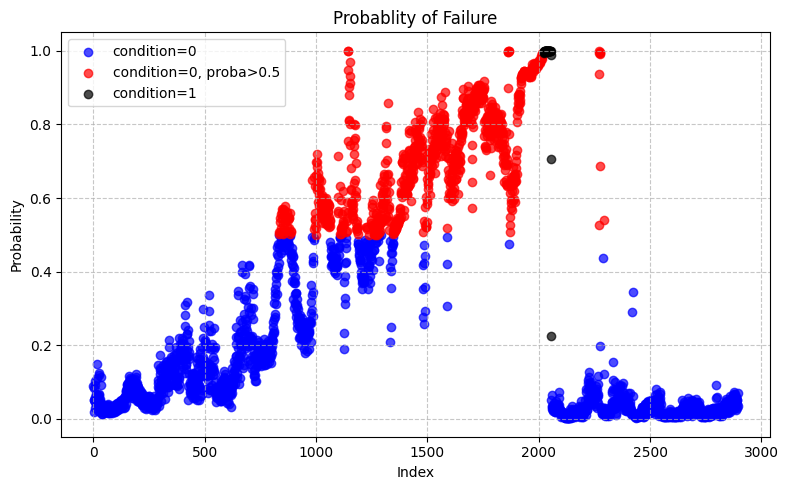

In [70]:
penalty, C_value, solver, max_iter = "l2", 1, "liblinear", 500

aggregation_size, sliding_amount = 100,50

dataframe = df_opt

###########################################

treshold_probability = 0.5

aggregated_probabilities = agg_new_deneme(penalty, C_value, solver, max_iter,dataframe, aggregation_size, 4, 2, 4, 2, 4, 2, 15, 5, "yes", "yes", "yes", "no", sliding_amount)

calculate_scores(aggregated_probabilities)

plot_probabilities_by_condition(aggregated_probabilities, treshold_probability)